In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as pt
import glob
import time
import os
import shutil
import pathlib
import matplotlib

from ase.io import read
from pyiron import Project, ase_to_pyiron

from molmod.units import *
from molmod.constants import *

from collections import namedtuple, Counter
from dataclasses import dataclass # replaces namedtuple with mutable attributes
%matplotlib inline

matplotlib.rcParams.update({'font.size': 10})


In [2]:
# Create project for rotational barriers characterization
pr = Project('barriers')
pr_rasha = pr.create_group('rasha')
pr_rasha.base_name
name = 'job_0'
path = os.path.join('barriers/rasha', pr_rasha.name + '_SB', name + '_hdf5', name)
print(os.path.abspath(path))

/arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/rasha_SB/job_0_hdf5/job_0


In [3]:
# g16 job function
def g16_job(pr, structure, name, jobtype='sp', lot='B3LYP', basis_set='6-311++G(d,p)', settings={'EmpiricalDispersion':['GD3'], 'int':['grid=ultrafine'], 'scf':['tight','maxcycle=5000']}, suffix=None, cores=9, run_time=60*60):
    job = pr.create_job(pr.job_type.Gaussian, name, delete_existing_job=False)
    job.structure = structure
    job.input['jobtype'] = jobtype
    job.input['lot'] = lot
    job.input['basis_set'] = basis_set
    
    if not settings is None:
        job.input['settings'] = settings
        
    if suffix is not None:
        job.input['suffix'] = suffix
    
    path = os.path.join('barriers/rasha', pr.name + '_SB', name + '_hdf5', name)
    
    job.restart_file_list.append(os.path.join(os.path.abspath(path), 'input.fchk')) 
    job.restart_file_list.append(os.path.join(os.path.abspath(path), 'input.log'))
    job.server.run_mode.manual = True
    job.run()
    
    job.status.collect = True
    job.run()

In [4]:
# g16 job function
def g16_gic_job(pr, structure, name, jobtype='opt', lot='B3LYP', basis_set='6-311++G(d,p)', settings={'EmpiricalDispersion':['GD3'], 'int':['grid=ultrafine'], 'scf':['tight','maxcycle=5000'], 'geom':['addgic'], 'nosymm':[]}, suffix=None, run_time=2*60*60):
    job = pr.create_job(pr.job_type.Gaussian, name, delete_existing_job=False)
    job.structure = structure
    job.input['jobtype'] = jobtype
    job.input['lot'] = lot
    job.input['basis_set'] = basis_set
    
    if not settings is None:
        job.input['settings'] = settings
        
    if suffix is not None:
        job.input['suffix'] = suffix
        
    path = os.path.join('barriers/rasha', pr.name + '_SB', name + '_hdf5', name)
    
    job.restart_file_list.append(os.path.join(os.path.abspath(path), 'input.fchk')) 
    job.restart_file_list.append(os.path.join(os.path.abspath(path), 'input.log'))
    job.server.run_mode.manual = True
    job.run()
    
    job.status.collect = True
    job.run()

In [5]:
# g16 job function
def g16_gic_yqc_job(pr, structure, name, jobtype='opt', lot='B3LYP', basis_set='6-311++G(d,p)', settings={'EmpiricalDispersion':['GD3'], 'int':['grid=ultrafine'], 'scf':['YQC','tight','maxcycle=5000'], 'geom':['addgic'], 'nosymm':[]}, suffix=None, run_time=2*60*60):
    job = pr.create_job(pr.job_type.Gaussian, name, delete_existing_job=False)
    job.structure = structure
    job.input['jobtype'] = jobtype
    job.input['lot'] = lot
    job.input['basis_set'] = basis_set
    
    if not settings is None:
        job.input['settings'] = settings
        
    if suffix is not None:
        job.input['suffix'] = suffix
        
    path = os.path.join('barriers/rasha', pr.name + '_SB', name + '_hdf5', name)
    
    job.restart_file_list.append(os.path.join(os.path.abspath(path), 'input.fchk')) 
    job.restart_file_list.append(os.path.join(os.path.abspath(path), 'input.log'))
    job.server.run_mode.manual = True
    job.run()
    
    job.status.collect = True
    job.run()

In [6]:
# yaff job function
def yaff_opt_job(pr, name, structure, ffs, ffpars):
    job = pr.create_job(pr.job_type.Yaff, name, delete_existing_job=False)
    
    job.calc_minimize(max_iter=10000)

    job.input['ffpars'] = ffpars
    job.structure = structure
    job.ffatypes = ffs.ffatypes
    job.ffatype_ids = ffs.ffatype_ids
    job.bonds = ffs.bonds

    job.server.queue = 'doduo'
    job.server.cores = 1
    job.server.run_time = 5*60*60 # in seconds

    job.run()


In [7]:
# yaff job function
def yaff_scan_job(pr, name, sinfo, ffpars):
    job = pr.create_job(pr.job_type.Yaff, name, delete_existing_job=False)
    job.structure = sinfo.ff.structure
    job.input['ffpars'] = ffpars # separate to allow for varying ffpars
    
    job.ffatypes = sinfo.ff.ffatypes
    job.ffatype_ids = sinfo.ff.ffatype_ids
    job.bonds = sinfo.ff.bonds

    job.calc_scan(np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step), adapt_structure=sinfo.adapt_structure)
    job.server.queue = 'doduo'
    job.server.cores = 1
    job.server.run_time = 15*60 # in seconds   
    job.run()


In [8]:
# yaff job function
def yaff_scan_structures_job(pr, name, sinfo, ffpars, structures):
    job = pr.create_job(pr.job_type.Yaff, name, delete_existing_job=False)
    job.structure = sinfo.ff.structure
    job.input['ffpars'] = ffpars # separate to allow for varying ffpars
    
    job.ffatypes = sinfo.ff.ffatypes
    job.ffatype_ids = sinfo.ff.ffatype_ids
    job.bonds = sinfo.ff.bonds

    job.calc_scan(np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step),structures=structures)
    job.server.queue = 'doduo'
    job.server.cores = 1
    job.server.run_time = 15*60 # in seconds   
    job.run()

## Perform AI scans

### Functions

In [9]:
'''@dataclass
class ff_object:
    structure: object
    ffpars: object
    ffpars_nodih: object
    ffpars_polysix: object
    ffatypes: object
    ffatype_ids: object
    bonds : object'''
        
        
class FFobject(object):
    def __init__(self,block_name,structure,ffatypes,ffatype_ids,bonds,fnames,fn_ai,ffpars_nodih=None,ffpars_polysix=None):
        self.block_name = block_name
        self.structure = structure
        self.ffatypes = ffatypes
        self.ffatype_ids = ffatype_ids
        self.bonds = bonds
        self.fnames = fnames
        self.ffpars = self._set_ffpars()
        self.fn_ai = fn_ai
        self.ffpars_nodih = ffpars_nodih
        self.ffpars_polysix = ffpars_polysix
        
    def _set_ffpars(self):
        ffpars = ''
        for fn in self.fnames:
            with open(fn,'r') as f:
                ffpars+=f.read()
        return ffpars

In [10]:
# Structure info and rotation grid
class Sinfo(object):
    def __init__(self,pr,ff,indices,mask=None,range_min=0,range_max=90,range_step=1,degeneracy=None, fit_indices=None):
        self.pr = pr
        self.ff = FFobject(ff.block_name,ff.structure,ff.ffatypes,ff.ffatype_ids,ff.bonds,ff.fnames,ff.fn_ai,ffpars_nodih=ff.ffpars_nodih,ffpars_polysix=ff.ffpars_polysix) # create new object to avoid overwritten when using the same FFObject for difference sinfos
        self.indices = indices
        self.mask = mask
        self.mask_indices = None 
        self.range_min = range_min
        self.range_max = range_max
        self.range_step = range_step
        self.degeneracy = degeneracy
        
        self.fit_indices = fit_indices
        
        self._set_mask_indices()
        self.adapt_structure = self._set_adapt_structure()
        
        
    # Define function to identify mask for rotation
    @staticmethod
    def get_mask(structure,indices):
        # Assume that we can define mask by taking all atoms in the direction of the dihedral
        ref_vector = structure.positions[indices[2]] - structure.positions[indices[1]]
        mask = np.array([np.dot(pos - structure.positions[indices[1]], ref_vector) >= 0 for pos in structure.positions],dtype=np.int)
        return mask
        
    def _set_mask_indices(self):
        if self.mask is None:
            self.mask = self.get_mask(self.ff.structure,self.indices)
        else:
            if len(self.mask)<len(self.ff.structure):
                self.mask_indices = copy.copy(self.mask)
                self.mask = None
            else:
                assert len(self.mask)==len(self.ff.structure)
                self.mask_indices=None
                
    def _set_adapt_structure(self):
        
        def adapt_structure(structure,angle,idx=self.indices,mask=self.mask,indices=self.mask_indices):
            new_structure = self.ff.structure.copy()
            new_structure.set_dihedral(*idx,angle=angle,mask=mask,indices=indices) # angle in degrees
            return new_structure
        
        return adapt_structure
                
    def get_sub_project_name(self,key,suffix=None):
        if suffix is not None:
            return 'barriers/{}/{}_{}_{}'.format(self.pr.name,key,"_".join([str(i) for i in self.indices]),suffix)
        else:
            return 'barriers/{}/{}_{}'.format(self.pr.name,key,"_".join([str(i) for i in self.indices]))

In [11]:
# ICs check (only dihedral can change)

from yaff import *
from yaff.log import *
import copy

log.set_level(0)

def get_ICs(system, ics):
    num = 0
    ICl = InternalCoordinateList(DeltaList(system))
    for ic in ics:
        ICl.add_ic(ic)
        num+=1
    ICl.dlist.forward()
    ICl.forward()

    values = np.zeros(num)
    for n in range(num):
        values[n] = ICl.ictab[n][-2]

    return values

# Define function to read dihedral ffatype sets to see whether they are correctly removed
def read_dihedral_terms(ffpars):
    dih_set = []
    for line in ffpars.split('\n'):
        if line.startswith('TORSION:PARS'):
            l = line.split()
            dih_set.append(tuple((l[1],l[2],l[3],l[4])))
    return set(dih_set)



def write_ffpars_nodih(name,sinfo):
    dih_values = []
    dihedral_set = read_dihedral_terms(sinfo.ff.ffpars)

    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        system = System(sinfo.ff.structure.numbers, adapted_structure.positions.copy(), ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)

        dihs = []
        dihs_angle = []
        for dih in system.iter_dihedrals():
            dihs.append([system.ffatypes[system.ffatype_ids[i]] for i in dih])
            dihs_angle.append(DihedAngle(*dih))

        dih_values.append(np.round(np.array(get_ICs(system, dihs_angle)),8))

    dih_values = np.asarray(dih_values)

    print("{} ICs\n".format(name))

    # print out those that change during trajectory
    dihedral_deviations = np.zeros(dih_values.shape[1])    
    for n in range(len(dihedral_deviations)):
        dihedral_deviations[n] = np.average(np.arccos(np.cos(dih_values[:,n]-dih_values[-1,n])))

    print("Dihedrals:")
    degeneracy = 0
    for n in range(len(dihedral_deviations)):
        if dihedral_deviations[n] > 5e-1:
            degeneracy += 1
            print(dihs[n])#, dihedral_deviations[n])
            if tuple(dihs[n]) in dihedral_set:
                dihedral_set.remove(tuple(dihs[n]))
            elif tuple(dihs[n][::-1]) in dihedral_set:
                dihedral_set.remove(tuple(dihs[n][::-1]))
                
    sinfo.degeneracy = degeneracy
    
    # Making adapted force field parameter file
    ffpars_reduced = ''
    for line in sinfo.ff.ffpars.split('\n'):
        if line.startswith('TORSION:PARS'):
            l = line.split()
            dih = tuple((l[1],l[2],l[3],l[4]))
            if dih in dihedral_set:
                ffpars_reduced+=line+'\n'
            else:
                print('Removed the following line: ', line)
        else:
            ffpars_reduced+=line+'\n'
            
    sinfo.ff.ffpars_nodih = ffpars_reduced
    print('\n\n')
                

def plot_IC_variations(name,sinfo):
    print(sinfo.ff.block_name)
    bond_values = []
    bend_values = []
    dih_values = []
  
    dihedral_set = read_dihedral_terms(sinfo.ff.ffpars)
    if sinfo.ff.structure.cell.volume >0:
        system = System(sinfo.ff.structure.numbers, sinfo.ff.structure.positions.copy(), ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds, rvecs=sinfo.ff.structure.cell.array)
    else:
        system = System(sinfo.ff.structure.numbers, sinfo.ff.structure.positions.copy(), ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)
    yaff_ff = ForceField.generate(system, sinfo.ff.fnames, rcut=12.0*angstrom, alpha_scale=3.2, gcut_scale=1.5, smooth_ei=True, tailcorrections=True)

    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        yaff_ff.update_pos(adapted_structure.positions)
        #system = System(sinfo.ff.structure.numbers, adapted_structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)

        dihs = []
        dihs_angle = []
        for dih in yaff_ff.system.iter_dihedrals():
            dihs.append([yaff_ff.system.ffatypes[yaff_ff.system.ffatype_ids[i]] for i in dih])
            dihs_angle.append(DihedAngle(*dih))


        bends = []
        bend_angles = []
        for bend in system.iter_angles():
            bends.append([yaff_ff.system.ffatypes[yaff_ff.system.ffatype_ids[i]] for i in bend])
            bend_angles.append(BendAngle(*bend))

        bonds = []
        bond_lengths = []
        for bond in system.iter_bonds():
            bonds.append([yaff_ff.system.ffatypes[yaff_ff.system.ffatype_ids[i]] for i in bond])
            bond_lengths.append(Bond(*bond))

        bond_values.append(np.array(get_ICs(yaff_ff.system, bond_lengths)))
        bend_values.append(np.array(get_ICs(yaff_ff.system, bend_angles)))
        dih_values.append(np.round(np.array(get_ICs(yaff_ff.system, dihs_angle)),8))

    bond_values = np.asarray(bond_values)
    bend_values = np.asarray(bend_values)
    dih_values = np.asarray(dih_values)

    print("{} ICs\n".format(name))

    # print out those that change during trajectory
    
    #indx = np.where(bond_values[0,:]>10)[0]
    #for i in indx:
    #    print(bonds[i],bond_values[0,i], list(system.iter_bonds())[i])
    
    
    bond_deviations = np.zeros(bond_values.shape[1])
    for n in range(len(bond_deviations)):
        bond_deviations[n] = np.sum(np.abs(bond_values[:,n] - np.average(bond_values[:,n])))

    print("Bonds:")
    for n in range(len(bond_deviations)):
        if not bond_deviations[n] < 1e-5:
            print(bonds[n], bond_deviations[n])

    bend_deviations = np.zeros(bend_values.shape[1])
    for n in range(len(bend_deviations)):
        bend_deviations[n] = np.sum(np.abs(bend_values[:,n] - np.average(bend_values[:,n])))

    print("Bends:")
    for n in range(len(bend_deviations)):
        if not bend_deviations[n] < 1e-5:
            print(bends[n])#, bend_deviations[n])

    dihedral_deviations = np.zeros(dih_values.shape[1])    
    for n in range(len(dihedral_deviations)):
        dihedral_deviations[n] = np.average(np.arccos(np.cos(dih_values[:,n]-dih_values[-1,n])))

    print("Dihedrals:")
    for n in range(len(dihedral_deviations)):
        if not dihedral_deviations[n] < 2e-1:
            print(dihs[n], dihedral_deviations[n])
            try:
                assert tuple(dihs[n]) in dihedral_set or tuple(dihs[n][::-1]) in dihedral_set
            except AssertionError:
                print('There was no FF term for the following dihedral: ', tuple(dihs[n]))
                
    print("\n\n")


    # Plot trajectory of ICs
    fig,ax = pt.subplots(1,3,figsize=(15,10))
    for n in range(bond_values.shape[1]):
        ax[0].plot(grid,bond_values[:,n])
    ax[0].set_title('Bonds')

    for n in range(bend_values.shape[1]):
        ax[1].plot(grid,np.rad2deg(bend_values[:,n]))
    ax[1].set_title('Bends')

    for n in range(dih_values.shape[1]):
        if not dihedral_deviations[n] < 2e-1:
            ax[2].plot(grid,np.rad2deg(dih_values[:,n]),label=str(dihs[n]))
    ax[2].legend(bbox_to_anchor=(1.1,.5), loc='center left',frameon=False)
    ax[2].set_title('Dihedrals')
    pt.show()

def compare_structures(name,pr,ff,structures,log_bonds=True,log_bends=True,log_dihedrals=True,save_png=False):
    bond_values = []
    bend_values = []
    dih_values = []
  

    for n,structure in enumerate(structures.values()):
        system = System(structure.numbers, structure.positions, ffatypes=ff.ffatypes, ffatype_ids=ff.ffatype_ids, bonds=ff.bonds)

        dihs = []
        dihs_angle = []
        for dih in system.iter_dihedrals():
            dihs.append([system.ffatypes[system.ffatype_ids[i]] for i in dih])
            dihs_angle.append(DihedAngle(*dih))


        bends = []
        bend_angles = []
        for bend in system.iter_angles():
            bends.append([system.ffatypes[system.ffatype_ids[i]] for i in bend])
            bend_angles.append(BendAngle(*bend))

        bonds = []
        bond_lengths = []
        for bond in system.iter_bonds():
            bonds.append([system.ffatypes[system.ffatype_ids[i]] for i in bond])
            bond_lengths.append(Bond(*bond))

        bond_values.append(np.array(get_ICs(system, bond_lengths)))
        bend_values.append(np.array(get_ICs(system, bend_angles)))
        dih_values.append(np.round(np.array(get_ICs(system, dihs_angle)),8))

    bond_values = np.asarray(bond_values)
    bend_values = np.asarray(bend_values)
    dih_values = np.asarray(dih_values)

    print("{} ICs\n".format(name))

    # print out those that have a large difference between reference (-1) and latest FF calculation (-2) 
    bond_deviations = np.zeros(bond_values.shape[1])
    for n in range(len(bond_deviations)):
        bond_deviations[n] = np.sum(np.abs(bond_values[-2,n] - bond_values[-1,n]))
        
    bond_deviations_old = np.zeros(bond_values.shape[1])
    if len(structures)==3:
        for n in range(len(bond_deviations_old)):
            bond_deviations_old[n] = np.sum(np.abs(bond_values[0,n] - bond_values[-1,n]))

    if log_bonds:
        print("Bonds:")
        for n in range(len(bond_deviations)):
            if not bond_deviations[n] < 1e-2:
                print(bonds[n], bond_deviations[n])

    bend_deviations = np.zeros(bend_values.shape[1])
    for n in range(len(bend_deviations)):
        bend_deviations[n] = np.sum(np.abs(bend_values[-2,n] - bend_values[-1,n]))
        
    bend_deviations_old = np.zeros(bend_values.shape[1])
    if len(structures)==3:
        for n in range(len(bend_deviations_old)):
            bend_deviations_old[n] = np.sum(np.abs(bend_values[0,n] - bend_values[-1,n]))

    if log_bends:
        print("Bends:")
        for n in range(len(bend_deviations)):
            if not bend_deviations[n] < 2*deg:
                print(bends[n], np.rad2deg(bend_deviations[n]))

    dihedral_deviations = np.zeros(dih_values.shape[1])
    for n in range(len(dihedral_deviations)):
        dihedral_deviations[n] = np.average(np.arccos(np.cos(dih_values[-2,n]-dih_values[-1,n])))
        
        
    dihedral_deviations_old = np.zeros(dih_values.shape[1])
    if len(structures)==3:
        for n in range(len(dihedral_deviations_old)):
            dihedral_deviations_old[n] = np.average(np.arccos(np.cos(dih_values[0,n]-dih_values[-1,n])))

    if log_dihedrals:
        uniq_dih_axes = []
        print("Dihedrals:")
        for n in range(len(dihedral_deviations)):
            if not dihedral_deviations[n] < 10*deg:
                if dihs[n][1:3] not in uniq_dih_axes and dihs[n][2:0:-1] not in uniq_dih_axes:
                    uniq_dih_axes.append(dihs[n][1:3])
                    print(dihs[n][1:3], np.rad2deg(dihedral_deviations[n]))

                
    print("\n\n")
    
    # Plot trajectory of ICs
    num_plots = int(log_bonds+log_bends+log_dihedrals)
    index = 0
    fig,ax = pt.subplots(num_plots,1,figsize=(10,30),sharex=True)
    if num_plots==1:
        ax = [ax]
    
    if log_bonds:
        for n in range(bond_values.shape[1]):
            if bond_deviations[n] > 1e-2:
                ax[index].plot(range(len(structures)),bond_values[:,n],marker='o',label=str(bonds[n]))
            elif bond_deviations_old[n] > 1e-2:
                ax[index].plot(range(len(structures)),bond_values[:,n],marker='o')
        ax[index].set_title('Bonds')
        ax[index].legend(bbox_to_anchor=(1.1,.5), loc='center left',frameon=False)
        index+=1
    

    if log_bends:
        for n in range(bend_values.shape[1]):
            if bend_deviations[n] > 2*deg:
                ax[index].plot(range(len(structures)),np.rad2deg(bend_values[:,n]),marker='o',label=str(bends[n]))
            elif bend_deviations_old[n] > 2*deg:
                ax[index].plot(range(len(structures)),np.rad2deg(bend_values[:,n]),linestyle='--',marker='o',alpha=0.5)
        ax[index].set_title('Bends')
        ax[index].legend(bbox_to_anchor=(1.1,.5), loc='center left',frameon=False)
        index+=1

    if log_dihedrals:
        for n in range(dih_values.shape[1]):
            if dihedral_deviations[n] > 10*deg:
                ax[index].plot(range(len(structures)),np.rad2deg(dih_values[:,n]),marker='o',label=str(dihs[n]))
            elif dihedral_deviations_old[n] > 10*deg:
                ax[index].plot(range(len(structures)),np.rad2deg(dih_values[:,n]),linestyle='--',marker='o',alpha=0.5)

        ax[index].legend(bbox_to_anchor=(1.1,.5), loc='center left',frameon=False)
        ax[index].set_title('Dihedrals')
        
    ax[index].set_xticks(range(len(structures)))
    ax[index].set_xticklabels(structures.keys())
    
    if save_png:
        path = pr.root_path +  pr.project_path.split('/')[0] + '/input_files/' + '/'.join(pr.project_path.split('/')[1:]) + '{}/ICs/'.format(ff.block_name)
        pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
        pt.savefig(path+'{}.png'.format(name))
    
    pt.show()

### Layer stacking

In [12]:
pr_rasha = Project('barriers/rasha')

In [13]:
pr_rasha.job_table()

id    status chemicalformula                     job  \
0     169  finished      C48H36N6O6                   job_0   
1     170  finished      C48H36N6O6                   job_1   
2     171  finished      C48H36N6O6                   job_2   
3     172  finished      C48H36N6O6                   job_3   
4     173  finished      C48H36N6O6                   job_4   
..    ...       ...             ...                     ...   
921  1090   aborted      C48H36N6O6   scan_PA11_vertex_wdih   
922  1091   aborted      C34H26N4O3  scan_PA12_vertex_nodih   
923  1092   aborted      C34H26N4O3   scan_PA12_vertex_wdih   
924  1093   aborted      C27H21N3O3    scan_TP_vertex_nodih   
925  1094   aborted      C27H21N3O3     scan_TP_vertex_wdih   

                      subjob  \
0                     /job_0   
1                     /job_1   
2                     /job_2   
3                     /job_3   
4                     /job_4   
..                       ...   
921   /scan_PA11_vertex_wdih   
922  /scan_PA12_vertex_nodih   
923   /scan_PA12_vertex_wdih   
924    /scan_TP_vertex_nodih   
925     /scan_TP_vertex_wdih   

                                                                 projectpath  \
0    /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
1    /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
2    /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
3    /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
4    /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
..                                                                       ...   
921  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
922  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
923  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
924  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
925  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   

                            project                  timestart  \
0    rasha/PA11_vertex_10_11_12_17/ 2023-12-15 10:59:45.392138   
1    rasha/PA11_vertex_10_11_12_17/ 2023-12-15 10:59:48.636302   
2    rasha/PA11_vertex_10_11_12_17/ 2023-12-15 10:59:51.766512   
3    rasha/PA11_vertex_10_11_12_17/ 2023-12-15 10:59:54.903308   
4    rasha/PA11_vertex_10_11_12_17/ 2023-12-15 10:59:58.016988   
..                              ...                        ...   
921                          rasha/ 2023-12-15 11:29:29.703470   
922                          rasha/ 2023-12-15 11:29:29.635656   
923                          rasha/ 2023-12-15 11:29:29.731362   
924                          rasha/ 2023-12-15 11:29:44.993873   
925                          rasha/ 2023-12-15 11:29:58.034836   

                      timestop  totalcputime  \
0   2023-12-15 10:59:48.517489           3.0   
1   2023-12-15 10:59:51.642284           3.0   
2   2023-12-15 10:59:54.783623           3.0   
3   2023-12-15 10:59:57.903374           3.0   
4   2023-12-15 11:00:01.004348           2.0   
..                         ...           ...   
921 2023-12-15 11:29:34.828248           5.0   
922 2023-12-15 11:29:34.917250           5.0   
923 2023-12-15 11:29:34.952199           5.0   
924 2023-12-15 11:29:50.260802           5.0   
925 2023-12-15 11:30:02.481635           4.0   

                              computer  hamilton hamversion parentid masterid  
0          pyiron@gligar07.gastly.os#1  Gaussian        0.1     None     None  
1          pyiron@gligar07.gastly.os#1  Gaussian        0.1     None     None  
2          pyiron@gligar07.gastly.os#1  Gaussian        0.1     None     None  
3          pyiron@gligar07.gastly.os#1  Gaussian        0.1     None     None  
4          pyiron@gligar07.gastly.os#1  Gaussian        0.1     None     None  
..                                 ...       ...      

In [14]:
# Gather structures & force fields

# ffpars_nodih will be calculated by the write_ffpars_nodih function
# ffpars_polysix will be calculated by the write_ffpars_polysix function

ffs_rasha = {}

for block in glob.glob('./input_files/barriers/rasha/SBU_FFs/*/'):    
    block_name = block.split('/')[-2]
    print(block_name)

    ffpars_fns = [fn for fn in glob.glob(block+'pars_*.txt')]    
    print(ffpars_fns)
    if len(ffpars_fns)==0: continue
    fn_ai = glob.glob(block+'*_freq.fchk')[0]
    tmp = pr.create_job(pr.job_type.Yaff,'tmp',delete_existing_job=False)
    tmp.load_chk(glob.glob(block+'*_freq.chk')[0])
    structure = tmp.structure.copy() # ai structure
    tmp.load_chk(block+'system_opt.chk'.format(block_name))
    ffs_rasha[block_name] = FFobject(block_name,structure,tmp.ffatypes,tmp.ffatype_ids,tmp.bonds,ffpars_fns,fn_ai)

PA11
['./input_files/barriers/rasha/SBU_FFs/PA11/pars_ei.txt', './input_files/barriers/rasha/SBU_FFs/PA11/pars_yaff.txt', './input_files/barriers/rasha/SBU_FFs/PA11/pars_mm3.txt']
TP
['./input_files/barriers/rasha/SBU_FFs/TP/pars_ei.txt', './input_files/barriers/rasha/SBU_FFs/TP/pars_yaff.txt', './input_files/barriers/rasha/SBU_FFs/TP/pars_mm3.txt']
TPB
['./input_files/barriers/rasha/SBU_FFs/TPB/pars_ei.txt', './input_files/barriers/rasha/SBU_FFs/TPB/pars_yaff.txt', './input_files/barriers/rasha/SBU_FFs/TPB/pars_mm3.txt']
PA12
['./input_files/barriers/rasha/SBU_FFs/PA12/pars_ei.txt', './input_files/barriers/rasha/SBU_FFs/PA12/pars_yaff.txt', './input_files/barriers/rasha/SBU_FFs/PA12/pars_mm3.txt']
PA22
['./input_files/barriers/rasha/SBU_FFs/PA22/pars_ei.txt', './input_files/barriers/rasha/SBU_FFs/PA22/pars_yaff.txt', './input_files/barriers/rasha/SBU_FFs/PA22/pars_mm3.txt']


In [15]:
ffs_rasha['TP'].structure.plot3d(spacefill=False)

NGLWidget()

In [16]:
def flatten_molecular_system(start_atom_index,end_atom_index,avoid_idx,rotation_group,system,structure):
    new_structure = structure.copy()
    
    def get_connected_atoms(atom):
        return system.neighs1[atom]

    def modify_dihedral(angle):
        # Calculate the remainder when dividing the number by 180
        remainder = angle % 180

        # If the remainder is less than half of 180, round down
        if remainder < 90:
            rounded_angle = angle - remainder
        # If the remainder is greater than or equal to half of 180, round up
        else:
            rounded_angle = angle + (180 - remainder)

        return rounded_angle
        
    def get_indices(rotation_group):
        start = rotation_group[0]
        end = rotation_group[1]

        if not isinstance(end,list):
            end = [end]
        
        indices  = set([start])
        
        queue = [start]

        visited = [False] * len(structure)
        visited[start] = True

        while queue:
            current_atom = queue.pop(0)
            neighbors = get_connected_atoms(current_atom)

            for neighbor_atom in neighbors:
                if not visited[neighbor_atom]:
                    visited[neighbor_atom] = True
                    if neighbor_atom not in end:
                        indices.add(neighbor_atom)
                        queue.append(neighbor_atom)

        return list(indices)
        
    def flatten_dihedral(atom1, atom2, atom3, atom4, indices, structure):
        astructure = structure.copy()    
        dih = [int(atom1), int(atom2), int(atom3), int(atom4)]
        dihedral_angle = astructure.get_dihedral(*dih)
        flattened_angle = modify_dihedral(dihedral_angle)
        astructure.set_dihedral(*dih, angle=flattened_angle, indices=indices)
        #print(*dih, dihedral_angle,flattened_angle, astructure.get_dihedral(*dih))
        return astructure


    # Initialize all atoms as unvisited
    num_atoms = len(structure)
    visited = [False] * num_atoms
    fixed = set([start_atom_index])
    fixed.update(avoid_idx)

    # Start BFS from the given start_atom_index
    queue = [start_atom_index]
    visited[start_atom_index] = True
    
    indices = get_indices(rotation_group)
    #print(indices, len(indices))
    
    if not isinstance(end_atom_index ,list):
        end_atom_index = [end_atom_index]
        
    n = 0
    
    while queue:
        current_atom = queue.pop(0)
        neighbors = get_connected_atoms(current_atom)

        for neighbor_atom in neighbors:
            if not visited[neighbor_atom]:
                if neighbor_atom in avoid_idx:
                    fixed.update([neighbor_atom])
                    visited[neighbor_atom] = True
                    continue
                
                second_neighbor_atoms = get_connected_atoms(neighbor_atom)
                for second_neighbor_atom in second_neighbor_atoms:
                    if second_neighbor_atom != current_atom:
                        if second_neighbor_atom in avoid_idx: continue
                        # Flatten the dihedral between current_atom, neighbor_atom,
                        # second_neighbor_atom, and another non-repeated neighbor
                        third_neighbor_atoms = get_connected_atoms(second_neighbor_atom)
                        for third_neighbor_atom in third_neighbor_atoms:
                            if third_neighbor_atom in avoid_idx: continue
                            if third_neighbor_atom not in neighbors:
                                
                                if new_structure[int(third_neighbor_atom)].symbol == 'H':
                                    adapted_indices = [third_neighbor_atom]
                                else:
                                    adapted_indices = [i for i in indices if i not in [current_atom,second_neighbor_atom]+list(fixed)]
                                    
                                #if second_neighbor_atom in fixed and third_neighbor_atom in fixed: continue
                                    
                                new_structure = flatten_dihedral(current_atom, neighbor_atom, second_neighbor_atom, third_neighbor_atom, adapted_indices, new_structure)
                                fixed.update([current_atom, neighbor_atom, second_neighbor_atom, third_neighbor_atom])
                                n+= 1
                                if n==50:
                                    return new_structure

                # Mark the neighbor_atom as visited and add it to the queue for further exploration
                visited[neighbor_atom] = True
                if neighbor_atom not in end_atom_index:
                    queue.append(neighbor_atom)
                
    return new_structure

    # Start flattening dihedrals from an arbitrary atom
    #start_atom = 111

def flatten_center(ref_idx,center_group,system,structure,force=False):
    
    def get_connected_atoms(atom):
        return system.neighs1[atom]
    
    def modify_dihedral(angle):
        # Calculate the remainder when dividing the number by 180
        remainder = angle % 180

        # If the remainder is less than half of 180, round down
        if remainder < 90:
            rounded_angle = angle - remainder
        # If the remainder is greater than or equal to half of 180, round up
        else:
            rounded_angle = angle + (180 - remainder)

        return rounded_angle
    
    def get_indices(rotation_group):
        start = rotation_group[0]
        end = rotation_group[1]

        if not isinstance(end,list):
            end = [end]
        
        indices  = set([start])
        
        queue = [start]

        visited = [False] * len(structure)
        visited[start] = True

        while queue:
            current_atom = queue.pop(0)
            neighbors = get_connected_atoms(current_atom)

            for neighbor_atom in neighbors:
                if not visited[neighbor_atom]:
                    visited[neighbor_atom] = True
                    if neighbor_atom not in end:
                        indices.add(neighbor_atom)
                        queue.append(neighbor_atom)

        return list(indices)
    
    new_structure = structure.copy()
    center_indices = get_indices(center_group)
    print(center_indices)
    
    # set correct reference
    mask = np.ones(len(structure),dtype=np.bool)
    mask[np.array(center_indices)] = 0
    mask[np.array(ref_idx[:-1])] = 0
    new_structure.set_dihedral(*ref_idx,angle=0,mask=mask)
    
    # flatten everything inbetween
    for i in center_indices:
        try:
            dihedral_angle = new_structure.get_dihedral(*ref_idx[:-1],i)
        except ZeroDivisionError:
            continue
        flattened_angle = modify_dihedral(dihedral_angle)
        if np.isclose(flattened_angle,0) or force:
            new_structure.set_dihedral(*ref_idx[:-1],i,angle=flattened_angle)
    
    return new_structure
    
    
  

In [17]:
# Use yaff system to identify underlying graph
flattened = ffs_rasha['TPB'].structure.copy()
system = System(flattened.numbers, flattened.positions*angstrom)
system.detect_bonds()

# Flatten center
flattened = flatten_center([6,7,8,4],[44,[30,16,41]],system,flattened)
flattened = flatten_molecular_system(4,36,[3,5],[36,30],system,flattened)
flattened = flatten_molecular_system(2,50,[3,1],[50,44],system,flattened)
flattened = flatten_molecular_system(0,22,[1,5],[22,16],system,flattened)

#flattened.plot3d(spacefill=False)
ffs_rasha['TPB'].structure = flattened

[0, 1, 2, 3, 4, 5, 6, 7, 8, 35, 43, 44, 15, 49, 21, 29]


In [18]:
# Use yaff system to identify underlying graph
flattened = ffs_rasha['PA11'].structure.copy()
system = System(flattened.numbers, flattened.positions*angstrom)
system.detect_bonds()

# Flatten center
flattened = flatten_center([26,27,28,24],[40,[18,42,48]],system,flattened)
#flattened = flatten_center([29,30,31,14],[46,[10,44,54]],system,flattened)
flattened = flatten_center([26,27,30,29],[46,[10,44,54]],system,flattened)

# Flatten linkers wrt center
flattened = flatten_molecular_system(19,11,[20,12],[18,[10,19,37]],system,flattened)
flattened = flatten_molecular_system(22,94,[23,21],[94,22],system,flattened)
flattened = flatten_molecular_system(24,88,[23,25],[88,24],system,flattened)
flattened = flatten_molecular_system(14,90,[13,15],[90,14],system,flattened)
flattened = flatten_molecular_system(16,92,[17,15],[92,16],system,flattened)
    
#flattened.plot3d(spacefill=False)
ffs_rasha['PA11'].structure = flattened

[32, 33, 36, 40, 41, 43, 49, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[34, 35, 39, 11, 12, 13, 14, 47, 46, 15, 16, 17, 45, 55, 29, 30, 31]


In [19]:
# Use yaff system to identify underlying graph
flattened = ffs_rasha['PA12'].structure.copy()
system = System(flattened.numbers, flattened.positions*angstrom)
system.detect_bonds()

# Flatten center
flattened = flatten_center([26,27,28,24],[34,[18,36,38]],system,flattened)

# Flatten linkers wrt center
flattened = flatten_molecular_system(24,58,[23,25],[58,29],system,flattened)
flattened = flatten_molecular_system(22,60,[23,21],[60,30],system,flattened)
flattened = flatten_molecular_system(20,66,[25,21],[66,19],system,flattened)
    
#flattened.plot3d(spacefill=False)
ffs_rasha['PA12'].structure = flattened

[34, 35, 37, 39, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [20]:
# Use yaff system to identify underlying graph
flattened = ffs_rasha['PA22'].structure.copy()
system = System(flattened.numbers, flattened.positions*angstrom)
system.detect_bonds()

# Flatten linkers wrt center
flattened = flatten_molecular_system(35,21,[],[35,21],system,flattened)

#flattened.plot3d(spacefill=False)
ffs_rasha['PA22'].structure = flattened

In [21]:
ffs_rasha['TP'].structure.plot3d(spacefill=False)

NGLWidget()

In [22]:
# Structure info and rotation grid
# Degeneracy will be replaced by numerical value in the write_ffpars_nodih function
sinfos_rasha = {
    'PA22_imine': Sinfo(pr_rasha,ffs_rasha['PA22'],(2,0,10,11)), # GIC 
    'PA11_amine': Sinfo(pr_rasha,ffs_rasha['PA11'],(2,0,10,11)), # GIC
    'PA11_vertex': Sinfo(pr_rasha,ffs_rasha['PA11'],(10,11,12,17),mask=[12,13,14,15,16,17,29,30,31,34,35,45,47,44,46,53,55,52,54,56,71,70,75,74,90,72,91,69,73,59,68,67,77,76,92,78,93,66,79]), # GIC
    'PA12_imine': Sinfo(pr_rasha,ffs_rasha['PA12'],(2,0,10,11)), # GIC
    'PA12_amine': Sinfo(pr_rasha,ffs_rasha['PA12'],(3,1,18,19)), # GIC
    'PA12_vertex': Sinfo(pr_rasha,ffs_rasha['PA12'],(18,19,20,25),mask=[20,21,22,23,24,25,26,27,28,29,30,35,37,34,36,39,41,38,40,42,46,45,51,50,58,52,59,44,53,47,57,56,61,54,60,48,55,43,49]), # GIC
    'TPB_imine': Sinfo(pr_rasha,ffs_rasha['TPB'],(15,16,13,12)), # GIC
    'TPB_vertex':  Sinfo(pr_rasha,ffs_rasha['TPB'],(1,0,15,16)), # GIC
    'TP_amine':  Sinfo(pr_rasha,ffs_rasha['TP'],(9,12,18,29)), # GIC
    'TP_vertex': Sinfo(pr_rasha,ffs_rasha['TP'],(3,4,9,12),mask=[9,13,12,19,18,24,27,38,36,29,28,39,49,48,37]), # GIC
    
}

gic_info = { # all indices +1 !
    'PA22_imine' : "FreezeAll\nAng0 = A(1,11,12)\nAng1 = A(3,1,11)",  
    'PA11_amine' : "FreezeAll\nAng0 = A(1,11,12)\nAng1 = A(3,1,11)",   
    'PA11_vertex': "FreezeAll\nAng0 = A(11,12,13)\nAng1 = A(12,13,18)\nAng2 = A(13,18,31)\nAng3 = A(13,14,30)",   
    'PA12_imine' : "FreezeAll\nAng0 = A(1,11,12)\nAng1 = A(3,1,11)",      
    'PA12_amine' : "FreezeAll\nAng0 = A(2,19,20)\nAng1 = A(4,2,19)", 
    'PA12_vertex': "FreezeAll\nAng0 = A(19,20,21)\nAng1 = A(20,21,26)\nAng2 = A(21,22,27)\nAng3 = A(21,26,27)",   
    'TPB_imine'  : "FreezeAll\nAng0 = A(16,17,14)\nAng1 = A(17,14,13)", 
    'TPB_vertex' : "FreezeAll\nAng0 = A(2,1,16)\nAng1 = A(1,16,17)",  
    'TP_amine'   : "FreezeAll\nAng0 = A(10,13,19)\nAng1 = A(13,19,30)", 
    'TP_vertex'  : "FreezeAll\nAng0 = A(4,5,10)\nAng1 = A(5,10,13)\nAng2 = A(5,4,8)\nAng3 = A(5,6,7)",  
}


In [23]:
sinfos_rasha = { k.replace('-','_'):v for k,v in sinfos_rasha.items()}
gic_info = { k.replace('-','_'):v for k,v in gic_info.items()}

In [24]:
# Create groups - each key should be a group here
sinfo_rasha_groups = {}
groups = [k.replace('-','_') for k in list(ffs_rasha.keys())]

for name in groups:
    group_info = {}
    for sname,sinfo in sinfos_rasha.items():
        if sname.split('_')[0] == name:
            group_info[sname] = sinfo
            
    if len(group_info)>0:     
        sinfo_rasha_groups[name] = group_info

for n,(k,v) in enumerate(sinfo_rasha_groups.items()):
    print(n,k,list(v.keys()))

0 PA11 ['PA11_amine', 'PA11_vertex']
1 TP ['TP_amine', 'TP_vertex']
2 TPB ['TPB_imine', 'TPB_vertex']
3 PA12 ['PA12_imine', 'PA12_amine', 'PA12_vertex']
4 PA22 ['PA22_imine']


In [25]:
# Testing functions
name = 'PA12_vertex'
sinfo = sinfos_rasha[name]
sinfo.adapt_structure(sinfo.ff.structure,90).plot3d(spacefill=False)

NGLWidget()

PA22
PA22_imine ICs

Bonds:
Bends:
Dihedrals:
['C1_term', 'N_C2_PA22', 'C_C2N_PA22', 'C_HC2_PA22'] 0.7853981662637365
['C1_term', 'N_C2_PA22', 'C_C2N_PA22', 'C_HC2_PA22'] 0.7853981602986768





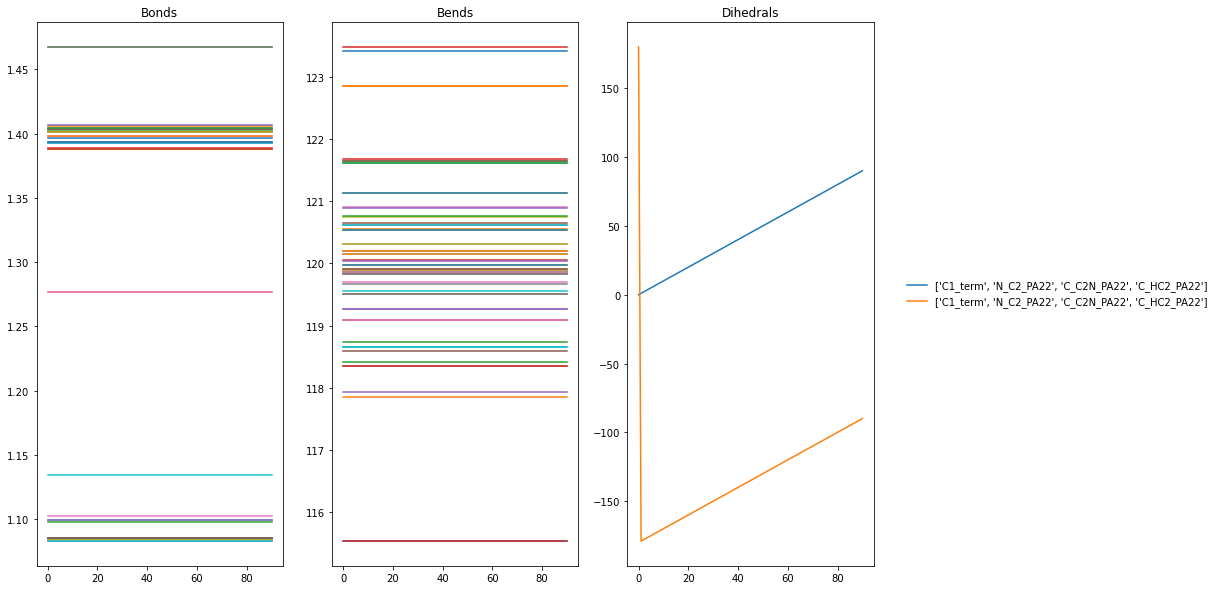

PA11
PA11_amine ICs

Bonds:
Bends:
Dihedrals:
['C1_term', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11'] 0.7853981662637365
There was no FF term for the following dihedral:  ('C1_term', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11')
['C1_term', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11'] 0.7853981627472528
There was no FF term for the following dihedral:  ('C1_term', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11')
['H_N_0_PA11', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11'] 0.7853981633755998
['H_N_0_PA11', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11'] 0.7853981618681318





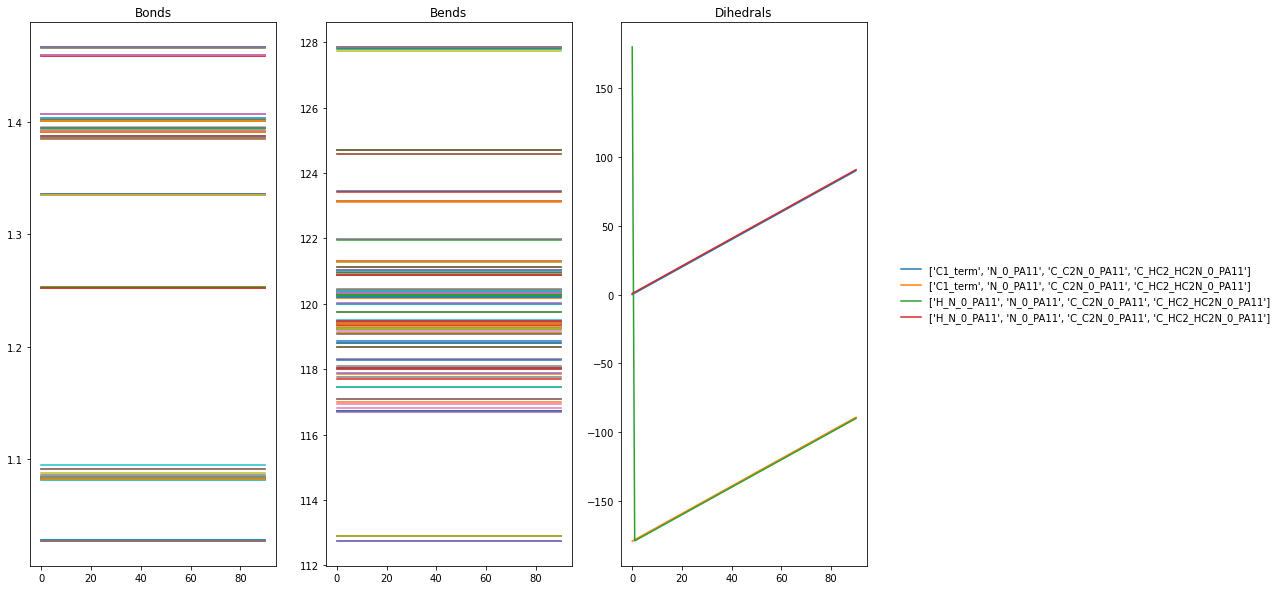

PA11
PA11_vertex ICs

Bonds:
Bends:
Dihedrals:
['C3_term', 'C2_term', 'C1_term', 'N_0_PA11'] 0.7853981662637365
['C3_term', 'C2_term', 'C1_term', 'H2_term'] 0.7853981662637363
['C3_term', 'C2_term', 'C1_term', 'N_0_PA11'] 0.7853981602197803
['C3_term', 'C2_term', 'C1_term', 'H2_term'] 0.7853981628571428





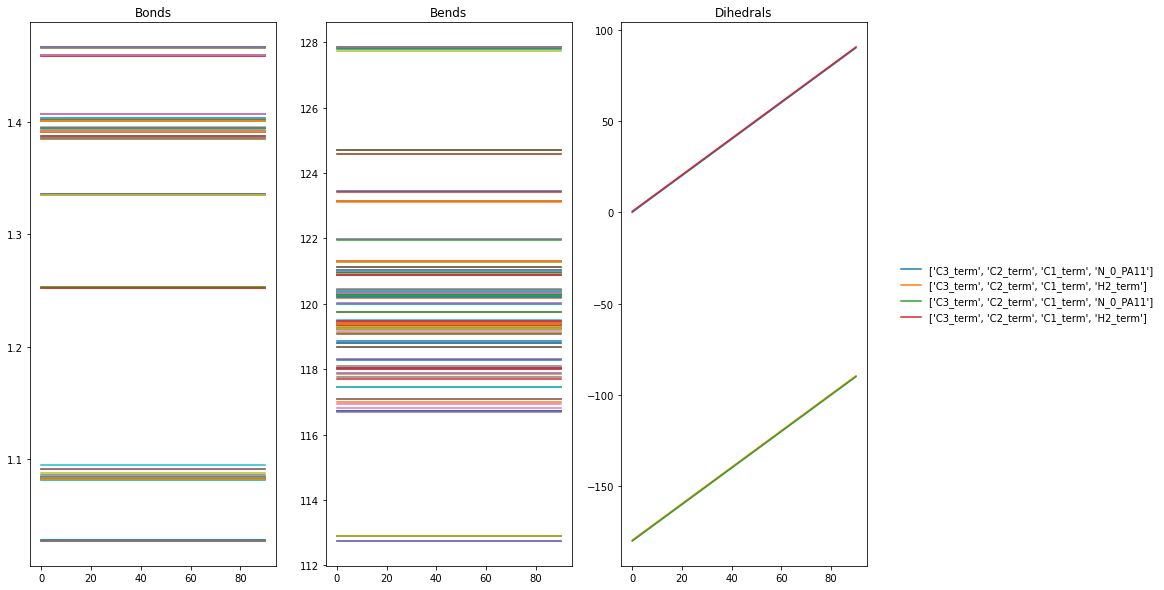

PA12
PA12_imine ICs

Bonds:
Bends:
Dihedrals:
['C1_term', 'N_C2_PA12', 'C_C2N_H2C3_PA12', 'C_HC2_HC2N_0_PA12'] 0.7853981612087912
['C1_term', 'N_C2_PA12', 'C_C2N_H2C3_PA12', 'C_HC2_HC2N_0_PA12'] 0.7853981651338419





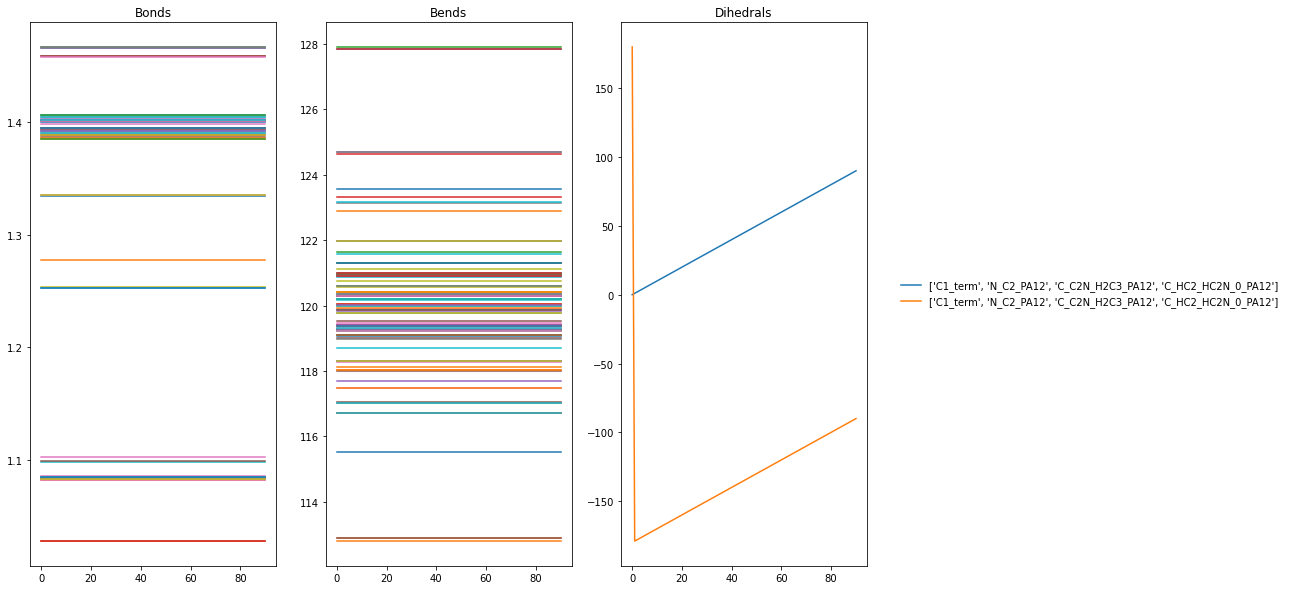

PA12
PA12_amine ICs

Bonds:
Bends:
Dihedrals:
['H_N_0_PA12', 'N_HC2_0_PA12', 'C_C2N_H3C3_0_PA12', 'C_HC2_HC2N_1_PA12'] 0.7853981651338419
['H_N_0_PA12', 'N_HC2_0_PA12', 'C_C2N_H3C3_0_PA12', 'C_HC2_HC2N_1_PA12'] 0.7853981612087912
['C1_term', 'N_HC2_0_PA12', 'C_C2N_H3C3_0_PA12', 'C_HC2_HC2N_1_PA12'] 0.7853981612087912
['C1_term', 'N_HC2_0_PA12', 'C_C2N_H3C3_0_PA12', 'C_HC2_HC2N_1_PA12'] 0.7853981651338419





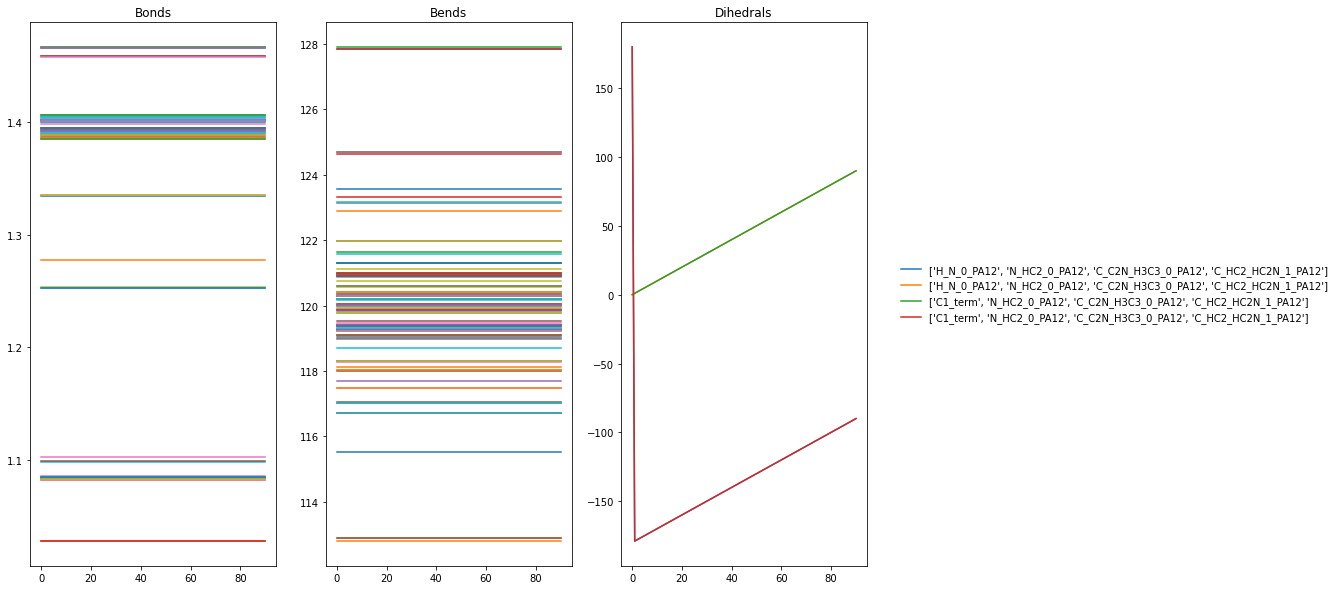

PA12
PA12_vertex ICs

Bonds:
Bends:
Dihedrals:
['C3_1_term', 'C2_1_term', 'C1_term', 'N_HC2_0_PA12'] 0.7853981662637365
['C3_1_term', 'C2_1_term', 'C1_term', 'H2_term'] 0.7853981671428574
['C3_1_term', 'C2_1_term', 'C1_term', 'N_HC2_0_PA12'] 0.785398165934066
['C3_1_term', 'C2_1_term', 'C1_term', 'H2_term'] 0.7853981587912088





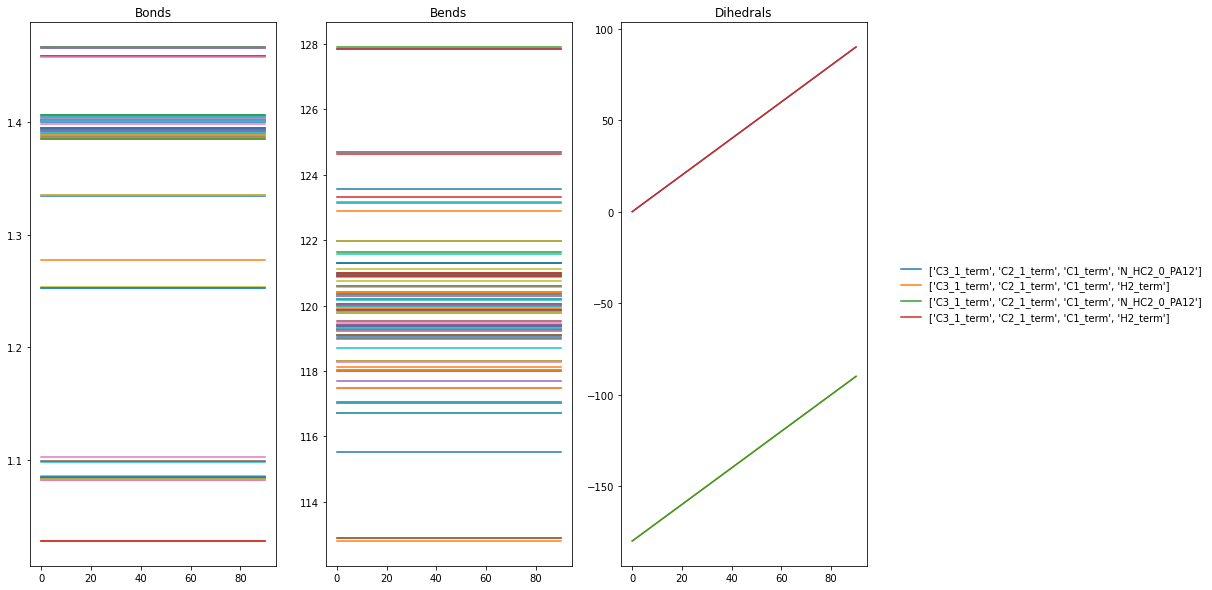

TPB
TPB_imine ICs

Bonds:
Bends:
Dihedrals:
['C_HCN_C3_TPB', 'N1_term', 'C2_term', 'C3_term'] 0.7853981662637365
['C_HCN_C3_TPB', 'N1_term', 'C2_term', 'C3_term'] 0.7853981602986768





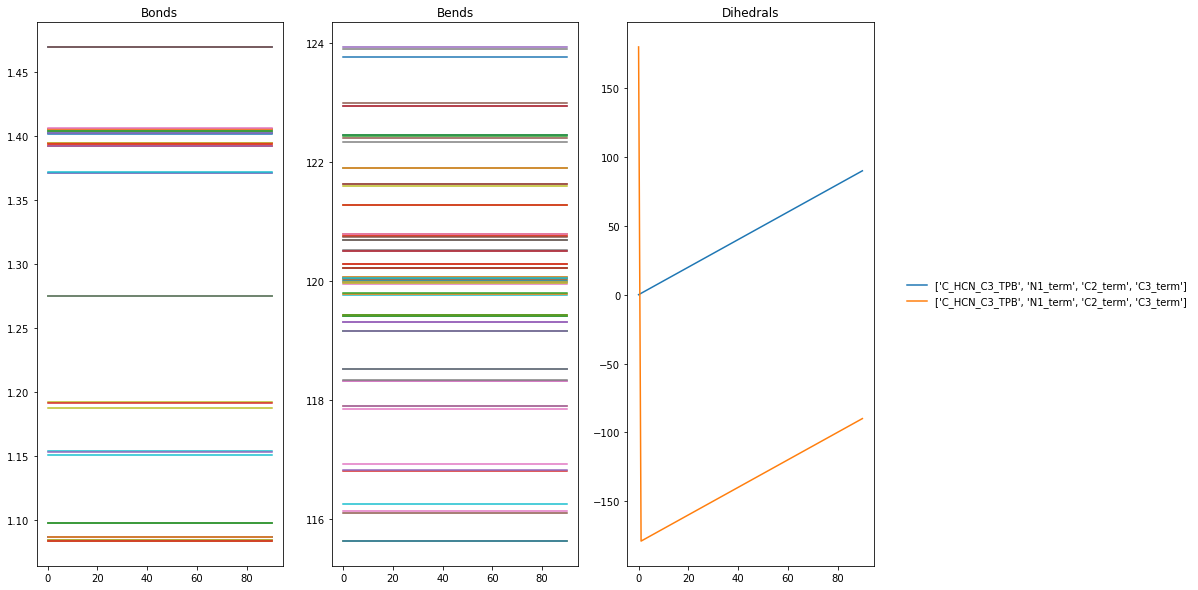

TPB
TPB_vertex ICs

Bonds:
Bends:
Dihedrals:
['N1_term', 'C_HCN_C3_TPB', 'C_C3_H3C2N_TPB', 'C_HC2_C4_TPB'] 0.7853981662637365
['N1_term', 'C_HCN_C3_TPB', 'C_C3_H3C2N_TPB', 'C_HC2_C4_TPB'] 0.785398166813187
['H_C_CN_TPB', 'C_HCN_C3_TPB', 'C_C3_H3C2N_TPB', 'C_HC2_C4_TPB'] 0.7853981684615385
['H_C_CN_TPB', 'C_HCN_C3_TPB', 'C_C3_H3C2N_TPB', 'C_HC2_C4_TPB'] 0.7853981612087912





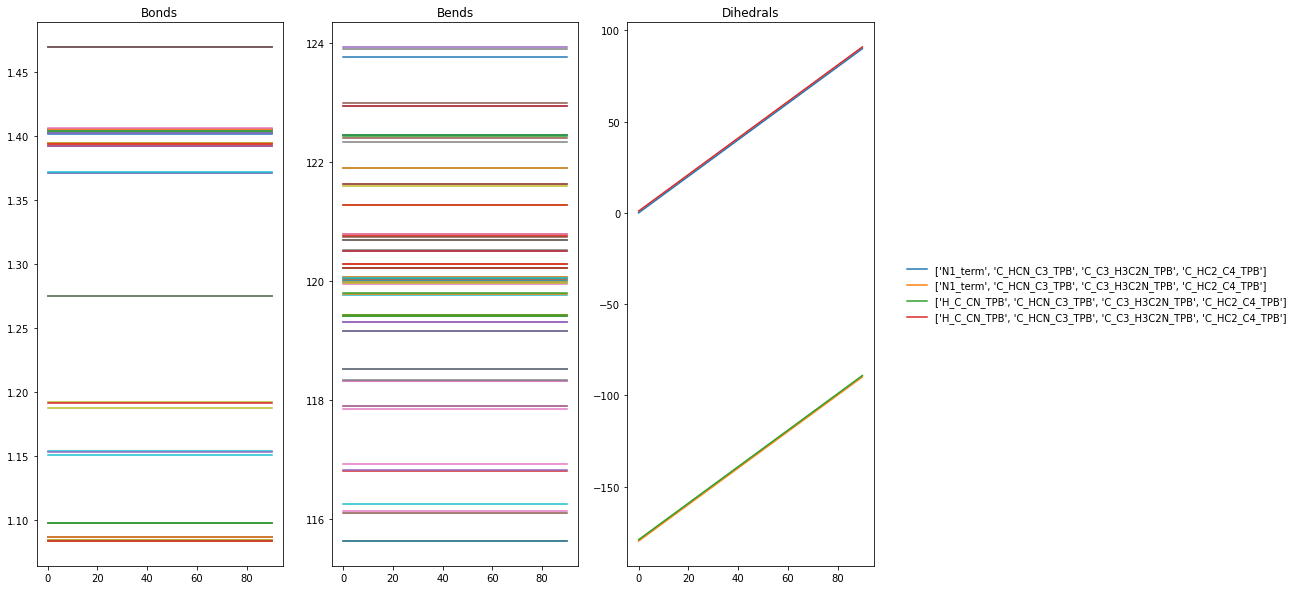

TP
TP_amine ICs

Bonds:
Bends:
Dihedrals:
['C3_term', 'C2_term', 'N1_term', 'C_HCN_TP'] 0.7853981637052704
There was no FF term for the following dihedral:  ('C3_term', 'C2_term', 'N1_term', 'C_HCN_TP')
['C3_term', 'C2_term', 'N1_term', 'H2_term'] 0.7853981619780221
There was no FF term for the following dihedral:  ('C3_term', 'C2_term', 'N1_term', 'H2_term')
['C3_term', 'C2_term', 'N1_term', 'C_HCN_TP'] 0.7853981662637365
There was no FF term for the following dihedral:  ('C3_term', 'C2_term', 'N1_term', 'C_HCN_TP')
['C3_term', 'C2_term', 'N1_term', 'H2_term'] 0.785398161758242
There was no FF term for the following dihedral:  ('C3_term', 'C2_term', 'N1_term', 'H2_term')





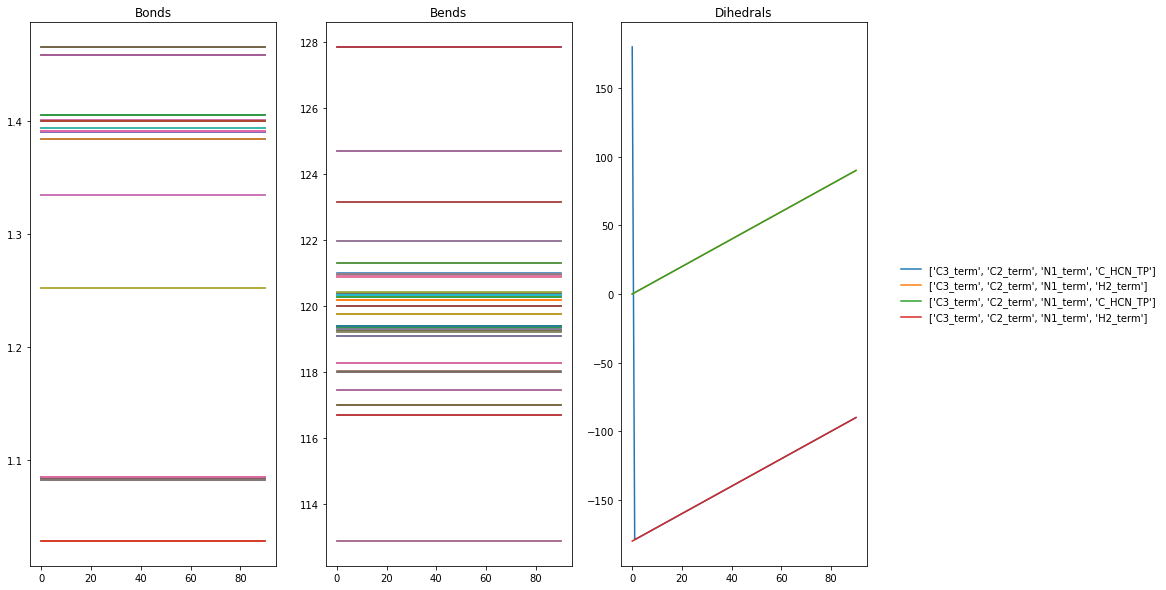

TP
TP_vertex ICs

Bonds:
Bends:
Dihedrals:
['H_C_CN_TP', 'C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 0.7853981668920834
['H_C_CN_TP', 'C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 0.7853981621978022
['N1_term', 'C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 0.7853981662637365
['N1_term', 'C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 0.7853981587912088





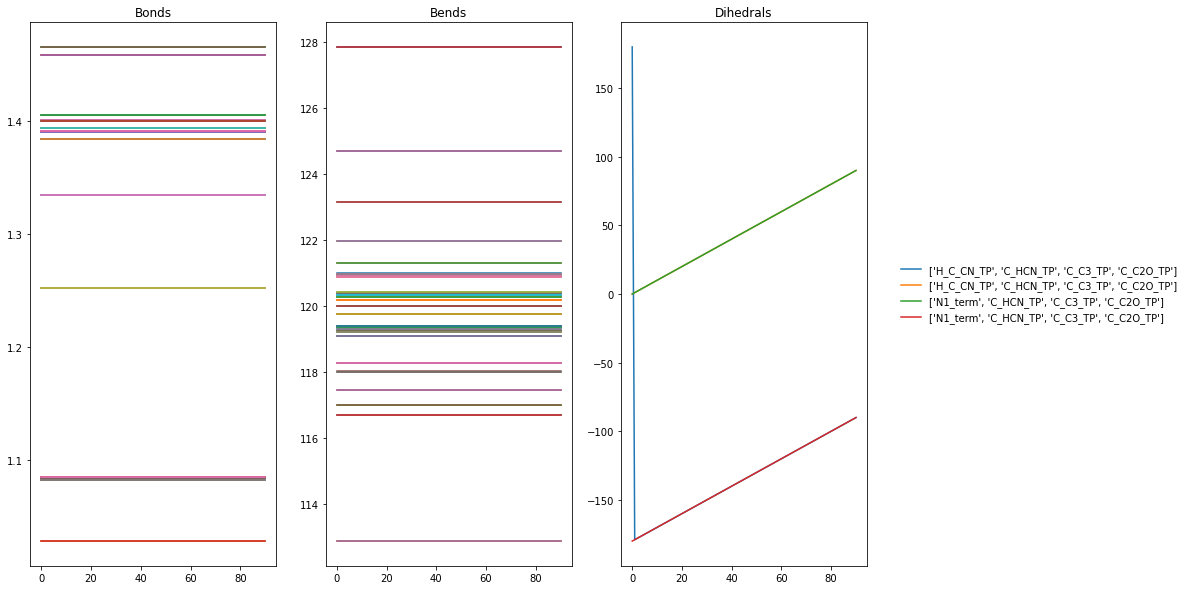

In [26]:
# First check whether only the dihedrals are changing
for name,sinfo in sinfos_rasha.items():
    plot_IC_variations(name,sinfo)

In [27]:
# Then alter the ff objects with the altered ffpars
for name,sinfo in sinfos_rasha.items():
    write_ffpars_nodih(name,sinfo)

PA22_imine ICs

Dihedrals:
['C1_term', 'N_C2_PA22', 'C_C2N_PA22', 'C_HC2_PA22']
['C1_term', 'N_C2_PA22', 'C_C2N_PA22', 'C_HC2_PA22']
Removed the following line:  TORSION:PARS   C1_term  N_C2_PA22  C_C2N_PA22  C_HC2_PA22  2 4.6140000634e+00  0.0000000000e+00



PA11_amine ICs

Dihedrals:
['C1_term', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11']
['C1_term', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11']
['H_N_0_PA11', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11']
['H_N_0_PA11', 'N_0_PA11', 'C_C2N_0_PA11', 'C_HC2_HC2N_0_PA11']
Removed the following line:  TORSION:PARS  C_HC2_HC2N_0_PA11  C_C2N_0_PA11  N_0_PA11  H_N_0_PA11  2 4.3746531185e+01  0.0000000000e+00



PA11_vertex ICs

Dihedrals:
['C3_term', 'C2_term', 'C1_term', 'N_0_PA11']
['C3_term', 'C2_term', 'C1_term', 'H2_term']
['C3_term', 'C2_term', 'C1_term', 'N_0_PA11']
['C3_term', 'C2_term', 'C1_term', 'H2_term']
Removed the following line:  TORSION:PARS   C3_term   C2_term   C1_term  N_0_PA11  2 2.8660478951e+01  0.000000000

In [28]:
pr_rasha.job_table(sort_by='status')

id    status chemicalformula                     job  \
925  1094   aborted      C27H21N3O3     scan_TP_vertex_wdih   
920  1089   aborted      C48H36N6O6  scan_PA11_vertex_nodih   
921  1090   aborted      C48H36N6O6   scan_PA11_vertex_wdih   
924  1093   aborted      C27H21N3O3    scan_TP_vertex_nodih   
923  1092   aborted      C34H26N4O3   scan_PA12_vertex_wdih   
..    ...       ...             ...                     ...   
312   481  finished        C20H16N2                  job_39   
313   482  finished        C20H16N2                  job_40   
314   483  finished        C20H16N2                  job_41   
316   485  finished        C20H16N2                  job_43   
462   631  finished      C34H26N4O3                   job_7   

                      subjob  \
925     /scan_TP_vertex_wdih   
920  /scan_PA11_vertex_nodih   
921   /scan_PA11_vertex_wdih   
924    /scan_TP_vertex_nodih   
923   /scan_PA12_vertex_wdih   
..                       ...   
312                  /job_39   
313                  /job_40   
314                  /job_41   
316                  /job_43   
462                   /job_7   

                                                                 projectpath  \
925  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
920  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
921  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
924  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
923  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
..                                                                       ...   
312  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
313  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
314  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
316  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
462  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   

                         project                  timestart  \
925                       rasha/ 2023-12-15 11:29:58.034836   
920                       rasha/ 2023-12-15 11:29:29.540351   
921                       rasha/ 2023-12-15 11:29:29.703470   
924                       rasha/ 2023-12-15 11:29:44.993873   
923                       rasha/ 2023-12-15 11:29:29.731362   
..                           ...                        ...   
312  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:11:00.223079   
313  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:11:00.847239   
314  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:11:01.474561   
316  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:11:02.773200   
462  rasha/PA12_imine_2_0_10_11/ 2023-12-15 11:16:28.133071   

                      timestop  totalcputime  \
925 2023-12-15 11:30:02.481635           4.0   
920 2023-12-15 11:29:34.297254           4.0   
921 2023-12-15 11:29:34.828248           5.0   
924 2023-12-15 11:29:50.260802           5.0   
923 2023-12-15 11:29:34.952199           5.0   
..                         ...           ...   
312 2023-12-15 11:11:00.735358           0.0   
313 2023-12-15 11:11:01.361336           0.0   
314 2023-12-15 11:11:01.991501           0.0   
316 2023-12-15 11:11:03.287688           0.0   
462 2023-12-15 11:16:29.595613           1.0   

                              computer  hamilton hamversion parentid masterid  
925  pyiron@gligar07.gastly.os#1#doduo      Yaff        0.1     None     None  
920  pyiron@gligar07.gastly.os#1#doduo      Yaff        0.1     None     None  
921  pyiron@gligar07.gastly.os#1#doduo      Yaff        0.1     None     None  
924  pyiron@gligar07.gastly.os#1#doduo      Yaff        0.1     None     None  
923  pyiron@gligar07.gastly.os#1#doduo      Yaff        0.1     None     None  
..                                 ...       ...        ...      ...      ...  
312       

In [141]:
#pr_sub.remove_jobs()

In [36]:
# Perform the scans
for name,sinfo in sinfos_rasha.items():
    print(name)
    
    if name in ['TP_vertex','PA12_vertex','PA11_vertex']: continue
    
    print('Submitting - {}'.format(name))
    pr_sub = Project(sinfo.get_sub_project_name(name))
    #pr_sub.remove_jobs()
    
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        
        if name in gic_info:
            g16_gic_job(pr_sub, adapted_structure, 'job_{}'.format(n), suffix=gic_info[name], run_time=24*60*60)
        else:
            g16_job(pr_sub,adapted_structure,'job_{}'.format(n),run_time=1*60*60)

2023-12-15 11:10:35,201 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_0


PA22_imine
Submitting - PA22_imine
This group does not exist in the HDF5 file job_0
The job job_0 was saved and received the ID: 442
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_0_hdf5/job_0 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_0_hdf5/job_0 -j 442 ' 


2023-12-15 11:10:35,878 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_1


This group does not exist in the HDF5 file job_1
The job job_1 was saved and received the ID: 443
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_1_hdf5/job_1 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_1_hdf5/job_1 -j 443 ' 


2023-12-15 11:10:36,510 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_2


This group does not exist in the HDF5 file job_2
The job job_2 was saved and received the ID: 444
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_2_hdf5/job_2 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_2_hdf5/job_2 -j 444 ' 


2023-12-15 11:10:37,120 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_3


This group does not exist in the HDF5 file job_3
The job job_3 was saved and received the ID: 445
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_3_hdf5/job_3 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_3_hdf5/job_3 -j 445 ' 


2023-12-15 11:10:37,754 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_4


This group does not exist in the HDF5 file job_4
The job job_4 was saved and received the ID: 446
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_4_hdf5/job_4 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_4_hdf5/job_4 -j 446 ' 


2023-12-15 11:10:38,393 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_5


This group does not exist in the HDF5 file job_5
The job job_5 was saved and received the ID: 447
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_5_hdf5/job_5 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_5_hdf5/job_5 -j 447 ' 


2023-12-15 11:10:39,029 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_6


This group does not exist in the HDF5 file job_6
The job job_6 was saved and received the ID: 448
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_6_hdf5/job_6 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_6_hdf5/job_6 -j 448 ' 


2023-12-15 11:10:39,690 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_7


This group does not exist in the HDF5 file job_7
The job job_7 was saved and received the ID: 449
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_7_hdf5/job_7 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_7_hdf5/job_7 -j 449 ' 


2023-12-15 11:10:40,314 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_8


This group does not exist in the HDF5 file job_8
The job job_8 was saved and received the ID: 450
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_8_hdf5/job_8 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_8_hdf5/job_8 -j 450 ' 


2023-12-15 11:10:40,939 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_9


This group does not exist in the HDF5 file job_9
The job job_9 was saved and received the ID: 451
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_9_hdf5/job_9 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_9_hdf5/job_9 -j 451 ' 


2023-12-15 11:10:41,572 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_10


This group does not exist in the HDF5 file job_10
The job job_10 was saved and received the ID: 452
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_10_hdf5/job_10 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_10_hdf5/job_10 -j 452 ' 


2023-12-15 11:10:42,232 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_11


This group does not exist in the HDF5 file job_11
The job job_11 was saved and received the ID: 453
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_11_hdf5/job_11 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_11_hdf5/job_11 -j 453 ' 


2023-12-15 11:10:42,879 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_12


This group does not exist in the HDF5 file job_12
The job job_12 was saved and received the ID: 454
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_12_hdf5/job_12 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_12_hdf5/job_12 -j 454 ' 


2023-12-15 11:10:43,513 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_13


This group does not exist in the HDF5 file job_13
The job job_13 was saved and received the ID: 455
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_13_hdf5/job_13 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_13_hdf5/job_13 -j 455 ' 


2023-12-15 11:10:44,138 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_14


This group does not exist in the HDF5 file job_14
The job job_14 was saved and received the ID: 456
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_14_hdf5/job_14 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_14_hdf5/job_14 -j 456 ' 


2023-12-15 11:10:44,765 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_15


This group does not exist in the HDF5 file job_15
The job job_15 was saved and received the ID: 457
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_15_hdf5/job_15 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_15_hdf5/job_15 -j 457 ' 


2023-12-15 11:10:45,388 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_16


This group does not exist in the HDF5 file job_16
The job job_16 was saved and received the ID: 458
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_16_hdf5/job_16 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_16_hdf5/job_16 -j 458 ' 


2023-12-15 11:10:46,024 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_17


This group does not exist in the HDF5 file job_17
The job job_17 was saved and received the ID: 459
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_17_hdf5/job_17 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_17_hdf5/job_17 -j 459 ' 


2023-12-15 11:10:46,660 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_18


This group does not exist in the HDF5 file job_18
The job job_18 was saved and received the ID: 460
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_18_hdf5/job_18 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_18_hdf5/job_18 -j 460 ' 


2023-12-15 11:10:47,323 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_19


This group does not exist in the HDF5 file job_19
The job job_19 was saved and received the ID: 461
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_19_hdf5/job_19 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_19_hdf5/job_19 -j 461 ' 


2023-12-15 11:10:47,960 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_20


This group does not exist in the HDF5 file job_20
The job job_20 was saved and received the ID: 462
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_20_hdf5/job_20 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_20_hdf5/job_20 -j 462 ' 


2023-12-15 11:10:48,585 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_21


This group does not exist in the HDF5 file job_21
The job job_21 was saved and received the ID: 463
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_21_hdf5/job_21 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_21_hdf5/job_21 -j 463 ' 


2023-12-15 11:10:49,234 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_22


This group does not exist in the HDF5 file job_22
The job job_22 was saved and received the ID: 464
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_22_hdf5/job_22 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_22_hdf5/job_22 -j 464 ' 


2023-12-15 11:10:49,880 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_23


This group does not exist in the HDF5 file job_23
The job job_23 was saved and received the ID: 465
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_23_hdf5/job_23 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_23_hdf5/job_23 -j 465 ' 


2023-12-15 11:10:50,517 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_24


This group does not exist in the HDF5 file job_24
The job job_24 was saved and received the ID: 466
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_24_hdf5/job_24 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_24_hdf5/job_24 -j 466 ' 


2023-12-15 11:10:51,212 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_25


This group does not exist in the HDF5 file job_25
The job job_25 was saved and received the ID: 467
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_25_hdf5/job_25 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_25_hdf5/job_25 -j 467 ' 


2023-12-15 11:10:51,844 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_26


This group does not exist in the HDF5 file job_26
The job job_26 was saved and received the ID: 468
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_26_hdf5/job_26 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_26_hdf5/job_26 -j 468 ' 


2023-12-15 11:10:52,474 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_27


This group does not exist in the HDF5 file job_27
The job job_27 was saved and received the ID: 469
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_27_hdf5/job_27 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_27_hdf5/job_27 -j 469 ' 


2023-12-15 11:10:53,094 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_28


This group does not exist in the HDF5 file job_28
The job job_28 was saved and received the ID: 470
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_28_hdf5/job_28 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_28_hdf5/job_28 -j 470 ' 


2023-12-15 11:10:53,743 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_29


This group does not exist in the HDF5 file job_29
The job job_29 was saved and received the ID: 471
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_29_hdf5/job_29 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_29_hdf5/job_29 -j 471 ' 


2023-12-15 11:10:54,391 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_30


This group does not exist in the HDF5 file job_30
The job job_30 was saved and received the ID: 472
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_30_hdf5/job_30 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_30_hdf5/job_30 -j 472 ' 


2023-12-15 11:10:55,031 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_31


This group does not exist in the HDF5 file job_31
The job job_31 was saved and received the ID: 473
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_31_hdf5/job_31 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_31_hdf5/job_31 -j 473 ' 


2023-12-15 11:10:55,694 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_32


This group does not exist in the HDF5 file job_32
The job job_32 was saved and received the ID: 474
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_32_hdf5/job_32 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_32_hdf5/job_32 -j 474 ' 


2023-12-15 11:10:56,336 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_33


This group does not exist in the HDF5 file job_33
The job job_33 was saved and received the ID: 475
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_33_hdf5/job_33 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_33_hdf5/job_33 -j 475 ' 


2023-12-15 11:10:56,959 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_34


This group does not exist in the HDF5 file job_34
The job job_34 was saved and received the ID: 476
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_34_hdf5/job_34 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_34_hdf5/job_34 -j 476 ' 


2023-12-15 11:10:57,591 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_35


This group does not exist in the HDF5 file job_35
The job job_35 was saved and received the ID: 477
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_35_hdf5/job_35 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_35_hdf5/job_35 -j 477 ' 


2023-12-15 11:10:58,248 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_36


This group does not exist in the HDF5 file job_36
The job job_36 was saved and received the ID: 478
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_36_hdf5/job_36 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_36_hdf5/job_36 -j 478 ' 


2023-12-15 11:10:58,881 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_37


This group does not exist in the HDF5 file job_37
The job job_37 was saved and received the ID: 479
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_37_hdf5/job_37 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_37_hdf5/job_37 -j 479 ' 


2023-12-15 11:10:59,530 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_38


This group does not exist in the HDF5 file job_38
The job job_38 was saved and received the ID: 480
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_38_hdf5/job_38 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_38_hdf5/job_38 -j 480 ' 


2023-12-15 11:11:00,163 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_39


This group does not exist in the HDF5 file job_39
The job job_39 was saved and received the ID: 481
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_39_hdf5/job_39 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_39_hdf5/job_39 -j 481 ' 


2023-12-15 11:11:00,788 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_40


This group does not exist in the HDF5 file job_40
The job job_40 was saved and received the ID: 482
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_40_hdf5/job_40 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_40_hdf5/job_40 -j 482 ' 


2023-12-15 11:11:01,416 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_41


This group does not exist in the HDF5 file job_41
The job job_41 was saved and received the ID: 483
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_41_hdf5/job_41 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_41_hdf5/job_41 -j 483 ' 


2023-12-15 11:11:02,048 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_42


This group does not exist in the HDF5 file job_42
The job job_42 was saved and received the ID: 484
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_42_hdf5/job_42 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_42_hdf5/job_42 -j 484 ' 


2023-12-15 11:11:02,706 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_43


This group does not exist in the HDF5 file job_43
The job job_43 was saved and received the ID: 485
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_43_hdf5/job_43 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_43_hdf5/job_43 -j 485 ' 


2023-12-15 11:11:03,343 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_44


This group does not exist in the HDF5 file job_44
The job job_44 was saved and received the ID: 486
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_44_hdf5/job_44 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_44_hdf5/job_44 -j 486 ' 


2023-12-15 11:11:03,972 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_45


This group does not exist in the HDF5 file job_45
The job job_45 was saved and received the ID: 487
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_45_hdf5/job_45 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_45_hdf5/job_45 -j 487 ' 


2023-12-15 11:11:04,599 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_46


This group does not exist in the HDF5 file job_46
The job job_46 was saved and received the ID: 488
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_46_hdf5/job_46 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_46_hdf5/job_46 -j 488 ' 


2023-12-15 11:11:05,218 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_47


This group does not exist in the HDF5 file job_47
The job job_47 was saved and received the ID: 489
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_47_hdf5/job_47 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_47_hdf5/job_47 -j 489 ' 


2023-12-15 11:11:05,870 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_48


This group does not exist in the HDF5 file job_48
The job job_48 was saved and received the ID: 490
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_48_hdf5/job_48 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_48_hdf5/job_48 -j 490 ' 


2023-12-15 11:11:06,511 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_49


This group does not exist in the HDF5 file job_49
The job job_49 was saved and received the ID: 491
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_49_hdf5/job_49 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_49_hdf5/job_49 -j 491 ' 


2023-12-15 11:11:07,149 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_50


This group does not exist in the HDF5 file job_50
The job job_50 was saved and received the ID: 492
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_50_hdf5/job_50 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_50_hdf5/job_50 -j 492 ' 


2023-12-15 11:11:07,801 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_51


This group does not exist in the HDF5 file job_51
The job job_51 was saved and received the ID: 493
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_51_hdf5/job_51 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_51_hdf5/job_51 -j 493 ' 


2023-12-15 11:11:08,430 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_52


This group does not exist in the HDF5 file job_52
The job job_52 was saved and received the ID: 494
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_52_hdf5/job_52 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_52_hdf5/job_52 -j 494 ' 


2023-12-15 11:11:09,047 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_53


This group does not exist in the HDF5 file job_53
The job job_53 was saved and received the ID: 495
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_53_hdf5/job_53 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_53_hdf5/job_53 -j 495 ' 


2023-12-15 11:11:09,669 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_54


This group does not exist in the HDF5 file job_54
The job job_54 was saved and received the ID: 496
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_54_hdf5/job_54 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_54_hdf5/job_54 -j 496 ' 


2023-12-15 11:11:10,287 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_55


This group does not exist in the HDF5 file job_55
The job job_55 was saved and received the ID: 497
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_55_hdf5/job_55 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_55_hdf5/job_55 -j 497 ' 


2023-12-15 11:11:10,932 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_56


This group does not exist in the HDF5 file job_56
The job job_56 was saved and received the ID: 498
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_56_hdf5/job_56 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_56_hdf5/job_56 -j 498 ' 


2023-12-15 11:11:11,542 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_57


This group does not exist in the HDF5 file job_57
The job job_57 was saved and received the ID: 499
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_57_hdf5/job_57 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_57_hdf5/job_57 -j 499 ' 


2023-12-15 11:11:12,186 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_58


This group does not exist in the HDF5 file job_58
The job job_58 was saved and received the ID: 500
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_58_hdf5/job_58 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_58_hdf5/job_58 -j 500 ' 


2023-12-15 11:11:12,824 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_59


This group does not exist in the HDF5 file job_59
The job job_59 was saved and received the ID: 501
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_59_hdf5/job_59 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_59_hdf5/job_59 -j 501 ' 


2023-12-15 11:11:13,465 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_60


This group does not exist in the HDF5 file job_60
The job job_60 was saved and received the ID: 502
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_60_hdf5/job_60 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_60_hdf5/job_60 -j 502 ' 


2023-12-15 11:11:14,104 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_61


This group does not exist in the HDF5 file job_61
The job job_61 was saved and received the ID: 503
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_61_hdf5/job_61 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_61_hdf5/job_61 -j 503 ' 


2023-12-15 11:11:14,765 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_62


This group does not exist in the HDF5 file job_62
The job job_62 was saved and received the ID: 504
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_62_hdf5/job_62 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_62_hdf5/job_62 -j 504 ' 


2023-12-15 11:11:15,400 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_63


This group does not exist in the HDF5 file job_63
The job job_63 was saved and received the ID: 505
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_63_hdf5/job_63 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_63_hdf5/job_63 -j 505 ' 


2023-12-15 11:11:16,049 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_64


This group does not exist in the HDF5 file job_64
The job job_64 was saved and received the ID: 506
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_64_hdf5/job_64 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_64_hdf5/job_64 -j 506 ' 


2023-12-15 11:11:16,719 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_65


This group does not exist in the HDF5 file job_65
The job job_65 was saved and received the ID: 507
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_65_hdf5/job_65 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_65_hdf5/job_65 -j 507 ' 


2023-12-15 11:11:17,364 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_66


This group does not exist in the HDF5 file job_66
The job job_66 was saved and received the ID: 508
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_66_hdf5/job_66 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_66_hdf5/job_66 -j 508 ' 


2023-12-15 11:11:17,992 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_67


This group does not exist in the HDF5 file job_67
The job job_67 was saved and received the ID: 509
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_67_hdf5/job_67 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_67_hdf5/job_67 -j 509 ' 


2023-12-15 11:11:18,618 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_68


This group does not exist in the HDF5 file job_68
The job job_68 was saved and received the ID: 510
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_68_hdf5/job_68 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_68_hdf5/job_68 -j 510 ' 


2023-12-15 11:11:19,244 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_69


This group does not exist in the HDF5 file job_69
The job job_69 was saved and received the ID: 511
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_69_hdf5/job_69 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_69_hdf5/job_69 -j 511 ' 


2023-12-15 11:11:19,874 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_70


This group does not exist in the HDF5 file job_70
The job job_70 was saved and received the ID: 512
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_70_hdf5/job_70 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_70_hdf5/job_70 -j 512 ' 


2023-12-15 11:11:20,548 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_71


This group does not exist in the HDF5 file job_71
The job job_71 was saved and received the ID: 513
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_71_hdf5/job_71 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_71_hdf5/job_71 -j 513 ' 


2023-12-15 11:11:21,177 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_72


This group does not exist in the HDF5 file job_72
The job job_72 was saved and received the ID: 514
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_72_hdf5/job_72 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_72_hdf5/job_72 -j 514 ' 


2023-12-15 11:11:21,790 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_73


This group does not exist in the HDF5 file job_73
The job job_73 was saved and received the ID: 515
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_73_hdf5/job_73 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_73_hdf5/job_73 -j 515 ' 


2023-12-15 11:11:22,410 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_74


This group does not exist in the HDF5 file job_74
The job job_74 was saved and received the ID: 516
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_74_hdf5/job_74 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_74_hdf5/job_74 -j 516 ' 


2023-12-15 11:11:23,030 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_75


This group does not exist in the HDF5 file job_75
The job job_75 was saved and received the ID: 517
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_75_hdf5/job_75 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_75_hdf5/job_75 -j 517 ' 


2023-12-15 11:11:23,666 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_76


This group does not exist in the HDF5 file job_76
The job job_76 was saved and received the ID: 518
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_76_hdf5/job_76 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_76_hdf5/job_76 -j 518 ' 


2023-12-15 11:11:24,295 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_77


This group does not exist in the HDF5 file job_77
The job job_77 was saved and received the ID: 519
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_77_hdf5/job_77 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_77_hdf5/job_77 -j 519 ' 


2023-12-15 11:11:24,930 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_78


This group does not exist in the HDF5 file job_78
The job job_78 was saved and received the ID: 520
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_78_hdf5/job_78 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_78_hdf5/job_78 -j 520 ' 


2023-12-15 11:11:25,554 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_79


This group does not exist in the HDF5 file job_79
The job job_79 was saved and received the ID: 521
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_79_hdf5/job_79 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_79_hdf5/job_79 -j 521 ' 


2023-12-15 11:11:26,219 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_80


This group does not exist in the HDF5 file job_80
The job job_80 was saved and received the ID: 522
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_80_hdf5/job_80 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_80_hdf5/job_80 -j 522 ' 


2023-12-15 11:11:26,852 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_81


This group does not exist in the HDF5 file job_81
The job job_81 was saved and received the ID: 523
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_81_hdf5/job_81 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_81_hdf5/job_81 -j 523 ' 


2023-12-15 11:11:27,481 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_82


This group does not exist in the HDF5 file job_82
The job job_82 was saved and received the ID: 524
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_82_hdf5/job_82 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_82_hdf5/job_82 -j 524 ' 


2023-12-15 11:11:28,133 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_83


This group does not exist in the HDF5 file job_83
The job job_83 was saved and received the ID: 525
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_83_hdf5/job_83 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_83_hdf5/job_83 -j 525 ' 


2023-12-15 11:11:28,761 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_84


This group does not exist in the HDF5 file job_84
The job job_84 was saved and received the ID: 526
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_84_hdf5/job_84 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_84_hdf5/job_84 -j 526 ' 


2023-12-15 11:11:29,417 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_85


This group does not exist in the HDF5 file job_85
The job job_85 was saved and received the ID: 527
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_85_hdf5/job_85 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_85_hdf5/job_85 -j 527 ' 


2023-12-15 11:11:30,051 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_86


This group does not exist in the HDF5 file job_86
The job job_86 was saved and received the ID: 528
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_86_hdf5/job_86 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_86_hdf5/job_86 -j 528 ' 


2023-12-15 11:11:30,695 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_87


This group does not exist in the HDF5 file job_87
The job job_87 was saved and received the ID: 529
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_87_hdf5/job_87 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_87_hdf5/job_87 -j 529 ' 


2023-12-15 11:11:31,318 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_88


This group does not exist in the HDF5 file job_88
The job job_88 was saved and received the ID: 530
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_88_hdf5/job_88 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_88_hdf5/job_88 -j 530 ' 


2023-12-15 11:11:31,951 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_89


This group does not exist in the HDF5 file job_89
The job job_89 was saved and received the ID: 531
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_89_hdf5/job_89 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_89_hdf5/job_89 -j 531 ' 


2023-12-15 11:11:32,596 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_90


This group does not exist in the HDF5 file job_90
The job job_90 was saved and received the ID: 532
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_90_hdf5/job_90 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA22_imine_2_0_10_11/job_90_hdf5/job_90 -j 532 ' 


2023-12-15 11:11:33,223 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_0


PA11_amine
Submitting - PA11_amine
This group does not exist in the HDF5 file job_0
The job job_0 was saved and received the ID: 533
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_0_hdf5/job_0 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_0_hdf5/job_0 -j 533 ' 


2023-12-15 11:11:36,339 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_1


This group does not exist in the HDF5 file job_1
The job job_1 was saved and received the ID: 534
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_1_hdf5/job_1 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_1_hdf5/job_1 -j 534 ' 


2023-12-15 11:11:39,456 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_2


This group does not exist in the HDF5 file job_2
The job job_2 was saved and received the ID: 535
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_2_hdf5/job_2 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_2_hdf5/job_2 -j 535 ' 


2023-12-15 11:11:42,618 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_3


This group does not exist in the HDF5 file job_3
The job job_3 was saved and received the ID: 536
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_3_hdf5/job_3 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_3_hdf5/job_3 -j 536 ' 


2023-12-15 11:11:45,753 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_4


This group does not exist in the HDF5 file job_4
The job job_4 was saved and received the ID: 537
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_4_hdf5/job_4 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_4_hdf5/job_4 -j 537 ' 


2023-12-15 11:11:48,868 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_5


This group does not exist in the HDF5 file job_5
The job job_5 was saved and received the ID: 538
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_5_hdf5/job_5 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_5_hdf5/job_5 -j 538 ' 


2023-12-15 11:11:52,002 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_6


This group does not exist in the HDF5 file job_6
The job job_6 was saved and received the ID: 539
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_6_hdf5/job_6 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_6_hdf5/job_6 -j 539 ' 


2023-12-15 11:11:55,111 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_7


This group does not exist in the HDF5 file job_7
The job job_7 was saved and received the ID: 540
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_7_hdf5/job_7 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_7_hdf5/job_7 -j 540 ' 


2023-12-15 11:11:58,260 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_8


This group does not exist in the HDF5 file job_8
The job job_8 was saved and received the ID: 541
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_8_hdf5/job_8 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_8_hdf5/job_8 -j 541 ' 


2023-12-15 11:12:01,407 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_9


This group does not exist in the HDF5 file job_9
The job job_9 was saved and received the ID: 542
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_9_hdf5/job_9 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_9_hdf5/job_9 -j 542 ' 


2023-12-15 11:12:04,501 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_10


This group does not exist in the HDF5 file job_10
The job job_10 was saved and received the ID: 543
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_10_hdf5/job_10 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_10_hdf5/job_10 -j 543 ' 


2023-12-15 11:12:07,663 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_11


This group does not exist in the HDF5 file job_11
The job job_11 was saved and received the ID: 544
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_11_hdf5/job_11 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_11_hdf5/job_11 -j 544 ' 


2023-12-15 11:12:10,796 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_12


This group does not exist in the HDF5 file job_12
The job job_12 was saved and received the ID: 545
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_12_hdf5/job_12 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_12_hdf5/job_12 -j 545 ' 


2023-12-15 11:12:13,925 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_13


This group does not exist in the HDF5 file job_13
The job job_13 was saved and received the ID: 546
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_13_hdf5/job_13 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_13_hdf5/job_13 -j 546 ' 


2023-12-15 11:12:17,078 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_14


This group does not exist in the HDF5 file job_14
The job job_14 was saved and received the ID: 547
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_14_hdf5/job_14 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_14_hdf5/job_14 -j 547 ' 


2023-12-15 11:12:20,381 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! job_15


This group does not exist in the HDF5 file job_15
The job job_15 was saved and received the ID: 548
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_15_hdf5/job_15 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_15_hdf5/job_15 -j 548 ' 
The job job_16 was saved and received the ID: 549
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_16_hdf5/job_16 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_16_hdf5/job_16 -j 549 ' 
The job job_17 was saved and received the ID: 550
You have selected to start the job manually. To run it, 

The job job_35 was saved and received the ID: 568
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_35_hdf5/job_35 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_35_hdf5/job_35 -j 568 ' 
The job job_36 was saved and received the ID: 569
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_36_hdf5/job_36 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_36_hdf5/job_36 -j 569 ' 
The job job_37 was saved and received the ID: 570
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_55 was saved and received the ID: 588
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_55_hdf5/job_55 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_55_hdf5/job_55 -j 588 ' 
The job job_56 was saved and received the ID: 589
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_56_hdf5/job_56 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_56_hdf5/job_56 -j 589 ' 
The job job_57 was saved and received the ID: 590
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_75 was saved and received the ID: 608
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_75_hdf5/job_75 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_75_hdf5/job_75 -j 608 ' 
The job job_76 was saved and received the ID: 609
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_76_hdf5/job_76 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA11_amine_2_0_10_11/job_76_hdf5/job_76 -j 609 ' 
The job job_77 was saved and received the ID: 610
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_4 was saved and received the ID: 628
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_4_hdf5/job_4 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_4_hdf5/job_4 -j 628 ' 
The job job_5 was saved and received the ID: 629
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_5_hdf5/job_5 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_5_hdf5/job_5 -j 629 ' 
The job job_6 was saved and received the ID: 630
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/g

The job job_24 was saved and received the ID: 648
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_24_hdf5/job_24 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_24_hdf5/job_24 -j 648 ' 
The job job_25 was saved and received the ID: 649
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_25_hdf5/job_25 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_25_hdf5/job_25 -j 649 ' 
The job job_26 was saved and received the ID: 650
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_44 was saved and received the ID: 668
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_44_hdf5/job_44 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_44_hdf5/job_44 -j 668 ' 
The job job_45 was saved and received the ID: 669
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_45_hdf5/job_45 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_45_hdf5/job_45 -j 669 ' 
The job job_46 was saved and received the ID: 670
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_64 was saved and received the ID: 688
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_64_hdf5/job_64 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_64_hdf5/job_64 -j 688 ' 
The job job_65 was saved and received the ID: 689
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_65_hdf5/job_65 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_65_hdf5/job_65 -j 689 ' 
The job job_66 was saved and received the ID: 690
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_84 was saved and received the ID: 708
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_84_hdf5/job_84 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_84_hdf5/job_84 -j 708 ' 
The job job_85 was saved and received the ID: 709
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_85_hdf5/job_85 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_imine_2_0_10_11/job_85_hdf5/job_85 -j 709 ' 
The job job_86 was saved and received the ID: 710
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_13 was saved and received the ID: 728
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_13_hdf5/job_13 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_13_hdf5/job_13 -j 728 ' 
The job job_14 was saved and received the ID: 729
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_14_hdf5/job_14 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_14_hdf5/job_14 -j 729 ' 
The job job_15 was saved and received the ID: 730
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_33 was saved and received the ID: 748
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_33_hdf5/job_33 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_33_hdf5/job_33 -j 748 ' 
The job job_34 was saved and received the ID: 749
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_34_hdf5/job_34 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_34_hdf5/job_34 -j 749 ' 
The job job_35 was saved and received the ID: 750
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_53 was saved and received the ID: 768
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_53_hdf5/job_53 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_53_hdf5/job_53 -j 768 ' 
The job job_54 was saved and received the ID: 769
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_54_hdf5/job_54 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_54_hdf5/job_54 -j 769 ' 
The job job_55 was saved and received the ID: 770
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_73 was saved and received the ID: 788
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_73_hdf5/job_73 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_73_hdf5/job_73 -j 788 ' 
The job job_74 was saved and received the ID: 789
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_74_hdf5/job_74 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/PA12_amine_3_1_18_19/job_74_hdf5/job_74 -j 789 ' 
The job job_75 was saved and received the ID: 790
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_2 was saved and received the ID: 808
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_2_hdf5/job_2 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_2_hdf5/job_2 -j 808 ' 
The job job_3 was saved and received the ID: 809
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_3_hdf5/job_3 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_3_hdf5/job_3 -j 809 ' 
The job job_4 was saved and received the ID: 810
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/0

The job job_22 was saved and received the ID: 828
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_22_hdf5/job_22 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_22_hdf5/job_22 -j 828 ' 
The job job_23 was saved and received the ID: 829
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_23_hdf5/job_23 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_23_hdf5/job_23 -j 829 ' 
The job job_24 was saved and received the ID: 830
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratc

The job job_42 was saved and received the ID: 848
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_42_hdf5/job_42 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_42_hdf5/job_42 -j 848 ' 
The job job_43 was saved and received the ID: 849
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_43_hdf5/job_43 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_43_hdf5/job_43 -j 849 ' 
The job job_44 was saved and received the ID: 850
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratc

The job job_62 was saved and received the ID: 868
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_62_hdf5/job_62 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_62_hdf5/job_62 -j 868 ' 
The job job_63 was saved and received the ID: 869
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_63_hdf5/job_63 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_63_hdf5/job_63 -j 869 ' 
The job job_64 was saved and received the ID: 870
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratc

The job job_82 was saved and received the ID: 888
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_82_hdf5/job_82 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_82_hdf5/job_82 -j 888 ' 
The job job_83 was saved and received the ID: 889
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_83_hdf5/job_83 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_imine_15_16_13_12/job_83_hdf5/job_83 -j 889 ' 
The job job_84 was saved and received the ID: 890
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratc

The job job_11 was saved and received the ID: 908
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_11_hdf5/job_11 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_11_hdf5/job_11 -j 908 ' 
The job job_12 was saved and received the ID: 909
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_12_hdf5/job_12 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_12_hdf5/job_12 -j 909 ' 
The job job_13 was saved and received the ID: 910
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_31 was saved and received the ID: 928
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_31_hdf5/job_31 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_31_hdf5/job_31 -j 928 ' 
The job job_32 was saved and received the ID: 929
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_32_hdf5/job_32 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_32_hdf5/job_32 -j 929 ' 
The job job_33 was saved and received the ID: 930
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_51 was saved and received the ID: 948
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_51_hdf5/job_51 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_51_hdf5/job_51 -j 948 ' 
The job job_52 was saved and received the ID: 949
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_52_hdf5/job_52 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_52_hdf5/job_52 -j 949 ' 
The job job_53 was saved and received the ID: 950
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

The job job_71 was saved and received the ID: 968
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_71_hdf5/job_71 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_71_hdf5/job_71 -j 968 ' 
The job job_72 was saved and received the ID: 969
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_72_hdf5/job_72 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TPB_vertex_1_0_15_16/job_72_hdf5/job_72 -j 969 ' 
The job job_73 was saved and received the ID: 970
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/ge

TP_amine
Submitting - TP_amine
The job job_0 was saved and received the ID: 988
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_0_hdf5/job_0 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_0_hdf5/job_0 -j 988 ' 
The job job_1 was saved and received the ID: 989
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_1_hdf5/job_1 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_1_hdf5/job_1 -j 989 ' 
The job job_2 was saved and received the ID: 990
You have selected to start the job manually. To run it, go into the working directory /arc

The job job_20 was saved and received the ID: 1008
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_20_hdf5/job_20 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_20_hdf5/job_20 -j 1008 ' 
The job job_21 was saved and received the ID: 1009
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_21_hdf5/job_21 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_21_hdf5/job_21 -j 1009 ' 
The job job_22 was saved and received the ID: 1010
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/g

The job job_40 was saved and received the ID: 1028
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_40_hdf5/job_40 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_40_hdf5/job_40 -j 1028 ' 
The job job_41 was saved and received the ID: 1029
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_41_hdf5/job_41 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_41_hdf5/job_41 -j 1029 ' 
The job job_42 was saved and received the ID: 1030
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/g

The job job_60 was saved and received the ID: 1048
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_60_hdf5/job_60 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_60_hdf5/job_60 -j 1048 ' 
The job job_61 was saved and received the ID: 1049
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_61_hdf5/job_61 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_61_hdf5/job_61 -j 1049 ' 
The job job_62 was saved and received the ID: 1050
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/g

The job job_80 was saved and received the ID: 1068
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_80_hdf5/job_80 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_80_hdf5/job_80 -j 1068 ' 
The job job_81 was saved and received the ID: 1069
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_81_hdf5/job_81 and call 'python -m pyiron.cli wrapper -p /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/rasha/TP_amine_9_12_18_29/job_81_hdf5/job_81 -j 1069 ' 
The job job_82 was saved and received the ID: 1070
You have selected to start the job manually. To run it, go into the working directory /arcanine/scratch/g

In [25]:
# Perform the scans -- restart - all
for name,sinfo in sinfos_rasha.items():
    print(name)
    
    if not name in ['TP_amine','TP_vertex']: continue
    
    pr_sub = Project(sinfo.get_sub_project_name(name))
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        
        # Check if job exists, if so check whether its status is not finished
        tmp = pr_sub.load('job_{}'.format(n),)
        if tmp is None:
            print(name,'job_{}'.format(n))
            if name in gic_info:
                g16_gic_job(pr_sub, adapted_structure, 'job_{}'.format(n), suffix=gic_info[name], run_time=24*60*60)
            else:
                g16_job(pr_sub,adapted_structure,'job_{}'.format(n),run_time=1*60*60)

PA22_imine
PA11_amine
PA11_vertex
PA12_imine
PA12_amine
PA12_vertex
TPB_imine
TPB_vertex
TP_amine


2023-10-15 14:41:45,967 - pyiron_log - WARNING - Job 'job_41' does not exist and cannot be loaded


TP_amine job_41
This group does not exist in the HDF5 file job_41


/apps/gent/RHEL8/cascadelake-ib/software/pyiron/0.2.6-hpcugent-2023-intel-2020a-Python-3.8.2/lib/python3.8/site-packages/pyiron/gaussian/gaussian.py:593: UserWarning: You can only use the EmpiricalDispersion option with a "high" verbosity. This has been automatically updated.
  warnings.warn('You can only use the EmpiricalDispersion option with a "high" verbosity. This has been automatically updated.')


The job job_41 was saved and received the ID: 82924


2023-10-15 14:41:56,625 - pyiron_log - WARNING - Job 'job_42' does not exist and cannot be loaded


Queue system id:  588970264
TP_amine job_42
This group does not exist in the HDF5 file job_42
The job job_42 was saved and received the ID: 82925


2023-10-15 14:42:06,823 - pyiron_log - WARNING - Job 'job_43' does not exist and cannot be loaded


Queue system id:  588970274
TP_amine job_43
This group does not exist in the HDF5 file job_43
The job job_43 was saved and received the ID: 82926


2023-10-15 14:42:17,005 - pyiron_log - WARNING - Job 'job_44' does not exist and cannot be loaded


Queue system id:  588970284
TP_amine job_44
This group does not exist in the HDF5 file job_44
The job job_44 was saved and received the ID: 82927


2023-10-15 14:42:27,335 - pyiron_log - WARNING - Job 'job_45' does not exist and cannot be loaded


Queue system id:  588970294
TP_amine job_45
This group does not exist in the HDF5 file job_45
The job job_45 was saved and received the ID: 82928


2023-10-15 14:42:38,743 - pyiron_log - WARNING - Job 'job_46' does not exist and cannot be loaded


Queue system id:  588970304
TP_amine job_46
This group does not exist in the HDF5 file job_46
The job job_46 was saved and received the ID: 82929


2023-10-15 14:42:48,929 - pyiron_log - WARNING - Job 'job_47' does not exist and cannot be loaded


Queue system id:  588970314
TP_amine job_47
This group does not exist in the HDF5 file job_47
The job job_47 was saved and received the ID: 82930


2023-10-15 14:42:59,419 - pyiron_log - WARNING - Job 'job_48' does not exist and cannot be loaded


Queue system id:  588970324
TP_amine job_48
This group does not exist in the HDF5 file job_48
The job job_48 was saved and received the ID: 82931


2023-10-15 14:43:09,606 - pyiron_log - WARNING - Job 'job_49' does not exist and cannot be loaded


Queue system id:  588970334
TP_amine job_49
This group does not exist in the HDF5 file job_49
The job job_49 was saved and received the ID: 82932


2023-10-15 14:43:19,750 - pyiron_log - WARNING - Job 'job_50' does not exist and cannot be loaded


Queue system id:  588970344
TP_amine job_50
This group does not exist in the HDF5 file job_50
The job job_50 was saved and received the ID: 82933


2023-10-15 14:43:29,899 - pyiron_log - WARNING - Job 'job_51' does not exist and cannot be loaded


Queue system id:  588970354
TP_amine job_51
This group does not exist in the HDF5 file job_51
The job job_51 was saved and received the ID: 82934


2023-10-15 14:43:40,111 - pyiron_log - WARNING - Job 'job_52' does not exist and cannot be loaded


Queue system id:  588970364
TP_amine job_52
This group does not exist in the HDF5 file job_52
The job job_52 was saved and received the ID: 82935


2023-10-15 14:43:50,390 - pyiron_log - WARNING - Job 'job_53' does not exist and cannot be loaded


Queue system id:  588970374
TP_amine job_53
This group does not exist in the HDF5 file job_53
The job job_53 was saved and received the ID: 82936


2023-10-15 14:44:00,592 - pyiron_log - WARNING - Job 'job_54' does not exist and cannot be loaded


Queue system id:  588970384
TP_amine job_54
This group does not exist in the HDF5 file job_54
The job job_54 was saved and received the ID: 82937


2023-10-15 14:44:10,750 - pyiron_log - WARNING - Job 'job_55' does not exist and cannot be loaded


Queue system id:  588970484
TP_amine job_55
This group does not exist in the HDF5 file job_55
The job job_55 was saved and received the ID: 82938


2023-10-15 14:44:21,996 - pyiron_log - WARNING - Job 'job_56' does not exist and cannot be loaded


Queue system id:  588970504
TP_amine job_56
This group does not exist in the HDF5 file job_56
The job job_56 was saved and received the ID: 82939


2023-10-15 14:44:32,222 - pyiron_log - WARNING - Job 'job_57' does not exist and cannot be loaded


Queue system id:  588970514
TP_amine job_57
This group does not exist in the HDF5 file job_57
The job job_57 was saved and received the ID: 82940


2023-10-15 14:44:42,465 - pyiron_log - WARNING - Job 'job_58' does not exist and cannot be loaded


Queue system id:  588970524
TP_amine job_58
This group does not exist in the HDF5 file job_58
The job job_58 was saved and received the ID: 82941


2023-10-15 14:44:55,029 - pyiron_log - WARNING - Job 'job_59' does not exist and cannot be loaded


Queue system id:  588970534
TP_amine job_59
This group does not exist in the HDF5 file job_59
The job job_59 was saved and received the ID: 82942


2023-10-15 14:45:05,221 - pyiron_log - WARNING - Job 'job_60' does not exist and cannot be loaded


Queue system id:  588970544
TP_amine job_60
This group does not exist in the HDF5 file job_60
The job job_60 was saved and received the ID: 82943


2023-10-15 14:45:15,509 - pyiron_log - WARNING - Job 'job_61' does not exist and cannot be loaded


Queue system id:  588970554
TP_amine job_61
This group does not exist in the HDF5 file job_61
The job job_61 was saved and received the ID: 82944


2023-10-15 14:45:25,696 - pyiron_log - WARNING - Job 'job_62' does not exist and cannot be loaded


Queue system id:  588970564
TP_amine job_62
This group does not exist in the HDF5 file job_62
The job job_62 was saved and received the ID: 82945


2023-10-15 14:45:35,850 - pyiron_log - WARNING - Job 'job_63' does not exist and cannot be loaded


Queue system id:  588970604
TP_amine job_63
This group does not exist in the HDF5 file job_63
The job job_63 was saved and received the ID: 82946


2023-10-15 14:45:46,022 - pyiron_log - WARNING - Job 'job_64' does not exist and cannot be loaded


Queue system id:  588970614
TP_amine job_64
This group does not exist in the HDF5 file job_64
The job job_64 was saved and received the ID: 82947


2023-10-15 14:45:56,240 - pyiron_log - WARNING - Job 'job_65' does not exist and cannot be loaded


Queue system id:  588970624
TP_amine job_65
This group does not exist in the HDF5 file job_65
The job job_65 was saved and received the ID: 82948


2023-10-15 14:46:06,422 - pyiron_log - WARNING - Job 'job_66' does not exist and cannot be loaded


Queue system id:  588970634
TP_amine job_66
This group does not exist in the HDF5 file job_66
The job job_66 was saved and received the ID: 82949


2023-10-15 14:46:16,682 - pyiron_log - WARNING - Job 'job_67' does not exist and cannot be loaded


Queue system id:  588970644
TP_amine job_67
This group does not exist in the HDF5 file job_67
The job job_67 was saved and received the ID: 82950


2023-10-15 14:46:26,806 - pyiron_log - WARNING - Job 'job_68' does not exist and cannot be loaded


Queue system id:  588970654
TP_amine job_68
This group does not exist in the HDF5 file job_68
The job job_68 was saved and received the ID: 82951


2023-10-15 14:46:37,078 - pyiron_log - WARNING - Job 'job_69' does not exist and cannot be loaded


Queue system id:  588970664
TP_amine job_69
This group does not exist in the HDF5 file job_69
The job job_69 was saved and received the ID: 82952


2023-10-15 14:46:47,197 - pyiron_log - WARNING - Job 'job_70' does not exist and cannot be loaded


Queue system id:  588970674
TP_amine job_70
This group does not exist in the HDF5 file job_70
The job job_70 was saved and received the ID: 82953


2023-10-15 14:46:57,747 - pyiron_log - WARNING - Job 'job_71' does not exist and cannot be loaded


Queue system id:  588970784
TP_amine job_71
This group does not exist in the HDF5 file job_71
The job job_71 was saved and received the ID: 82954


2023-10-15 14:47:07,946 - pyiron_log - WARNING - Job 'job_72' does not exist and cannot be loaded


Queue system id:  588970894
TP_amine job_72
This group does not exist in the HDF5 file job_72
The job job_72 was saved and received the ID: 82955


2023-10-15 14:47:18,644 - pyiron_log - WARNING - Job 'job_73' does not exist and cannot be loaded


Queue system id:  588970904
TP_amine job_73
This group does not exist in the HDF5 file job_73
The job job_73 was saved and received the ID: 82956


2023-10-15 14:47:28,856 - pyiron_log - WARNING - Job 'job_74' does not exist and cannot be loaded


Queue system id:  588970914
TP_amine job_74
This group does not exist in the HDF5 file job_74
The job job_74 was saved and received the ID: 82957


2023-10-15 14:47:38,909 - pyiron_log - WARNING - Job 'job_75' does not exist and cannot be loaded


Queue system id:  588970924
TP_amine job_75
This group does not exist in the HDF5 file job_75
The job job_75 was saved and received the ID: 82958


2023-10-15 14:47:49,025 - pyiron_log - WARNING - Job 'job_76' does not exist and cannot be loaded


Queue system id:  588970934
TP_amine job_76
This group does not exist in the HDF5 file job_76
The job job_76 was saved and received the ID: 82959


2023-10-15 14:47:59,243 - pyiron_log - WARNING - Job 'job_77' does not exist and cannot be loaded


Queue system id:  588970944
TP_amine job_77
This group does not exist in the HDF5 file job_77
The job job_77 was saved and received the ID: 82960


2023-10-15 14:48:09,421 - pyiron_log - WARNING - Job 'job_78' does not exist and cannot be loaded


Queue system id:  588970954
TP_amine job_78
This group does not exist in the HDF5 file job_78
The job job_78 was saved and received the ID: 82961


2023-10-15 14:48:19,652 - pyiron_log - WARNING - Job 'job_79' does not exist and cannot be loaded


Queue system id:  588970964
TP_amine job_79
This group does not exist in the HDF5 file job_79
The job job_79 was saved and received the ID: 82962


2023-10-15 14:48:29,965 - pyiron_log - WARNING - Job 'job_80' does not exist and cannot be loaded


Queue system id:  588970974
TP_amine job_80
This group does not exist in the HDF5 file job_80
The job job_80 was saved and received the ID: 82963


2023-10-15 14:48:40,118 - pyiron_log - WARNING - Job 'job_81' does not exist and cannot be loaded


Queue system id:  588970984
TP_amine job_81
This group does not exist in the HDF5 file job_81
The job job_81 was saved and received the ID: 82964


2023-10-15 14:48:50,663 - pyiron_log - WARNING - Job 'job_82' does not exist and cannot be loaded


Queue system id:  588970994
TP_amine job_82
This group does not exist in the HDF5 file job_82
The job job_82 was saved and received the ID: 82965


2023-10-15 14:49:00,855 - pyiron_log - WARNING - Job 'job_83' does not exist and cannot be loaded


Queue system id:  588971004
TP_amine job_83
This group does not exist in the HDF5 file job_83
The job job_83 was saved and received the ID: 82966


2023-10-15 14:49:11,069 - pyiron_log - WARNING - Job 'job_84' does not exist and cannot be loaded


Queue system id:  588971014
TP_amine job_84
This group does not exist in the HDF5 file job_84
The job job_84 was saved and received the ID: 82967


2023-10-15 14:49:21,722 - pyiron_log - WARNING - Job 'job_85' does not exist and cannot be loaded


Queue system id:  588971034
TP_amine job_85
This group does not exist in the HDF5 file job_85
The job job_85 was saved and received the ID: 82968


2023-10-15 14:49:31,982 - pyiron_log - WARNING - Job 'job_86' does not exist and cannot be loaded


Queue system id:  588971044
TP_amine job_86
This group does not exist in the HDF5 file job_86
The job job_86 was saved and received the ID: 82969


2023-10-15 14:49:42,236 - pyiron_log - WARNING - Job 'job_87' does not exist and cannot be loaded


Queue system id:  588971054
TP_amine job_87
This group does not exist in the HDF5 file job_87
The job job_87 was saved and received the ID: 82970


2023-10-15 14:49:53,717 - pyiron_log - WARNING - Job 'job_88' does not exist and cannot be loaded


Queue system id:  588971074
TP_amine job_88
This group does not exist in the HDF5 file job_88
The job job_88 was saved and received the ID: 82971


2023-10-15 14:50:03,889 - pyiron_log - WARNING - Job 'job_89' does not exist and cannot be loaded


Queue system id:  588971084
TP_amine job_89
This group does not exist in the HDF5 file job_89
The job job_89 was saved and received the ID: 82972


2023-10-15 14:50:14,103 - pyiron_log - WARNING - Job 'job_90' does not exist and cannot be loaded


Queue system id:  588971264
TP_amine job_90
This group does not exist in the HDF5 file job_90
The job job_90 was saved and received the ID: 82973


2023-10-15 14:50:24,370 - pyiron_log - WARNING - Job 'job_0' does not exist and cannot be loaded


Queue system id:  588971274
TP_vertex
TP_vertex job_0
This group does not exist in the HDF5 file job_0
The job job_0 was saved and received the ID: 82974


2023-10-15 14:50:34,638 - pyiron_log - WARNING - Job 'job_1' does not exist and cannot be loaded


Queue system id:  588971284
TP_vertex job_1
This group does not exist in the HDF5 file job_1
The job job_1 was saved and received the ID: 82975


2023-10-15 14:50:44,878 - pyiron_log - WARNING - Job 'job_2' does not exist and cannot be loaded


Queue system id:  588971294
TP_vertex job_2
This group does not exist in the HDF5 file job_2
The job job_2 was saved and received the ID: 82976


2023-10-15 14:50:55,451 - pyiron_log - WARNING - Job 'job_3' does not exist and cannot be loaded


Queue system id:  588971304
TP_vertex job_3
This group does not exist in the HDF5 file job_3
The job job_3 was saved and received the ID: 82977


2023-10-15 14:51:05,688 - pyiron_log - WARNING - Job 'job_4' does not exist and cannot be loaded


Queue system id:  588971314
TP_vertex job_4
This group does not exist in the HDF5 file job_4
The job job_4 was saved and received the ID: 82978


2023-10-15 14:51:15,962 - pyiron_log - WARNING - Job 'job_5' does not exist and cannot be loaded


Queue system id:  588971324
TP_vertex job_5
This group does not exist in the HDF5 file job_5
The job job_5 was saved and received the ID: 82979


2023-10-15 14:51:26,245 - pyiron_log - WARNING - Job 'job_6' does not exist and cannot be loaded


Queue system id:  588971334
TP_vertex job_6
This group does not exist in the HDF5 file job_6
The job job_6 was saved and received the ID: 82980


2023-10-15 14:51:36,405 - pyiron_log - WARNING - Job 'job_7' does not exist and cannot be loaded


Queue system id:  588971354
TP_vertex job_7
This group does not exist in the HDF5 file job_7
The job job_7 was saved and received the ID: 82981


2023-10-15 14:51:46,511 - pyiron_log - WARNING - Job 'job_8' does not exist and cannot be loaded


Queue system id:  588971364
TP_vertex job_8
This group does not exist in the HDF5 file job_8
The job job_8 was saved and received the ID: 82982


2023-10-15 14:51:56,633 - pyiron_log - WARNING - Job 'job_9' does not exist and cannot be loaded


Queue system id:  588971514
TP_vertex job_9
This group does not exist in the HDF5 file job_9
The job job_9 was saved and received the ID: 82983


2023-10-15 14:52:06,856 - pyiron_log - WARNING - Job 'job_10' does not exist and cannot be loaded


Queue system id:  588971544
TP_vertex job_10
This group does not exist in the HDF5 file job_10
The job job_10 was saved and received the ID: 82984


2023-10-15 14:52:17,108 - pyiron_log - WARNING - Job 'job_11' does not exist and cannot be loaded


Queue system id:  588971554
TP_vertex job_11
This group does not exist in the HDF5 file job_11
The job job_11 was saved and received the ID: 82985


2023-10-15 14:52:27,451 - pyiron_log - WARNING - Job 'job_12' does not exist and cannot be loaded


Queue system id:  588971564
TP_vertex job_12
This group does not exist in the HDF5 file job_12
The job job_12 was saved and received the ID: 82986


2023-10-15 14:52:37,584 - pyiron_log - WARNING - Job 'job_13' does not exist and cannot be loaded


Queue system id:  588971574
TP_vertex job_13
This group does not exist in the HDF5 file job_13
The job job_13 was saved and received the ID: 82987


2023-10-15 14:52:47,814 - pyiron_log - WARNING - Job 'job_14' does not exist and cannot be loaded


Queue system id:  588971584
TP_vertex job_14
This group does not exist in the HDF5 file job_14
The job job_14 was saved and received the ID: 82988


2023-10-15 14:52:58,401 - pyiron_log - WARNING - Job 'job_15' does not exist and cannot be loaded


Queue system id:  588971594
TP_vertex job_15
This group does not exist in the HDF5 file job_15
The job job_15 was saved and received the ID: 82989


2023-10-15 14:53:08,681 - pyiron_log - WARNING - Job 'job_16' does not exist and cannot be loaded


Queue system id:  588971604
TP_vertex job_16
This group does not exist in the HDF5 file job_16
The job job_16 was saved and received the ID: 82990


2023-10-15 14:53:18,983 - pyiron_log - WARNING - Job 'job_17' does not exist and cannot be loaded


Queue system id:  588971614
TP_vertex job_17
This group does not exist in the HDF5 file job_17
The job job_17 was saved and received the ID: 82991


2023-10-15 14:53:29,252 - pyiron_log - WARNING - Job 'job_18' does not exist and cannot be loaded


Queue system id:  588971624
TP_vertex job_18
This group does not exist in the HDF5 file job_18
The job job_18 was saved and received the ID: 82992


2023-10-15 14:53:39,440 - pyiron_log - WARNING - Job 'job_19' does not exist and cannot be loaded


Queue system id:  588971634
TP_vertex job_19
This group does not exist in the HDF5 file job_19
The job job_19 was saved and received the ID: 82993


2023-10-15 14:53:49,675 - pyiron_log - WARNING - Job 'job_20' does not exist and cannot be loaded


Queue system id:  588971644
TP_vertex job_20
This group does not exist in the HDF5 file job_20
The job job_20 was saved and received the ID: 82994


2023-10-15 14:53:59,822 - pyiron_log - WARNING - Job 'job_21' does not exist and cannot be loaded


Queue system id:  588971654
TP_vertex job_21
This group does not exist in the HDF5 file job_21
The job job_21 was saved and received the ID: 82995


2023-10-15 14:54:09,984 - pyiron_log - WARNING - Job 'job_22' does not exist and cannot be loaded


Queue system id:  588971664
TP_vertex job_22
This group does not exist in the HDF5 file job_22
The job job_22 was saved and received the ID: 82996


2023-10-15 14:54:20,176 - pyiron_log - WARNING - Job 'job_23' does not exist and cannot be loaded


Queue system id:  588971674
TP_vertex job_23
This group does not exist in the HDF5 file job_23
The job job_23 was saved and received the ID: 82997


2023-10-15 14:54:30,408 - pyiron_log - WARNING - Job 'job_24' does not exist and cannot be loaded


Queue system id:  588971684
TP_vertex job_24
This group does not exist in the HDF5 file job_24
The job job_24 was saved and received the ID: 82998


2023-10-15 14:54:40,662 - pyiron_log - WARNING - Job 'job_25' does not exist and cannot be loaded


Queue system id:  588971694
TP_vertex job_25
This group does not exist in the HDF5 file job_25
The job job_25 was saved and received the ID: 82999


2023-10-15 14:54:52,785 - pyiron_log - WARNING - Job 'job_26' does not exist and cannot be loaded


Queue system id:  588971884
TP_vertex job_26
This group does not exist in the HDF5 file job_26
The job job_26 was saved and received the ID: 83000


2023-10-15 14:55:02,929 - pyiron_log - WARNING - Job 'job_27' does not exist and cannot be loaded


Queue system id:  588971894
TP_vertex job_27
This group does not exist in the HDF5 file job_27
The job job_27 was saved and received the ID: 83001


2023-10-15 14:55:13,128 - pyiron_log - WARNING - Job 'job_28' does not exist and cannot be loaded


Queue system id:  588971904
TP_vertex job_28
This group does not exist in the HDF5 file job_28
The job job_28 was saved and received the ID: 83002


2023-10-15 14:55:23,323 - pyiron_log - WARNING - Job 'job_29' does not exist and cannot be loaded


Queue system id:  588971914
TP_vertex job_29
This group does not exist in the HDF5 file job_29
The job job_29 was saved and received the ID: 83003


2023-10-15 14:55:33,611 - pyiron_log - WARNING - Job 'job_30' does not exist and cannot be loaded


Queue system id:  588971934
TP_vertex job_30
This group does not exist in the HDF5 file job_30
The job job_30 was saved and received the ID: 83004


2023-10-15 14:55:43,873 - pyiron_log - WARNING - Job 'job_31' does not exist and cannot be loaded


Queue system id:  588971944
TP_vertex job_31
This group does not exist in the HDF5 file job_31
The job job_31 was saved and received the ID: 83005


2023-10-15 14:55:54,046 - pyiron_log - WARNING - Job 'job_32' does not exist and cannot be loaded


Queue system id:  588971954
TP_vertex job_32
This group does not exist in the HDF5 file job_32
The job job_32 was saved and received the ID: 83006


2023-10-15 14:56:04,171 - pyiron_log - WARNING - Job 'job_33' does not exist and cannot be loaded


Queue system id:  588971964
TP_vertex job_33
This group does not exist in the HDF5 file job_33
The job job_33 was saved and received the ID: 83007


2023-10-15 14:56:14,400 - pyiron_log - WARNING - Job 'job_34' does not exist and cannot be loaded


Queue system id:  588971974
TP_vertex job_34
This group does not exist in the HDF5 file job_34
The job job_34 was saved and received the ID: 83008


2023-10-15 14:56:24,734 - pyiron_log - WARNING - Job 'job_35' does not exist and cannot be loaded


Queue system id:  588971984
TP_vertex job_35
This group does not exist in the HDF5 file job_35
The job job_35 was saved and received the ID: 83009


2023-10-15 14:56:34,973 - pyiron_log - WARNING - Job 'job_36' does not exist and cannot be loaded


Queue system id:  588971994
TP_vertex job_36
This group does not exist in the HDF5 file job_36
The job job_36 was saved and received the ID: 83010


2023-10-15 14:56:45,269 - pyiron_log - WARNING - Job 'job_37' does not exist and cannot be loaded


Queue system id:  588972154
TP_vertex job_37
This group does not exist in the HDF5 file job_37
The job job_37 was saved and received the ID: 83011


2023-10-15 14:56:55,834 - pyiron_log - WARNING - Job 'job_38' does not exist and cannot be loaded


Queue system id:  588972164
TP_vertex job_38
This group does not exist in the HDF5 file job_38
The job job_38 was saved and received the ID: 83012


2023-10-15 14:57:06,314 - pyiron_log - WARNING - Job 'job_39' does not exist and cannot be loaded


Queue system id:  588972184
TP_vertex job_39
This group does not exist in the HDF5 file job_39
The job job_39 was saved and received the ID: 83013


2023-10-15 14:57:16,563 - pyiron_log - WARNING - Job 'job_40' does not exist and cannot be loaded


Queue system id:  588972194
TP_vertex job_40
This group does not exist in the HDF5 file job_40
The job job_40 was saved and received the ID: 83014


2023-10-15 14:57:26,802 - pyiron_log - WARNING - Job 'job_41' does not exist and cannot be loaded


Queue system id:  588972214
TP_vertex job_41
This group does not exist in the HDF5 file job_41
The job job_41 was saved and received the ID: 83015


2023-10-15 14:57:37,161 - pyiron_log - WARNING - Job 'job_42' does not exist and cannot be loaded


Queue system id:  588972224
TP_vertex job_42
This group does not exist in the HDF5 file job_42
The job job_42 was saved and received the ID: 83016


2023-10-15 14:57:47,370 - pyiron_log - WARNING - Job 'job_43' does not exist and cannot be loaded


Queue system id:  588972234
TP_vertex job_43
This group does not exist in the HDF5 file job_43
The job job_43 was saved and received the ID: 83017


2023-10-15 14:57:57,639 - pyiron_log - WARNING - Job 'job_44' does not exist and cannot be loaded


Queue system id:  588972244
TP_vertex job_44
This group does not exist in the HDF5 file job_44
The job job_44 was saved and received the ID: 83018


2023-10-15 14:58:07,864 - pyiron_log - WARNING - Job 'job_45' does not exist and cannot be loaded


Queue system id:  588972254
TP_vertex job_45
This group does not exist in the HDF5 file job_45
The job job_45 was saved and received the ID: 83019


2023-10-15 14:58:18,043 - pyiron_log - WARNING - Job 'job_46' does not exist and cannot be loaded


Queue system id:  588972264
TP_vertex job_46
This group does not exist in the HDF5 file job_46
The job job_46 was saved and received the ID: 83020


2023-10-15 14:58:28,234 - pyiron_log - WARNING - Job 'job_47' does not exist and cannot be loaded


Queue system id:  588972274
TP_vertex job_47
This group does not exist in the HDF5 file job_47
The job job_47 was saved and received the ID: 83021


2023-10-15 14:58:38,476 - pyiron_log - WARNING - Job 'job_48' does not exist and cannot be loaded


Queue system id:  588972294
TP_vertex job_48
This group does not exist in the HDF5 file job_48
The job job_48 was saved and received the ID: 83022


2023-10-15 14:58:48,659 - pyiron_log - WARNING - Job 'job_49' does not exist and cannot be loaded


Queue system id:  588972394
TP_vertex job_49
This group does not exist in the HDF5 file job_49
The job job_49 was saved and received the ID: 83023


2023-10-15 14:58:59,236 - pyiron_log - WARNING - Job 'job_50' does not exist and cannot be loaded


Queue system id:  588972404
TP_vertex job_50
This group does not exist in the HDF5 file job_50
The job job_50 was saved and received the ID: 83024


2023-10-15 14:59:09,480 - pyiron_log - WARNING - Job 'job_51' does not exist and cannot be loaded


Queue system id:  588972414
TP_vertex job_51
This group does not exist in the HDF5 file job_51
The job job_51 was saved and received the ID: 83025


2023-10-15 14:59:20,076 - pyiron_log - WARNING - Job 'job_52' does not exist and cannot be loaded


Queue system id:  588972424
TP_vertex job_52
This group does not exist in the HDF5 file job_52
The job job_52 was saved and received the ID: 83026


2023-10-15 14:59:30,297 - pyiron_log - WARNING - Job 'job_53' does not exist and cannot be loaded


Queue system id:  588972434
TP_vertex job_53
This group does not exist in the HDF5 file job_53
The job job_53 was saved and received the ID: 83027


2023-10-15 14:59:40,593 - pyiron_log - WARNING - Job 'job_54' does not exist and cannot be loaded


Queue system id:  588972444
TP_vertex job_54
This group does not exist in the HDF5 file job_54
The job job_54 was saved and received the ID: 83028


2023-10-15 14:59:50,746 - pyiron_log - WARNING - Job 'job_55' does not exist and cannot be loaded


Queue system id:  588972454
TP_vertex job_55
This group does not exist in the HDF5 file job_55
The job job_55 was saved and received the ID: 83029


2023-10-15 15:00:07,001 - pyiron_log - WARNING - Job 'job_56' does not exist and cannot be loaded


Queue system id:  588972474
TP_vertex job_56
This group does not exist in the HDF5 file job_56
The job job_56 was saved and received the ID: 83030


2023-10-15 15:00:17,224 - pyiron_log - WARNING - Job 'job_57' does not exist and cannot be loaded


Queue system id:  588972484
TP_vertex job_57
This group does not exist in the HDF5 file job_57
The job job_57 was saved and received the ID: 83031


2023-10-15 15:00:27,673 - pyiron_log - WARNING - Job 'job_58' does not exist and cannot be loaded


Queue system id:  588972494
TP_vertex job_58
This group does not exist in the HDF5 file job_58
The job job_58 was saved and received the ID: 83032


2023-10-15 15:00:37,831 - pyiron_log - WARNING - Job 'job_59' does not exist and cannot be loaded


Queue system id:  588972644
TP_vertex job_59
This group does not exist in the HDF5 file job_59
The job job_59 was saved and received the ID: 83033


2023-10-15 15:00:47,952 - pyiron_log - WARNING - Job 'job_60' does not exist and cannot be loaded


Queue system id:  588972654
TP_vertex job_60
This group does not exist in the HDF5 file job_60
The job job_60 was saved and received the ID: 83034


2023-10-15 15:01:00,419 - pyiron_log - WARNING - Job 'job_61' does not exist and cannot be loaded


Queue system id:  588972664
TP_vertex job_61
This group does not exist in the HDF5 file job_61
The job job_61 was saved and received the ID: 83035


2023-10-15 15:01:10,565 - pyiron_log - WARNING - Job 'job_62' does not exist and cannot be loaded


Queue system id:  588972674
TP_vertex job_62
This group does not exist in the HDF5 file job_62
The job job_62 was saved and received the ID: 83036


2023-10-15 15:01:20,679 - pyiron_log - WARNING - Job 'job_63' does not exist and cannot be loaded


Queue system id:  588972684
TP_vertex job_63
This group does not exist in the HDF5 file job_63
The job job_63 was saved and received the ID: 83037


2023-10-15 15:01:31,029 - pyiron_log - WARNING - Job 'job_64' does not exist and cannot be loaded


Queue system id:  588972694
TP_vertex job_64
This group does not exist in the HDF5 file job_64
The job job_64 was saved and received the ID: 83038


2023-10-15 15:01:41,152 - pyiron_log - WARNING - Job 'job_65' does not exist and cannot be loaded


Queue system id:  588972754
TP_vertex job_65
This group does not exist in the HDF5 file job_65
The job job_65 was saved and received the ID: 83039


2023-10-15 15:01:51,357 - pyiron_log - WARNING - Job 'job_66' does not exist and cannot be loaded


Queue system id:  588972764
TP_vertex job_66
This group does not exist in the HDF5 file job_66
The job job_66 was saved and received the ID: 83040


2023-10-15 15:02:01,573 - pyiron_log - WARNING - Job 'job_67' does not exist and cannot be loaded


Queue system id:  588972774
TP_vertex job_67
This group does not exist in the HDF5 file job_67
The job job_67 was saved and received the ID: 83041


2023-10-15 15:02:11,876 - pyiron_log - WARNING - Job 'job_68' does not exist and cannot be loaded


Queue system id:  588972824
TP_vertex job_68
This group does not exist in the HDF5 file job_68
The job job_68 was saved and received the ID: 83042


2023-10-15 15:02:22,115 - pyiron_log - WARNING - Job 'job_69' does not exist and cannot be loaded


Queue system id:  588972834
TP_vertex job_69
This group does not exist in the HDF5 file job_69
The job job_69 was saved and received the ID: 83043


2023-10-15 15:02:32,264 - pyiron_log - WARNING - Job 'job_70' does not exist and cannot be loaded


Queue system id:  588972844
TP_vertex job_70
This group does not exist in the HDF5 file job_70
The job job_70 was saved and received the ID: 83044


2023-10-15 15:02:42,463 - pyiron_log - WARNING - Job 'job_71' does not exist and cannot be loaded


Queue system id:  588973064
TP_vertex job_71
This group does not exist in the HDF5 file job_71
The job job_71 was saved and received the ID: 83045


2023-10-15 15:02:53,032 - pyiron_log - WARNING - Job 'job_72' does not exist and cannot be loaded


Queue system id:  588973074
TP_vertex job_72
This group does not exist in the HDF5 file job_72
The job job_72 was saved and received the ID: 83046


2023-10-15 15:03:03,324 - pyiron_log - WARNING - Job 'job_73' does not exist and cannot be loaded


Queue system id:  588973084
TP_vertex job_73
This group does not exist in the HDF5 file job_73
The job job_73 was saved and received the ID: 83047


2023-10-15 15:03:13,704 - pyiron_log - WARNING - Job 'job_74' does not exist and cannot be loaded


Queue system id:  588973094
TP_vertex job_74
This group does not exist in the HDF5 file job_74
The job job_74 was saved and received the ID: 83048


2023-10-15 15:03:23,999 - pyiron_log - WARNING - Job 'job_75' does not exist and cannot be loaded


Queue system id:  588973104
TP_vertex job_75
This group does not exist in the HDF5 file job_75
The job job_75 was saved and received the ID: 83049


2023-10-15 15:03:34,161 - pyiron_log - WARNING - Job 'job_76' does not exist and cannot be loaded


Queue system id:  588973114
TP_vertex job_76
This group does not exist in the HDF5 file job_76
The job job_76 was saved and received the ID: 83050


2023-10-15 15:03:44,368 - pyiron_log - WARNING - Job 'job_77' does not exist and cannot be loaded


Queue system id:  588973124
TP_vertex job_77
This group does not exist in the HDF5 file job_77
The job job_77 was saved and received the ID: 83051


2023-10-15 15:03:54,568 - pyiron_log - WARNING - Job 'job_78' does not exist and cannot be loaded


Queue system id:  588973134
TP_vertex job_78
This group does not exist in the HDF5 file job_78
The job job_78 was saved and received the ID: 83052


2023-10-15 15:04:04,712 - pyiron_log - WARNING - Job 'job_79' does not exist and cannot be loaded


Queue system id:  588973144
TP_vertex job_79
This group does not exist in the HDF5 file job_79
The job job_79 was saved and received the ID: 83053


2023-10-15 15:04:14,954 - pyiron_log - WARNING - Job 'job_80' does not exist and cannot be loaded


Queue system id:  588973154
TP_vertex job_80
This group does not exist in the HDF5 file job_80
The job job_80 was saved and received the ID: 83054


2023-10-15 15:04:25,112 - pyiron_log - WARNING - Job 'job_81' does not exist and cannot be loaded


Queue system id:  588973194
TP_vertex job_81
This group does not exist in the HDF5 file job_81
The job job_81 was saved and received the ID: 83055


2023-10-15 15:04:35,293 - pyiron_log - WARNING - Job 'job_82' does not exist and cannot be loaded


Queue system id:  588973204
TP_vertex job_82
This group does not exist in the HDF5 file job_82
The job job_82 was saved and received the ID: 83056


2023-10-15 15:04:45,529 - pyiron_log - WARNING - Job 'job_83' does not exist and cannot be loaded


Queue system id:  588973214
TP_vertex job_83
This group does not exist in the HDF5 file job_83
The job job_83 was saved and received the ID: 83057


2023-10-15 15:04:56,075 - pyiron_log - WARNING - Job 'job_84' does not exist and cannot be loaded


Queue system id:  588973224
TP_vertex job_84
This group does not exist in the HDF5 file job_84
The job job_84 was saved and received the ID: 83058


2023-10-15 15:05:06,216 - pyiron_log - WARNING - Job 'job_85' does not exist and cannot be loaded


Queue system id:  588973234
TP_vertex job_85
This group does not exist in the HDF5 file job_85
The job job_85 was saved and received the ID: 83059


2023-10-15 15:05:16,268 - pyiron_log - WARNING - Job 'job_86' does not exist and cannot be loaded


Queue system id:  588973244
TP_vertex job_86
This group does not exist in the HDF5 file job_86
The job job_86 was saved and received the ID: 83060


2023-10-15 15:05:27,060 - pyiron_log - WARNING - Job 'job_87' does not exist and cannot be loaded


Queue system id:  588973254
TP_vertex job_87
This group does not exist in the HDF5 file job_87
The job job_87 was saved and received the ID: 83061


2023-10-15 15:05:37,250 - pyiron_log - WARNING - Job 'job_88' does not exist and cannot be loaded


Queue system id:  588973264
TP_vertex job_88
This group does not exist in the HDF5 file job_88
The job job_88 was saved and received the ID: 83062


2023-10-15 15:05:47,388 - pyiron_log - WARNING - Job 'job_89' does not exist and cannot be loaded


Queue system id:  588973394
TP_vertex job_89
This group does not exist in the HDF5 file job_89
The job job_89 was saved and received the ID: 83063


2023-10-15 15:05:57,530 - pyiron_log - WARNING - Job 'job_90' does not exist and cannot be loaded


Queue system id:  588973404
TP_vertex job_90
This group does not exist in the HDF5 file job_90
The job job_90 was saved and received the ID: 83064
Queue system id:  588973414


In [38]:
# Perform the scans -- restart -- if not finished
for name,sinfo in sinfos_rasha.items():
    print(name)    
    pr_sub = Project(sinfo.get_sub_project_name(name))
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        
        # Check if job exists, if so check whether its status is not finished
        tmp = pr_sub.load('job_{}'.format(n),)
        if tmp is not None:
            if tmp.status.finished:
                print(name,'job_{}'.format(n))
                continue
                if name in gic_info:
                    g16_gic_job(pr_sub, adapted_structure, 'job_{}'.format(n), suffix=gic_info[name], run_time=24*60*60)
                else:
                    g16_job(pr_sub,adapted_structure,'job_{}'.format(n),run_time=1*60*60)

PA22_imine
PA11_amine


2023-12-14 15:50:50,110 - pyiron_log - WARNING - Job 'job_16' does not exist and cannot be loaded
2023-12-14 15:50:50,129 - pyiron_log - WARNING - Job 'job_17' does not exist and cannot be loaded
2023-12-14 15:50:50,147 - pyiron_log - WARNING - Job 'job_18' does not exist and cannot be loaded
2023-12-14 15:50:50,165 - pyiron_log - WARNING - Job 'job_19' does not exist and cannot be loaded
2023-12-14 15:50:50,183 - pyiron_log - WARNING - Job 'job_20' does not exist and cannot be loaded
2023-12-14 15:50:50,201 - pyiron_log - WARNING - Job 'job_21' does not exist and cannot be loaded
2023-12-14 15:50:50,221 - pyiron_log - WARNING - Job 'job_22' does not exist and cannot be loaded
2023-12-14 15:50:50,243 - pyiron_log - WARNING - Job 'job_23' does not exist and cannot be loaded
2023-12-14 15:50:50,263 - pyiron_log - WARNING - Job 'job_24' does not exist and cannot be loaded
2023-12-14 15:50:50,284 - pyiron_log - WARNING - Job 'job_25' does not exist and cannot be loaded
2023-12-14 15:50:50,

2023-12-14 15:50:51,661 - pyiron_log - WARNING - Job 'job_9' does not exist and cannot be loaded
2023-12-14 15:50:51,677 - pyiron_log - WARNING - Job 'job_10' does not exist and cannot be loaded
2023-12-14 15:50:51,693 - pyiron_log - WARNING - Job 'job_11' does not exist and cannot be loaded


PA11_vertex


2023-12-14 15:50:51,709 - pyiron_log - WARNING - Job 'job_12' does not exist and cannot be loaded
2023-12-14 15:50:51,726 - pyiron_log - WARNING - Job 'job_13' does not exist and cannot be loaded
2023-12-14 15:50:51,742 - pyiron_log - WARNING - Job 'job_14' does not exist and cannot be loaded
2023-12-14 15:50:51,759 - pyiron_log - WARNING - Job 'job_15' does not exist and cannot be loaded
2023-12-14 15:50:51,775 - pyiron_log - WARNING - Job 'job_16' does not exist and cannot be loaded
2023-12-14 15:50:51,791 - pyiron_log - WARNING - Job 'job_17' does not exist and cannot be loaded
2023-12-14 15:50:51,808 - pyiron_log - WARNING - Job 'job_18' does not exist and cannot be loaded
2023-12-14 15:50:51,824 - pyiron_log - WARNING - Job 'job_19' does not exist and cannot be loaded
2023-12-14 15:50:51,840 - pyiron_log - WARNING - Job 'job_20' does not exist and cannot be loaded
2023-12-14 15:50:51,857 - pyiron_log - WARNING - Job 'job_21' does not exist and cannot be loaded
2023-12-14 15:50:51,

2023-12-14 15:50:53,083 - pyiron_log - WARNING - Job 'job_5' does not exist and cannot be loaded
2023-12-14 15:50:53,090 - pyiron_log - WARNING - Job 'job_6' does not exist and cannot be loaded
2023-12-14 15:50:53,098 - pyiron_log - WARNING - Job 'job_7' does not exist and cannot be loaded
2023-12-14 15:50:53,107 - pyiron_log - WARNING - Job 'job_8' does not exist and cannot be loaded
2023-12-14 15:50:53,115 - pyiron_log - WARNING - Job 'job_9' does not exist and cannot be loaded
2023-12-14 15:50:53,124 - pyiron_log - WARNING - Job 'job_10' does not exist and cannot be loaded
2023-12-14 15:50:53,131 - pyiron_log - WARNING - Job 'job_11' does not exist and cannot be loaded
2023-12-14 15:50:53,140 - pyiron_log - WARNING - Job 'job_12' does not exist and cannot be loaded
2023-12-14 15:50:53,147 - pyiron_log - WARNING - Job 'job_13' does not exist and cannot be loaded
2023-12-14 15:50:53,154 - pyiron_log - WARNING - Job 'job_14' does not exist and cannot be loaded
2023-12-14 15:50:53,161 -

PA12_imine


2023-12-14 15:50:53,243 - pyiron_log - WARNING - Job 'job_26' does not exist and cannot be loaded
2023-12-14 15:50:53,251 - pyiron_log - WARNING - Job 'job_27' does not exist and cannot be loaded
2023-12-14 15:50:53,260 - pyiron_log - WARNING - Job 'job_28' does not exist and cannot be loaded
2023-12-14 15:50:53,268 - pyiron_log - WARNING - Job 'job_29' does not exist and cannot be loaded
2023-12-14 15:50:53,275 - pyiron_log - WARNING - Job 'job_30' does not exist and cannot be loaded
2023-12-14 15:50:53,282 - pyiron_log - WARNING - Job 'job_31' does not exist and cannot be loaded
2023-12-14 15:50:53,289 - pyiron_log - WARNING - Job 'job_32' does not exist and cannot be loaded
2023-12-14 15:50:53,297 - pyiron_log - WARNING - Job 'job_33' does not exist and cannot be loaded
2023-12-14 15:50:53,304 - pyiron_log - WARNING - Job 'job_34' does not exist and cannot be loaded
2023-12-14 15:50:53,311 - pyiron_log - WARNING - Job 'job_35' does not exist and cannot be loaded
2023-12-14 15:50:53,

PA12_amine


2023-12-14 15:50:53,954 - pyiron_log - WARNING - Job 'job_10' does not exist and cannot be loaded
2023-12-14 15:50:53,974 - pyiron_log - WARNING - Job 'job_11' does not exist and cannot be loaded
2023-12-14 15:50:53,992 - pyiron_log - WARNING - Job 'job_12' does not exist and cannot be loaded
2023-12-14 15:50:54,010 - pyiron_log - WARNING - Job 'job_13' does not exist and cannot be loaded
2023-12-14 15:50:54,028 - pyiron_log - WARNING - Job 'job_14' does not exist and cannot be loaded
2023-12-14 15:50:54,048 - pyiron_log - WARNING - Job 'job_15' does not exist and cannot be loaded
2023-12-14 15:50:54,066 - pyiron_log - WARNING - Job 'job_16' does not exist and cannot be loaded
2023-12-14 15:50:54,085 - pyiron_log - WARNING - Job 'job_17' does not exist and cannot be loaded
2023-12-14 15:50:54,103 - pyiron_log - WARNING - Job 'job_18' does not exist and cannot be loaded
2023-12-14 15:50:54,121 - pyiron_log - WARNING - Job 'job_19' does not exist and cannot be loaded
2023-12-14 15:50:54,

2023-12-14 15:50:55,502 - pyiron_log - WARNING - Job 'job_3' does not exist and cannot be loaded
2023-12-14 15:50:55,518 - pyiron_log - WARNING - Job 'job_4' does not exist and cannot be loaded
2023-12-14 15:50:55,534 - pyiron_log - WARNING - Job 'job_5' does not exist and cannot be loaded
2023-12-14 15:50:55,550 - pyiron_log - WARNING - Job 'job_6' does not exist and cannot be loaded
2023-12-14 15:50:55,568 - pyiron_log - WARNING - Job 'job_7' does not exist and cannot be loaded
2023-12-14 15:50:55,584 - pyiron_log - WARNING - Job 'job_8' does not exist and cannot be loaded
2023-12-14 15:50:55,601 - pyiron_log - WARNING - Job 'job_9' does not exist and cannot be loaded
2023-12-14 15:50:55,616 - pyiron_log - WARNING - Job 'job_10' does not exist and cannot be loaded
2023-12-14 15:50:55,632 - pyiron_log - WARNING - Job 'job_11' does not exist and cannot be loaded


PA12_vertex


2023-12-14 15:50:55,649 - pyiron_log - WARNING - Job 'job_12' does not exist and cannot be loaded
2023-12-14 15:50:55,665 - pyiron_log - WARNING - Job 'job_13' does not exist and cannot be loaded
2023-12-14 15:50:55,682 - pyiron_log - WARNING - Job 'job_14' does not exist and cannot be loaded
2023-12-14 15:50:55,698 - pyiron_log - WARNING - Job 'job_15' does not exist and cannot be loaded
2023-12-14 15:50:55,714 - pyiron_log - WARNING - Job 'job_16' does not exist and cannot be loaded
2023-12-14 15:50:55,730 - pyiron_log - WARNING - Job 'job_17' does not exist and cannot be loaded
2023-12-14 15:50:55,746 - pyiron_log - WARNING - Job 'job_18' does not exist and cannot be loaded
2023-12-14 15:50:55,762 - pyiron_log - WARNING - Job 'job_19' does not exist and cannot be loaded
2023-12-14 15:50:55,778 - pyiron_log - WARNING - Job 'job_20' does not exist and cannot be loaded
2023-12-14 15:50:55,795 - pyiron_log - WARNING - Job 'job_21' does not exist and cannot be loaded
2023-12-14 15:50:55,

2023-12-14 15:50:56,961 - pyiron_log - WARNING - Job 'job_5' does not exist and cannot be loaded
2023-12-14 15:50:56,967 - pyiron_log - WARNING - Job 'job_6' does not exist and cannot be loaded
2023-12-14 15:50:56,973 - pyiron_log - WARNING - Job 'job_7' does not exist and cannot be loaded
2023-12-14 15:50:56,979 - pyiron_log - WARNING - Job 'job_8' does not exist and cannot be loaded
2023-12-14 15:50:56,986 - pyiron_log - WARNING - Job 'job_9' does not exist and cannot be loaded
2023-12-14 15:50:56,992 - pyiron_log - WARNING - Job 'job_10' does not exist and cannot be loaded
2023-12-14 15:50:56,998 - pyiron_log - WARNING - Job 'job_11' does not exist and cannot be loaded
2023-12-14 15:50:57,004 - pyiron_log - WARNING - Job 'job_12' does not exist and cannot be loaded
2023-12-14 15:50:57,010 - pyiron_log - WARNING - Job 'job_13' does not exist and cannot be loaded
2023-12-14 15:50:57,016 - pyiron_log - WARNING - Job 'job_14' does not exist and cannot be loaded
2023-12-14 15:50:57,023 -

TPB_imine


2023-12-14 15:50:57,132 - pyiron_log - WARNING - Job 'job_32' does not exist and cannot be loaded
2023-12-14 15:50:57,139 - pyiron_log - WARNING - Job 'job_33' does not exist and cannot be loaded
2023-12-14 15:50:57,145 - pyiron_log - WARNING - Job 'job_34' does not exist and cannot be loaded
2023-12-14 15:50:57,151 - pyiron_log - WARNING - Job 'job_35' does not exist and cannot be loaded
2023-12-14 15:50:57,159 - pyiron_log - WARNING - Job 'job_36' does not exist and cannot be loaded
2023-12-14 15:50:57,165 - pyiron_log - WARNING - Job 'job_37' does not exist and cannot be loaded
2023-12-14 15:50:57,172 - pyiron_log - WARNING - Job 'job_38' does not exist and cannot be loaded
2023-12-14 15:50:57,178 - pyiron_log - WARNING - Job 'job_39' does not exist and cannot be loaded
2023-12-14 15:50:57,184 - pyiron_log - WARNING - Job 'job_40' does not exist and cannot be loaded
2023-12-14 15:50:57,190 - pyiron_log - WARNING - Job 'job_41' does not exist and cannot be loaded
2023-12-14 15:50:57,

2023-12-14 15:50:57,688 - pyiron_log - WARNING - Job 'job_25' does not exist and cannot be loaded
2023-12-14 15:50:57,696 - pyiron_log - WARNING - Job 'job_26' does not exist and cannot be loaded


TPB_vertex


2023-12-14 15:50:57,703 - pyiron_log - WARNING - Job 'job_27' does not exist and cannot be loaded
2023-12-14 15:50:57,712 - pyiron_log - WARNING - Job 'job_28' does not exist and cannot be loaded
2023-12-14 15:50:57,720 - pyiron_log - WARNING - Job 'job_29' does not exist and cannot be loaded
2023-12-14 15:50:57,727 - pyiron_log - WARNING - Job 'job_30' does not exist and cannot be loaded
2023-12-14 15:50:57,736 - pyiron_log - WARNING - Job 'job_31' does not exist and cannot be loaded
2023-12-14 15:50:57,743 - pyiron_log - WARNING - Job 'job_32' does not exist and cannot be loaded
2023-12-14 15:50:57,751 - pyiron_log - WARNING - Job 'job_33' does not exist and cannot be loaded
2023-12-14 15:50:57,758 - pyiron_log - WARNING - Job 'job_34' does not exist and cannot be loaded
2023-12-14 15:50:57,766 - pyiron_log - WARNING - Job 'job_35' does not exist and cannot be loaded
2023-12-14 15:50:57,773 - pyiron_log - WARNING - Job 'job_36' does not exist and cannot be loaded
2023-12-14 15:50:57,

2023-12-14 15:50:58,296 - pyiron_log - WARNING - Job 'job_20' does not exist and cannot be loaded
2023-12-14 15:50:58,304 - pyiron_log - WARNING - Job 'job_21' does not exist and cannot be loaded
2023-12-14 15:50:58,311 - pyiron_log - WARNING - Job 'job_22' does not exist and cannot be loaded
2023-12-14 15:50:58,318 - pyiron_log - WARNING - Job 'job_23' does not exist and cannot be loaded
2023-12-14 15:50:58,324 - pyiron_log - WARNING - Job 'job_24' does not exist and cannot be loaded
2023-12-14 15:50:58,331 - pyiron_log - WARNING - Job 'job_25' does not exist and cannot be loaded
2023-12-14 15:50:58,337 - pyiron_log - WARNING - Job 'job_26' does not exist and cannot be loaded
2023-12-14 15:50:58,343 - pyiron_log - WARNING - Job 'job_27' does not exist and cannot be loaded
2023-12-14 15:50:58,349 - pyiron_log - WARNING - Job 'job_28' does not exist and cannot be loaded
2023-12-14 15:50:58,356 - pyiron_log - WARNING - Job 'job_29' does not exist and cannot be loaded
2023-12-14 15:50:58,

TP_amine


2023-12-14 15:50:58,368 - pyiron_log - WARNING - Job 'job_31' does not exist and cannot be loaded
2023-12-14 15:50:58,374 - pyiron_log - WARNING - Job 'job_32' does not exist and cannot be loaded
2023-12-14 15:50:58,381 - pyiron_log - WARNING - Job 'job_33' does not exist and cannot be loaded
2023-12-14 15:50:58,387 - pyiron_log - WARNING - Job 'job_34' does not exist and cannot be loaded
2023-12-14 15:50:58,393 - pyiron_log - WARNING - Job 'job_35' does not exist and cannot be loaded
2023-12-14 15:50:58,399 - pyiron_log - WARNING - Job 'job_36' does not exist and cannot be loaded
2023-12-14 15:50:58,405 - pyiron_log - WARNING - Job 'job_37' does not exist and cannot be loaded
2023-12-14 15:50:58,411 - pyiron_log - WARNING - Job 'job_38' does not exist and cannot be loaded
2023-12-14 15:50:58,418 - pyiron_log - WARNING - Job 'job_39' does not exist and cannot be loaded
2023-12-14 15:50:58,424 - pyiron_log - WARNING - Job 'job_40' does not exist and cannot be loaded
2023-12-14 15:50:58,

2023-12-14 15:50:58,929 - pyiron_log - WARNING - Job 'job_24' does not exist and cannot be loaded
2023-12-14 15:50:58,937 - pyiron_log - WARNING - Job 'job_25' does not exist and cannot be loaded


TP_vertex


2023-12-14 15:50:58,945 - pyiron_log - WARNING - Job 'job_26' does not exist and cannot be loaded
2023-12-14 15:50:58,952 - pyiron_log - WARNING - Job 'job_27' does not exist and cannot be loaded
2023-12-14 15:50:58,959 - pyiron_log - WARNING - Job 'job_28' does not exist and cannot be loaded
2023-12-14 15:50:58,966 - pyiron_log - WARNING - Job 'job_29' does not exist and cannot be loaded
2023-12-14 15:50:58,973 - pyiron_log - WARNING - Job 'job_30' does not exist and cannot be loaded
2023-12-14 15:50:58,981 - pyiron_log - WARNING - Job 'job_31' does not exist and cannot be loaded
2023-12-14 15:50:58,988 - pyiron_log - WARNING - Job 'job_32' does not exist and cannot be loaded
2023-12-14 15:50:58,996 - pyiron_log - WARNING - Job 'job_33' does not exist and cannot be loaded
2023-12-14 15:50:59,003 - pyiron_log - WARNING - Job 'job_34' does not exist and cannot be loaded
2023-12-14 15:50:59,011 - pyiron_log - WARNING - Job 'job_35' does not exist and cannot be loaded
2023-12-14 15:50:59,

In [37]:
pr_rasha.job_table(sort_by='status')

id    status chemicalformula               job             subjob  \
0     159  finished            None  table_PA22_imine  /table_PA22_imine   
606   765  finished      C34H26N4O3            job_50            /job_50   
607   766  finished      C34H26N4O3            job_51            /job_51   
608   767  finished      C34H26N4O3            job_52            /job_52   
609   768  finished      C34H26N4O3            job_53            /job_53   
..    ...       ...             ...               ...                ...   
311   470  finished        C20H16N2            job_28            /job_28   
312   471  finished        C20H16N2            job_29            /job_29   
313   472  finished        C20H16N2            job_30            /job_30   
315   474  finished        C20H16N2            job_32            /job_32   
919  1078  finished      C27H21N3O3            job_90            /job_90   

                                                                 projectpath  \
0    /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
606  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
607  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
608  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
609  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
..                                                                       ...   
311  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
312  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
313  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
315  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   
919  /arcanine/scratch/gent/vo/000/gvo00003/vsc42354/BACKUPs/Rasha/barriers/   

                         project                  timestart  \
0    rasha/PA22_imine_2_0_10_11/ 2023-12-14 14:46:15.830443   
606  rasha/PA12_amine_3_1_18_19/ 2023-12-15 11:19:58.351032   
607  rasha/PA12_amine_3_1_18_19/ 2023-12-15 11:19:59.907339   
608  rasha/PA12_amine_3_1_18_19/ 2023-12-15 11:20:01.459614   
609  rasha/PA12_amine_3_1_18_19/ 2023-12-15 11:20:03.040704   
..                           ...                        ...   
311  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:10:53.156019   
312  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:10:53.806432   
313  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:10:54.449414   
315  rasha/PA22_imine_2_0_10_11/ 2023-12-15 11:10:55.755780   
919   rasha/TP_amine_9_12_18_29/ 2023-12-15 11:25:32.945993   

                      timestop  totalcputime                     computer  \
0   2023-12-14 14:46:15.938364           0.0  pyiron@gligar08.gastly.os#1   
606 2023-12-15 11:19:59.798077           1.0  pyiron@gligar07.gastly.os#1   
607 2023-12-15 11:20:01.346025           1.0  pyiron@gligar07.gastly.os#1   
608 2023-12-15 11:20:02.927943           1.0  pyiron@gligar07.gastly.os#1   
609 2023-12-15 11:20:04.514182           1.0  pyiron@gligar07.gastly.os#1   
..                         ...           ...                          ...   
311 2023-12-15 11:10:53.683842           0.0  pyiron@gligar07.gastly.os#1   
312 2023-12-15 11:10:54.333810           0.0  pyiron@gligar07.gastly.os#1   
313 2023-12-15 11:10:54.971346           0.0  pyiron@gligar07.gastly.os#1   
315 2023-12-15 11:10:56.282451           0.0  pyiron@gligar07.gastly.os#1   
919 2023-12-15 11:25:33.913477           0.0  pyiron@gligar07.gastly.os#1   

     hamilton hamversion parentid masterid  
0    TableJob        0.1     None     None  
606  Gaussian        0.1     None     None  
607  Gaussian        0.1     None     None  
608  Gaussian        0.1     None     None  
609  Gaussian        0.1     None     None  
..        ...        ...      ...      ...  
311  Gaussian        0.1     None     None  
312  Gaussian        0.1     None     None  
313  Gaussian        0.1     None     None  
3

In [39]:
#name = '29_03_04_tetratopic'
#pr_sub = Project(sinfo.get_sub_project_name(name))

In [40]:
#pr_sub.job_table(full_table=True)#sort_by='status',)

Empty DataFrame
Columns: []
Index: []

## AI barrier data parsing

In [29]:
name = 'PA11_imine'
pr_sub = Project(sinfo.get_sub_project_name(name))
for n in range(91,181):
    tmp = pr_sub.load('job_{}'.format(n))
    if tmp is not None:
        print('job_{}'.format(n))
        #pr_sub.remove_job('job_{}'.format(n))

2023-12-15 13:31:38,521 - pyiron_log - WARNING - Job 'job_91' does not exist and cannot be loaded
2023-12-15 13:31:38,523 - pyiron_log - WARNING - Job 'job_92' does not exist and cannot be loaded
2023-12-15 13:31:38,524 - pyiron_log - WARNING - Job 'job_93' does not exist and cannot be loaded
2023-12-15 13:31:38,525 - pyiron_log - WARNING - Job 'job_94' does not exist and cannot be loaded
2023-12-15 13:31:38,527 - pyiron_log - WARNING - Job 'job_95' does not exist and cannot be loaded
2023-12-15 13:31:38,528 - pyiron_log - WARNING - Job 'job_96' does not exist and cannot be loaded
2023-12-15 13:31:38,529 - pyiron_log - WARNING - Job 'job_97' does not exist and cannot be loaded
2023-12-15 13:31:38,530 - pyiron_log - WARNING - Job 'job_98' does not exist and cannot be loaded
2023-12-15 13:31:38,531 - pyiron_log - WARNING - Job 'job_99' does not exist and cannot be loaded
2023-12-15 13:31:38,532 - pyiron_log - WARNING - Job 'job_100' does not exist and cannot be loaded
2023-12-15 13:31:38

2023-12-15 13:31:38,614 - pyiron_log - WARNING - Job 'job_174' does not exist and cannot be loaded
2023-12-15 13:31:38,615 - pyiron_log - WARNING - Job 'job_175' does not exist and cannot be loaded
2023-12-15 13:31:38,616 - pyiron_log - WARNING - Job 'job_176' does not exist and cannot be loaded
2023-12-15 13:31:38,617 - pyiron_log - WARNING - Job 'job_177' does not exist and cannot be loaded
2023-12-15 13:31:38,618 - pyiron_log - WARNING - Job 'job_178' does not exist and cannot be loaded
2023-12-15 13:31:38,619 - pyiron_log - WARNING - Job 'job_179' does not exist and cannot be loaded
2023-12-15 13:31:38,620 - pyiron_log - WARNING - Job 'job_180' does not exist and cannot be loaded


In [38]:
pr = Project('barriers')
pr_rasha = pr.create_group('rasha')
pr_sub = pr_rasha.create_group('PA11_amine_2_0_10_11')
job = pr_sub.load('job_0')
job.output.energy_tot
for job in pr_sub.iter_jobs():
    print(job.name)

ValueError: Objects can be only recovered from hdf5 if TYPE is given

### Functions

In [30]:
# Gather AI data for each project with pyiron table

def cluster_pos(positions, rvecs, indices):
    import itertools
    pos = copy.copy(positions)
    a,b,c = rvecs[0], rvecs[1], rvecs[2]
    for n in indices[1:]:
        images = pos[n] + np.array([sum(n * vec for n, vec in zip(ns, [a,b,c])) for ns in itertools.product([-1,0,1],repeat=3)]) # 3 dimensions
        distances = np.linalg.norm(images-pos[indices[0]], axis=-1)
        pos[n] = images[np.argmin(distances)]
    return pos

def normal(v1,v2):
    n = np.cross(v1,v2, axis=-1)
    return (n.T/np.linalg.norm(n,axis=-1)).T

def get_dihedral(job,indices,cluster=False):
    pos = job['output/generic/positions']

    # If an optimization happened, pbc might have moved atoms, only consider final frame
    if cluster and pos.shape[0]>1:
        pos = cluster_pos(pos[-1,:,:], job['output/generic/cells'][-1,:,:], indices).reshape(1,-1,3)

    i1,i2,i3,i4 = indices
    n1 = normal(pos[:,i2,:] - pos[:,i1,:], pos[:,i3,:] - pos[:,i2,:])
    n2 = normal(pos[:,i3,:] - pos[:,i2,:], pos[:,i4,:] - pos[:,i3,:])
    try:
        phi = np.arccos(np.einsum('ij,ij->i',n1,n2))
    except:
        print('clipping')
        phi = np.arccos(np.clip(np.einsum('ij,ij->i',n1,n2),-1,1))
    signs = np.sign(np.einsum('ij,ij->i',n1,pos[:,i4,:] - pos[:,i3,:]))
    phi *= signs  
    
    phi[(phi>-np.pi)&(phi<-np.pi/2)] += 2*np.pi

    return phi

def get_e(job):
    energy = job['output/generic/energy_tot']*electronvolt
    if isinstance(energy,np.ndarray):
        return energy[-1]
    else:
        return energy

def get_table(pr,name,grid,sinfo):
    # Create table
    name = name.translate({ord(c): None for c in '!@#$(),/'})
    table = pr.create_table('table_'+name, delete_existing_job=False)
    
    def db_filter(job_table):
        return (job_table.status == "finished") & (job_table.hamilton != 'TableJob') & (job_table.job.str.contains('job_', regex=False))
    
    #def get_angle(job,indices=indices):
    #    return 
    #    #return grid[int(job.job_name.split('_')[1])] # in degrees
    
    table.db_filter_function = db_filter
    #table.convert_to_object = True  
    
    # Introduce property function
    if sinfo.fit_indices is not None:
        indices = sinfo.fit_indices
        ref_indices = sinfo.indices
        table.add["reference_angle"] = lambda job: get_dihedral(job,ref_indices)[-1]/deg
    else:
        indices = sinfo.indices
        
    table.add["angle"] = lambda job: np.round(get_dihedral(job,indices)[-1]/deg,3)
    table.add["E"] = get_e

    # Run it
    table.run()

    # Get the dataframe
    return table.get_dataframe()

# Plotting function
def plot(name,aid):
    print(name)
    fig,ax = pt.subplots(1,2,sharey=True,figsize=(25,5))
    
    angles = aid.sort_values(by=['angle']).angle
    energy = aid.sort_values(by=['angle']).E/kjmol

    ax[0].plot(angles,energy, 'bo--')
    ax[0].set_xlabel(u'Dihedral angle (°)')
    ax[0].set_ylabel('E (kJ/mol)')
    ax[0].set_xlim([min(angles), max(angles)])


    xc = np.cos(np.deg2rad(angles))
    yc = energy[xc.argsort()]
    xc = xc[xc.argsort()]

    ax[1].plot(xc,yc,'bo--')
    ax[1].set_xlabel(u'cos $\phi$')
    #ax[1].set_ylabel('E (kJ/mol)')
    ax[1].set_xlim([min(xc), max(xc)])
    ax[1].axvline(0,0,100,c='k')
    pt.show()

### Layer stacking

In [31]:
# Gather data
ai_data_rasha = {}
for name,sinfo in sinfos_rasha.items():
    pr_sub = Project(sinfo.get_sub_project_name(name))
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    ai_data_rasha[name] = get_table(pr_sub,name,grid,sinfo)

2023-12-15 13:31:43,294 - pyiron_log - WARNING - The job table_PA22_imine is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-12-15 13:31:43,406 - pyiron_log - WARNING - The job table_PA11_amine is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-12-15 13:31:43,516 - pyiron_log - WARNING - The job table_PA11_vertex is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-12-15 13:31:43,627 - pyiron_log - WARNING - The job table_PA12_imine is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-12-15 13:31:43,737 - pyiron_log - WARNING - The job table_PA12_amine is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2023-12-15 13:31:43,847 - pyiron_log - WARNING - The job table_PA12_vertex is being loaded instead of running

PA22_imine


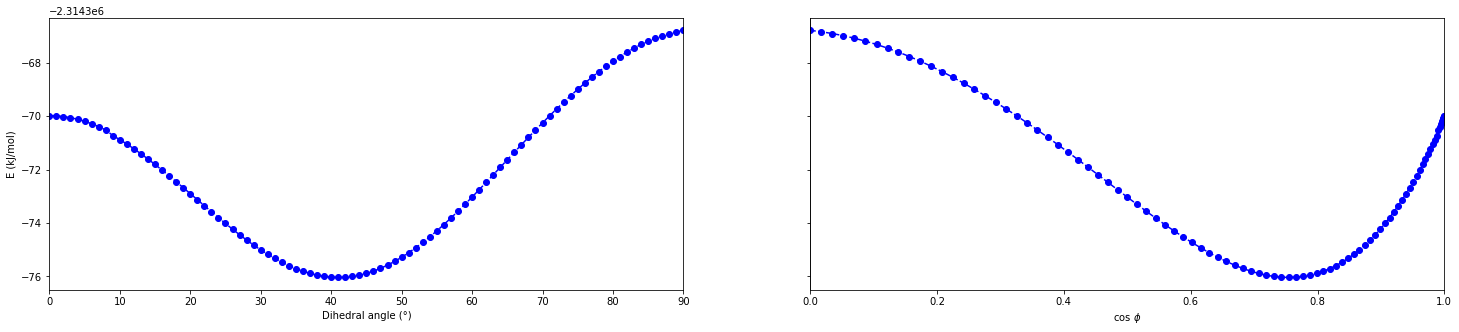

PA11_amine


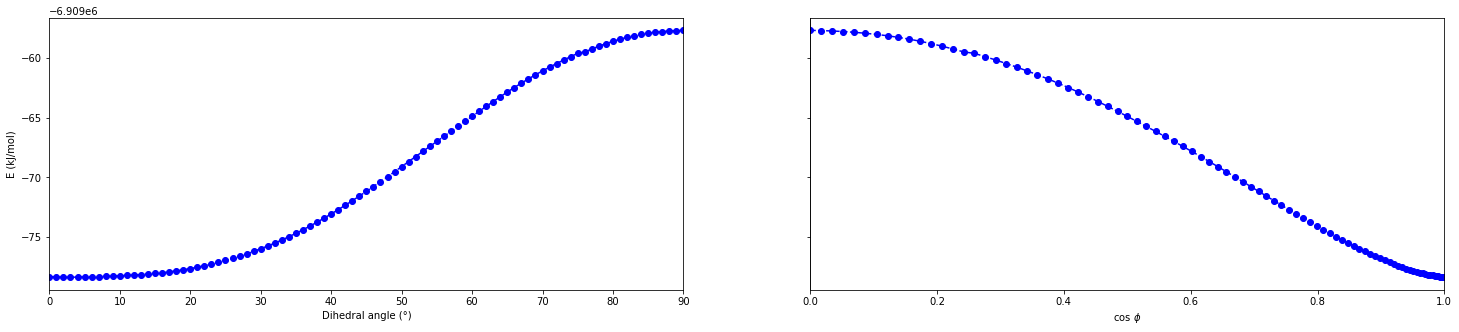

PA11_vertex


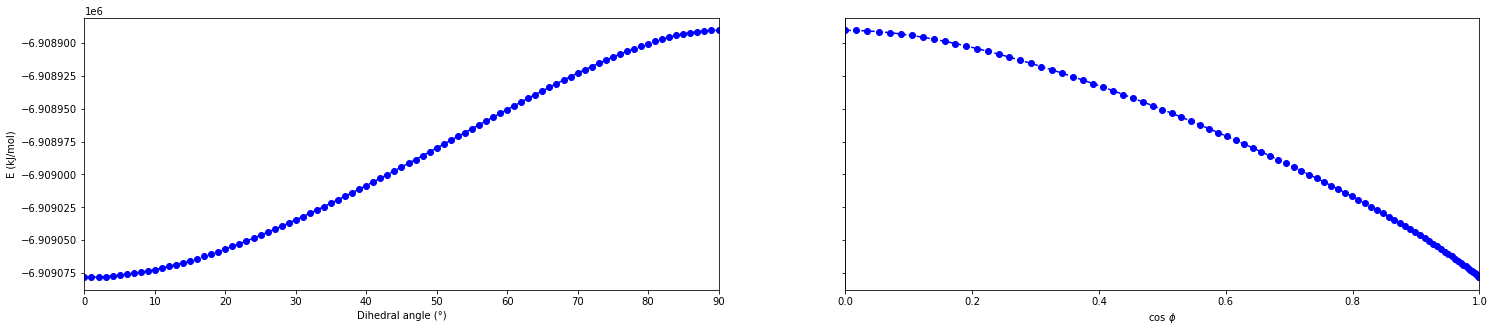

PA12_imine


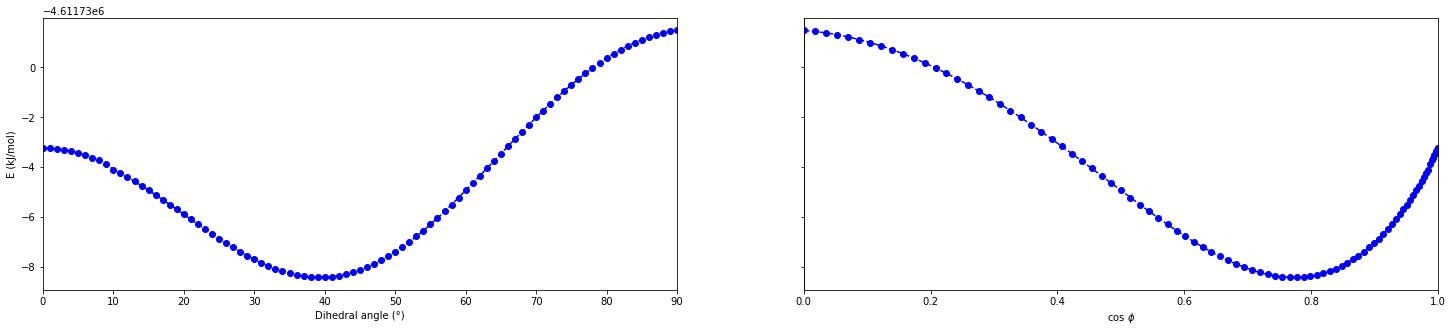

PA12_amine


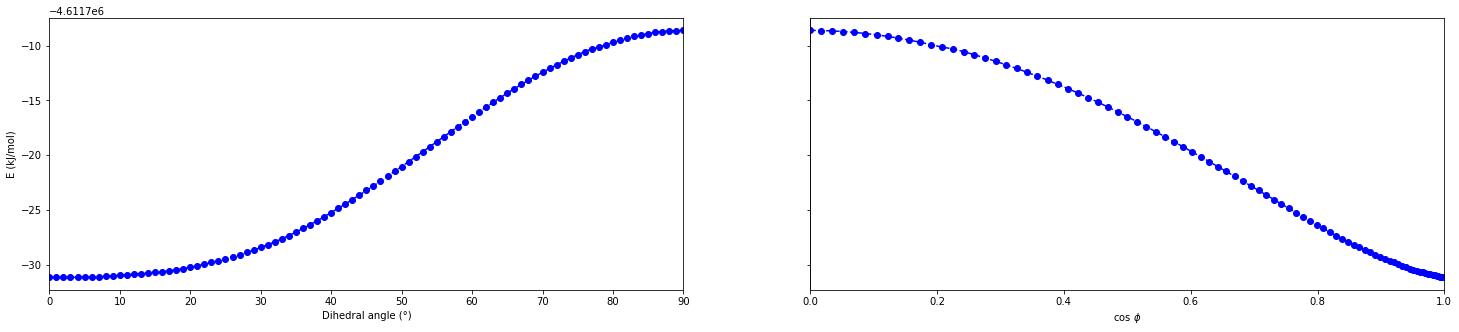

PA12_vertex


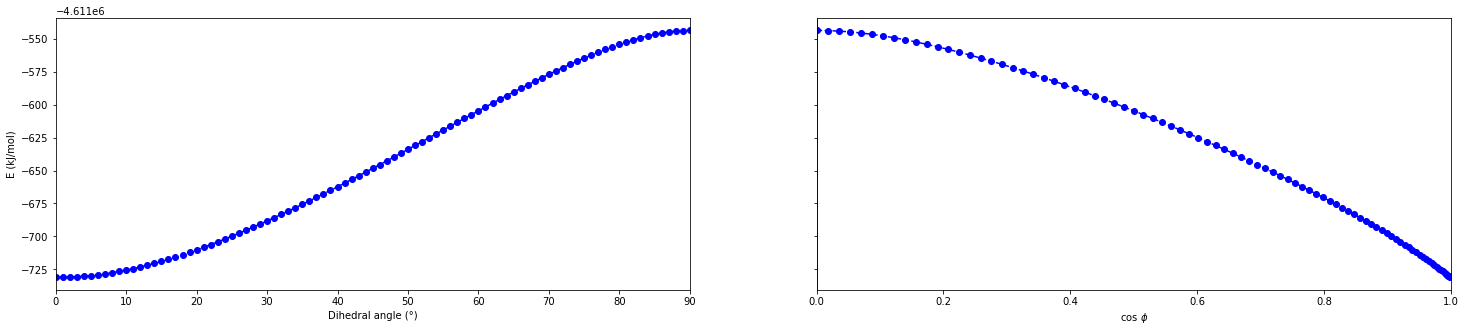

TPB_imine


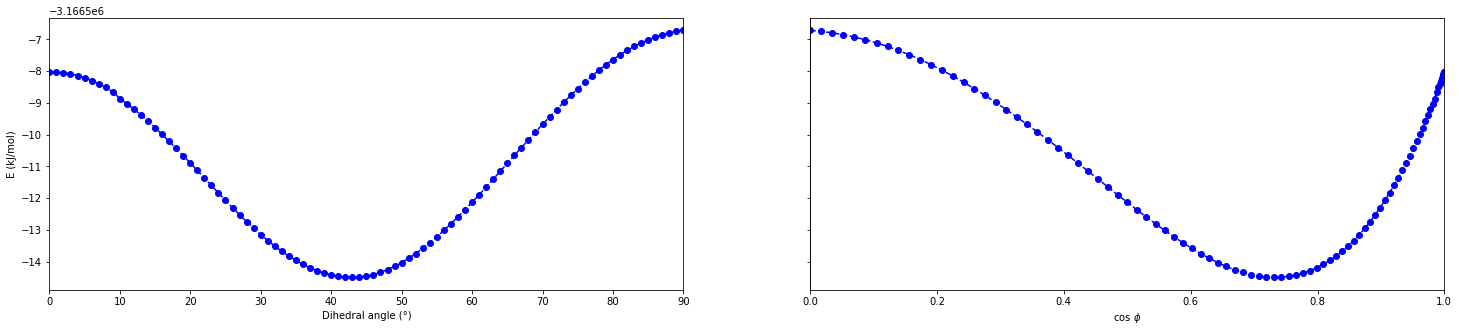

TPB_vertex


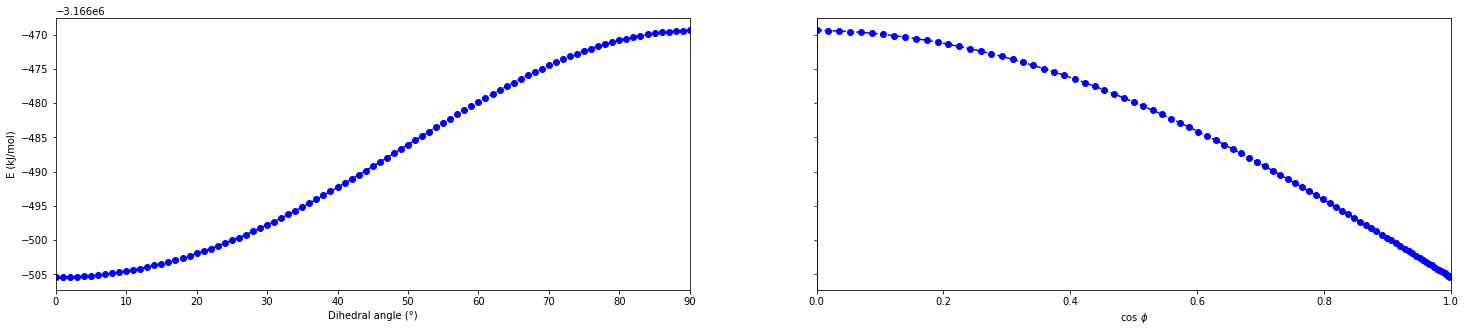

TP_amine


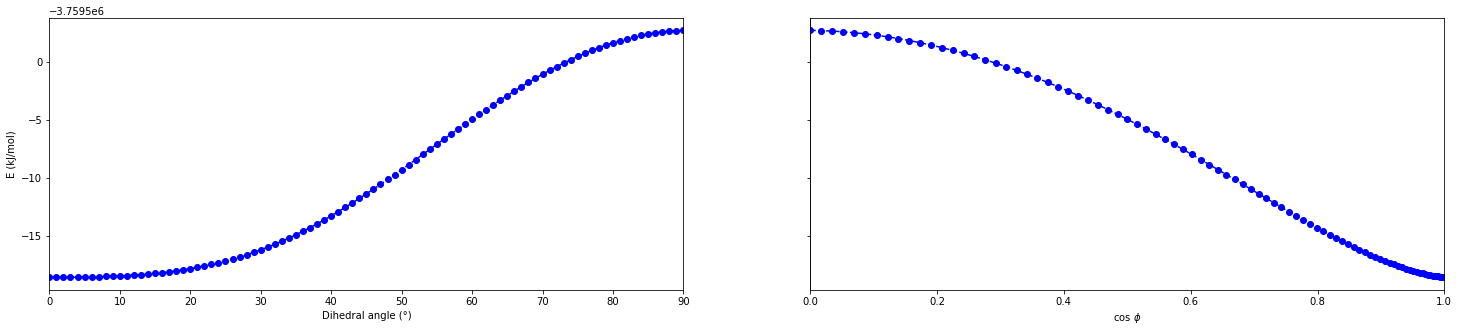

TP_vertex


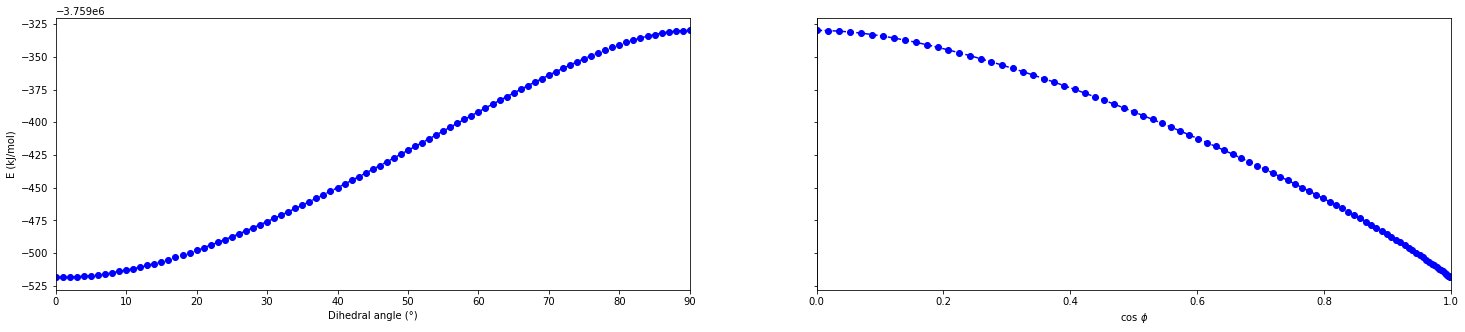

In [32]:
# Plotting
for name,aid in ai_data_rasha.items():
    try:
        plot(name,aid)
    except:
        print('Error!')

## FF barrier data calculation

### Layer stacking

In [38]:
# Perform the scans
for name,sinfo in sinfos_rasha.items():
    if 'imine' not in name:
        yaff_scan_job(sinfo.pr, 'scan_'+name+'_nodih', sinfo, sinfo.ff.ffpars_nodih)
        yaff_scan_job(sinfo.pr, 'scan_'+name+'_wdih', sinfo, sinfo.ff.ffpars)

The job scan_PA11_amine_nodih was saved and received the ID: 1095


/apps/gent/RHEL8/zen2-ib/software/pyiron/0.2.6-hpcugent-2023-intel-2020a-Python-3.8.2/lib/python3.8/site-packages/pysqa/basic.py:424: UserWarning: The command execution failed with the following message:
sbatch: error: Batch job submission failed: Socket timed out on send/recv operation

  warnings.warn("The command execution failed with the following message:\n" + e.stdout)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [37]:
# Perform the scans -- gic
for name,sinfo in sinfos_rasha.items():
    print(name)
    if not name in ['TP_vertex','PA12_vertex','PA11_vertex']: continue
    pr_sub_g16 = Project(sinfo.get_sub_project_name(name))
    structures = [pr_sub_g16.load('job_{}'.format(n)).get_structure() for n,_ in enumerate(np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step))]
    yaff_scan_structures_job(sinfo.pr, 'scan_'+name+'_nodih', sinfo, sinfo.ff.ffpars_nodih, structures)
    yaff_scan_structures_job(sinfo.pr, 'scan_'+name+'_wdih', sinfo, sinfo.ff.ffpars, structures)

PA22_imine
PA11_amine
PA11_vertex


2023-12-15 13:39:09,372 - pyiron_log - WARNING - Job aborted - please remove it and run again! scan_PA11_vertex_nodih
2023-12-15 13:39:09,551 - pyiron_log - WARNING - Job aborted - please remove it and run again! scan_PA11_vertex_wdih


PA12_imine
PA12_amine
PA12_vertex


2023-12-15 13:39:25,170 - pyiron_log - WARNING - Job aborted - please remove it and run again! scan_PA12_vertex_nodih
2023-12-15 13:39:25,348 - pyiron_log - WARNING - Job aborted - please remove it and run again! scan_PA12_vertex_wdih


TPB_imine
TPB_vertex
TP_amine
TP_vertex


2023-12-15 13:39:40,585 - pyiron_log - WARNING - Job aborted - please remove it and run again! scan_TP_vertex_nodih
2023-12-15 13:39:40,763 - pyiron_log - WARNING - Job aborted - please remove it and run again! scan_TP_vertex_wdih


In [30]:
pr_rasha.job_table(recursive=False)

id    status chemicalformula                       job  \
0   83076  finished        C20H16N2     scan_PA22_imine_nodih   
1   83077  finished        C20H16N2      scan_PA22_imine_wdih   
2   83078  finished      C48H36N6O6     scan_PA11_amine_nodih   
3   83079  finished      C48H36N6O6      scan_PA11_amine_wdih   
4   83082  finished      C34H26N4O3     scan_PA12_imine_nodih   
5   83083  finished      C34H26N4O3      scan_PA12_imine_wdih   
6   83084  finished      C34H26N4O3     scan_PA12_amine_nodih   
7   83085  finished      C34H26N4O3      scan_PA12_amine_wdih   
8   83088  finished        C27H21N3      scan_TPB_imine_nodih   
9   83089  finished        C27H21N3       scan_TPB_imine_wdih   
10  83090  finished        C27H21N3     scan_TPB_vertex_nodih   
11  83091  finished        C27H21N3      scan_TPB_vertex_wdih   
12  83092  finished      C27H21N3O3       scan_TP_amine_nodih   
13  83093  finished      C27H21N3O3        scan_TP_amine_wdih   
14  83096  finished        C20H16N2   scan_PA22_imine_polysix   
15  83097  finished      C48H36N6O6   scan_PA11_amine_polysix   
16  83098  finished      C48H36N6O6  scan_PA11_vertex_polysix   
17  83099  finished      C34H26N4O3   scan_PA12_imine_polysix   
18  83100  finished      C34H26N4O3   scan_PA12_amine_polysix   
19  83101  finished      C34H26N4O3  scan_PA12_vertex_polysix   
20  83102  finished        C27H21N3    scan_TPB_imine_polysix   
21  83103  finished        C27H21N3   scan_TPB_vertex_polysix   
22  83105  finished      C27H21N3O3    scan_TP_vertex_polysix   
23  83116  finished      C27H21N3O3     scan_TP_amine_polysix   
24  83402  finished      C48H36N6O6    scan_PA11_vertex_nodih   
25  83403  finished      C48H36N6O6     scan_PA11_vertex_wdih   
26  83404  finished      C34H26N4O3    scan_PA12_vertex_nodih   
27  83405  finished      C34H26N4O3     scan_PA12_vertex_wdih   
28  83406  finished      C27H21N3O3      scan_TP_vertex_nodih   
29  83407  finished      C27H21N3O3       scan_TP_vertex_wdih   

                       subjob  \
0      /scan_PA22_imine_nodih   
1       /scan_PA22_imine_wdih   
2      /scan_PA11_amine_nodih   
3       /scan_PA11_amine_wdih   
4      /scan_PA12_imine_nodih   
5       /scan_PA12_imine_wdih   
6      /scan_PA12_amine_nodih   
7       /scan_PA12_amine_wdih   
8       /scan_TPB_imine_nodih   
9        /scan_TPB_imine_wdih   
10     /scan_TPB_vertex_nodih   
11      /scan_TPB_vertex_wdih   
12       /scan_TP_amine_nodih   
13        /scan_TP_amine_wdih   
14   /scan_PA22_imine_polysix   
15   /scan_PA11_amine_polysix   
16  /scan_PA11_vertex_polysix   
17   /scan_PA12_imine_polysix   
18   /scan_PA12_amine_polysix   
19  /scan_PA12_vertex_polysix   
20    /scan_TPB_imine_polysix   
21   /scan_TPB_vertex_polysix   
22    /scan_TP_vertex_polysix   
23     /scan_TP_amine_polysix   
24    /scan_PA11_vertex_nodih   
25     /scan_PA11_vertex_wdih   
26    /scan_PA12_vertex_nodih   
27     /scan_PA12_vertex_wdih   
28      /scan_TP_vertex_nodih   
29       /scan_TP_vertex_wdih   

                                                       projectpath  \
0   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
1   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
2   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
3   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
4   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
5   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
6   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
7   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
8   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
9   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
10  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
11  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
12  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/

In [33]:
pr_rasha.load(83407).animate_structure(spacefill=False)

IndexError: ('Error when trying to find elements by given Job ID: ', IndexError('list index out of range'))

## FF barrier data parsing

### Functions

In [34]:
@dataclass
class FF_data:
    table_nodih: object
    table_wdih: object
    table_polysix: object

In [35]:
import pandas as pd

def get_tables_ff(name,sinfo,grid):
    nodih = sinfo.pr.load('scan_'+name+'_nodih')
    wdih = sinfo.pr.load('scan_'+name+'_wdih')
    
    if nodih is not None:
        epot_contrib_names = [contrib_name.decode("utf-8") for contrib_name in nodih['output/generic/epot_contrib_names']]
    else:
        epot_contrib_names = [contrib_name.decode("utf-8") for contrib_name in wdih['output/generic/epot_contrib_names']]
    
    if sinfo.fit_indices is not None:
        angles = get_dihedral(nodih,sinfo.fit_indices,cluster=False)/deg
    else:
        angles = get_dihedral(nodih,sinfo.indices,cluster=False)/deg
    df_nodih = pd.DataFrame(np.array([angles,*nodih['output/generic/epot_contribs'].T*electronvolt,nodih['output/generic/energy_pot']*electronvolt]).T,
                   columns=['angle', *epot_contrib_names, 'e_tot'])
    df_wdih = pd.DataFrame(np.array([angles,*wdih['output/generic/epot_contribs'].T*electronvolt,wdih['output/generic/energy_pot']*electronvolt]).T,
                   columns=['angle', *epot_contrib_names, 'e_tot'])

    # Get the dataframe
    return df_nodih, df_wdih

def get_table_polysix(name,sinfo,grid):
    polysix = sinfo.pr.load('scan_'+name+'_polysix')
    if sinfo.fit_indices is not None:
        angles = get_dihedral(polysix,sinfo.fit_indices,cluster=False)/deg
    else:
        angles = get_dihedral(polysix,sinfo.indices,cluster=False)/deg
    return pd.DataFrame(np.array([angles,polysix['output/generic/energy_pot']*electronvolt]).T,
                   columns=['angle', 'e_tot'])

def centre(arr):
    return (arr-np.nanmin(arr))

# Plotting and fitting function
def fit_and_plot_ff(name,sinfo,aid,ffd,save_png=False):
    from scipy import optimize

    print(name)
    odd = True # will select correct poly function
    
    vdw_names = ['pair_mm3','pair_lj','pair_mm3cap']
    if len(ffd.table_nodih)>0:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_nodih.columns)]
    else:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_wdih.columns)]
    assert len(vdw_name)==1
    vdw_name = vdw_name[0]
    
    
    # FF data
    if len(ffd.table_nodih)>0:
        angles       = ffd.table_nodih.sort_values(by=['angle']).angle
        FF_val_nodih = ffd.table_nodih.sort_values(by=['angle']).valence/kjmol
        FF_ei_nodih  = ffd.table_nodih.sort_values(by=['angle']).pair_ei/kjmol
        FF_vdw_nodih = ffd.table_nodih.sort_values(by=['angle'])[vdw_name]/kjmol
        FF_tot_nodih = ffd.table_nodih.sort_values(by=['angle']).e_tot/kjmol
        
    else:
        angles       = ffd.table_wdih.sort_values(by=['angle']).angle
    
    FF_val_wdih = ffd.table_wdih.sort_values(by=['angle']).valence/kjmol
    FF_ei_wdih  = ffd.table_wdih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_wdih = ffd.table_wdih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_wdih = ffd.table_wdih.sort_values(by=['angle']).e_tot/kjmol
    
    # AI data
    if aid is not None:
        ai_angles   = aid.sort_values(by=['angle']).angle
        ai_energy   = aid.sort_values(by=['angle']).E/kjmol
        try:
            assert np.all(np.isclose(np.asarray(ai_angles),np.asarray(angles),atol=1e-3))
        except AssertionError:
            print(np.asarray(ai_angles),np.asarray(angles))
            raise AssertionError
    
    
    # If angle range is limited to 90 degrees mirror the behaviour to 180
    def mirror(array, angle=False):
        if angle:
            return np.hstack((array, 180-array[:-1][::-1]))
        else:
            return np.hstack((array, array[:-1][::-1]))
        
    if np.isclose(np.max(angles),90,atol=1e-3):
        print('Mirroring')
        odd = False
        angles       = mirror(angles,angle=True)
        if len(ffd.table_nodih)>0:
            FF_val_nodih = mirror(FF_val_nodih)
            FF_ei_nodih  = mirror(FF_ei_nodih)
            FF_vdw_nodih = mirror(FF_vdw_nodih)
            FF_tot_nodih = mirror(FF_tot_nodih)
        
        FF_val_wdih = mirror(FF_val_wdih)
        FF_ei_wdih  = mirror(FF_ei_wdih)
        FF_vdw_wdih = mirror(FF_vdw_wdih)
        FF_tot_wdih = mirror(FF_tot_wdih)
        
        if aid is not None:
            ai_energy   = mirror(ai_energy)
    else:
        angles      = np.asarray(angles)
        
        if len(ffd.table_nodih)>0:
            FF_val_nodih = np.asarray(FF_val_nodih)
            FF_ei_nodih  = np.asarray(FF_ei_nodih)
            FF_vdw_nodih = np.asarray(FF_vdw_nodih)
            FF_tot_nodih = np.asarray(FF_tot_nodih)
        
        FF_val_wdih = np.asarray(FF_val_wdih)
        FF_ei_wdih  = np.asarray(FF_ei_wdih)
        FF_vdw_wdih = np.asarray(FF_vdw_wdih)
        FF_tot_wdih = np.asarray(FF_tot_wdih)
        
        if aid is not None:
            ai_energy   = np.asarray(ai_energy)
        
    def get_poly(odd):
        # Fit functions
        def poly(x,b,d,f,g):
            return g + b*x**2 + d*x**4 + f*x**6

        def poly_odd(x,a,b,c,d,e,f,g):
            return g + a*x + b*x**2 + c*x**3 + d*x**4 + e*x**5 + f*x**6
        
        if odd:
            return poly_odd
        else:
            return poly
        
    fpoly = get_poly(odd)
    
    if aid is not None:
        # Calculate difference and fit a polysix term to the difference, focussing on the minimum
        diff = centre(ai_energy - FF_tot_nodih)

        cosr = np.cos(np.deg2rad(angles)) # range as cos(x)
        fitr = cosr[~np.isnan(diff)]
        fitf = diff[~np.isnan(diff)]

        sigma=np.ones(len(fitf))
        
        #if name=='35_03_04_tetratopic':
        #    sigma[fitr>0.9]=1e-1
            
        
        #sigma[np.argmin(fitf)] = 1e-4 # force minimum position
        #sigma[centre(ai_energy)<20*kjmol] = 1e-4
        p,pcov = optimize.curve_fit(fpoly, fitr, fitf, sigma=sigma)
        print(p)


        # Plot FF and AI data and compare with fit
        fig,ax = pt.subplots(3,2,sharex=False,sharey=True,figsize=(25,10))
        ax[0,0].plot(angles,centre(FF_val_nodih), label='valence')
        ax[0,0].plot(angles,centre(FF_ei_nodih), label='ei')
        ax[0,0].plot(angles,centre(FF_vdw_nodih), label='vdw')
        ax[0,0].plot(angles,centre(FF_tot_nodih), ls='--', label='tot')
        ax[0,0].plot(angles,centre(ai_energy), label='AI')
        ax[0,0].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[0,0].set_ylabel('E (kJ/mol)')
        ax[0,0].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[0,0].set_title('Energy barrier wo dihedral term')

        ax[0,1].plot(angles,centre(FF_val_wdih), label='valence')
        ax[0,1].plot(angles,centre(FF_ei_wdih), label='ei')
        ax[0,1].plot(angles,centre(FF_vdw_wdih), label='vdw')
        ax[0,1].plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
        ax[0,1].plot(angles,centre(ai_energy), label='AI')
        ax[0,1].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[0,1].set_ylabel('E (kJ/mol)')
        ax[0,1].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[0,1].set_title('Energy barrier w dihedral term')

        ax[1,0].plot(angles,diff, c='r', label='diff')
        ax[1,0].plot(angles,fpoly(cosr,*p), 'k--', label='fit')
        ax[1,0].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[1,0].set_ylabel('E (kJ/mol)')
        ax[1,0].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[1,0].set_title('Fit (wrt diff)')

        ax[1,1].plot(angles,centre(ai_energy), label='AI', c='r')
        ax[1,1].plot(angles,centre(fpoly(cosr,*p) + FF_tot_nodih), 'k--',label='fit')
        ax[1,1].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[1,1].set_ylabel('E (kJ/mol)')
        ax[1,1].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[1,1].set_title('Fit (wrt AI barrier)')
        
     
        ax[2,0].plot(cosr,diff, c='r', label='diff')
        ax[2,0].plot(cosr,fpoly(cosr,*p), 'k--', label='fit')
        ax[2,0].set_xlabel(r'$\cos \psi$')
        ax[2,0].set_ylabel('E (kJ/mol)')
        ax[2,0].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[2,0].set_title('Fit (wrt diff)')

        ax[2,1].plot(cosr,centre(ai_energy), label='AI', c='r')
        ax[2,1].plot(cosr,centre(fpoly(cosr,*p) + FF_tot_nodih), 'k--',label='fit')
        ax[2,1].set_xlabel(r'$\cos \psi$ ($^\circ$)')
        ax[2,1].set_ylabel('E (kJ/mol)')
        ax[2,1].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[2,1].set_title('Fit (wrt AI barrier)')
      
        
    else:
        # Plot FF and AI data and compare with fit
        if len(ffd.table_nodih)>0:
            fig,ax = pt.subplots(1,2,sharex=True,sharey=True,figsize=(30,10))
            ax[0].plot(angles,centre(FF_val_nodih), label='valence')
            ax[0].plot(angles,centre(FF_ei_nodih), label='ei')
            ax[0].plot(angles,centre(FF_vdw_nodih), label='vdw')
            ax[0].plot(angles,centre(FF_tot_nodih), ls='--', label='tot')
            ax[0].set_xlabel(r'$\psi$ ($^\circ$)')
            ax[0].set_ylabel('E (kJ/mol)')
            ax[0].legend(bbox_to_anchor=(1.0,.5), loc=6)
            ax[0].set_title('Energy barrier wo dihedral term')

            ax[1].plot(angles,centre(FF_val_wdih), label='valence')
            ax[1].plot(angles,centre(FF_ei_wdih), label='ei')
            ax[1].plot(angles,centre(FF_vdw_wdih), label='vdw')
            ax[1].plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
            ax[1].set_xlabel(r'$\psi$ ($^\circ$)')
            ax[1].set_ylabel('E (kJ/mol)')
            ax[1].legend(bbox_to_anchor=(1.0,.5), loc=6)
            ax[1].set_title('Energy barrier w dihedral term')
        else:
            fig,ax = pt.subplots(1,1,sharex=True,sharey=True,figsize=(30,10))
            ax.plot(angles,centre(FF_val_wdih), label='valence')
            ax.plot(angles,centre(FF_ei_wdih), label='ei')
            ax.plot(angles,centre(FF_vdw_wdih), label='vdw')
            ax.plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
            ax.set_xlabel(r'$\psi$ ($^\circ$)')
            ax.set_ylabel('E (kJ/mol)')
            ax.legend(bbox_to_anchor=(1.0,.5), loc=6)
            ax.set_title('Energy barrier w dihedral term')

    
    if save_png:
        path = sinfo.pr.root_path +  sinfo.pr.project_path.split('/')[0] + '/input_files/' + '/'.join(sinfo.pr.project_path.split('/')[1:]) + sinfo.ff.block_name + '/fits/'
        pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
        pt.savefig(path+'{}.pdf'.format(name),bbox_inches='tight')
    
    pt.show()
    
    if aid is not None:
        return p

### Layer stacking

In [36]:
# Gather data
ff_rasha_datas = {}

# table_polysix will be calculated in 6: Testing polysix terms 
for name,sinfo in sinfos_rasha.items():
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    ff_rasha_datas[name] = FF_data(*get_tables_ff(name,sinfo,grid),None)

2023-12-15 13:32:27,326 - pyiron_log - WARNING - Job 'scan_PA22_imine_nodih' does not exist and cannot be loaded
2023-12-15 13:32:27,327 - pyiron_log - WARNING - Job 'scan_PA22_imine_wdih' does not exist and cannot be loaded


TypeError: 'NoneType' object is not subscriptable

PA22_imine
Mirroring
[-38.36676202  21.0049809   -4.25414574  21.61028738]


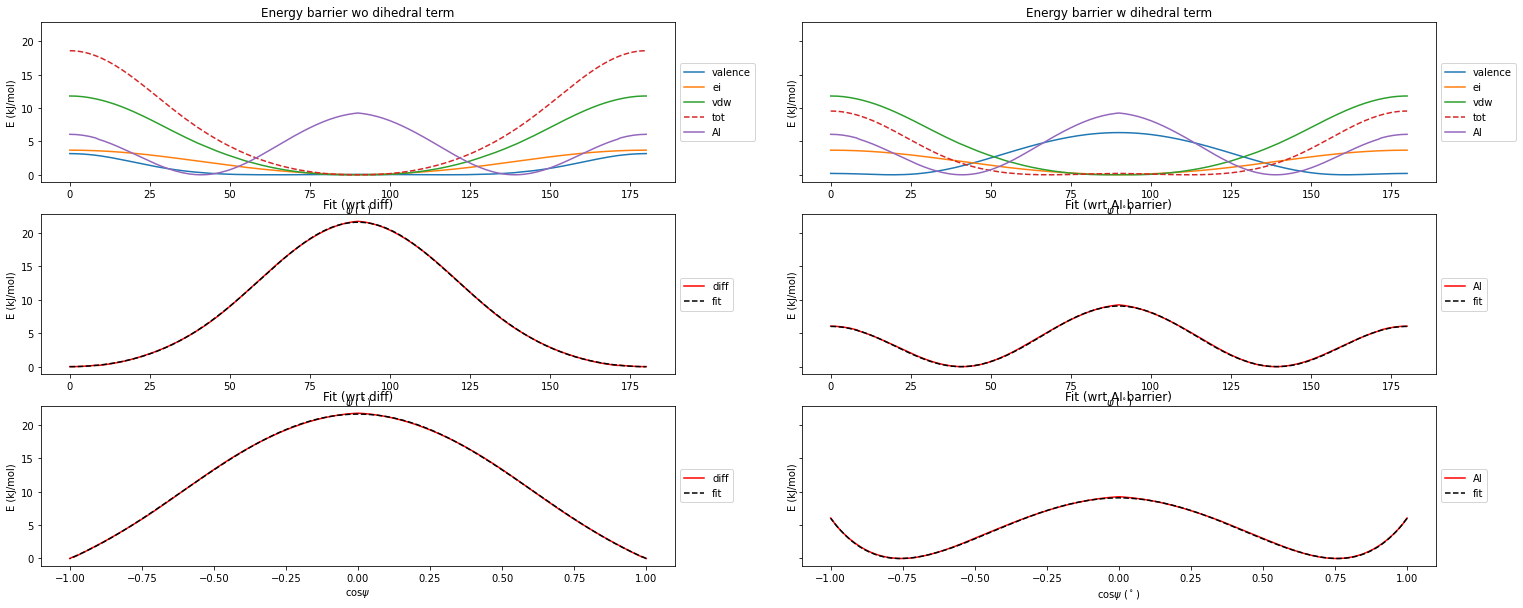

PA11_amine
Mirroring
[-36.34984887  -2.86868902   0.09248262  39.20723409]


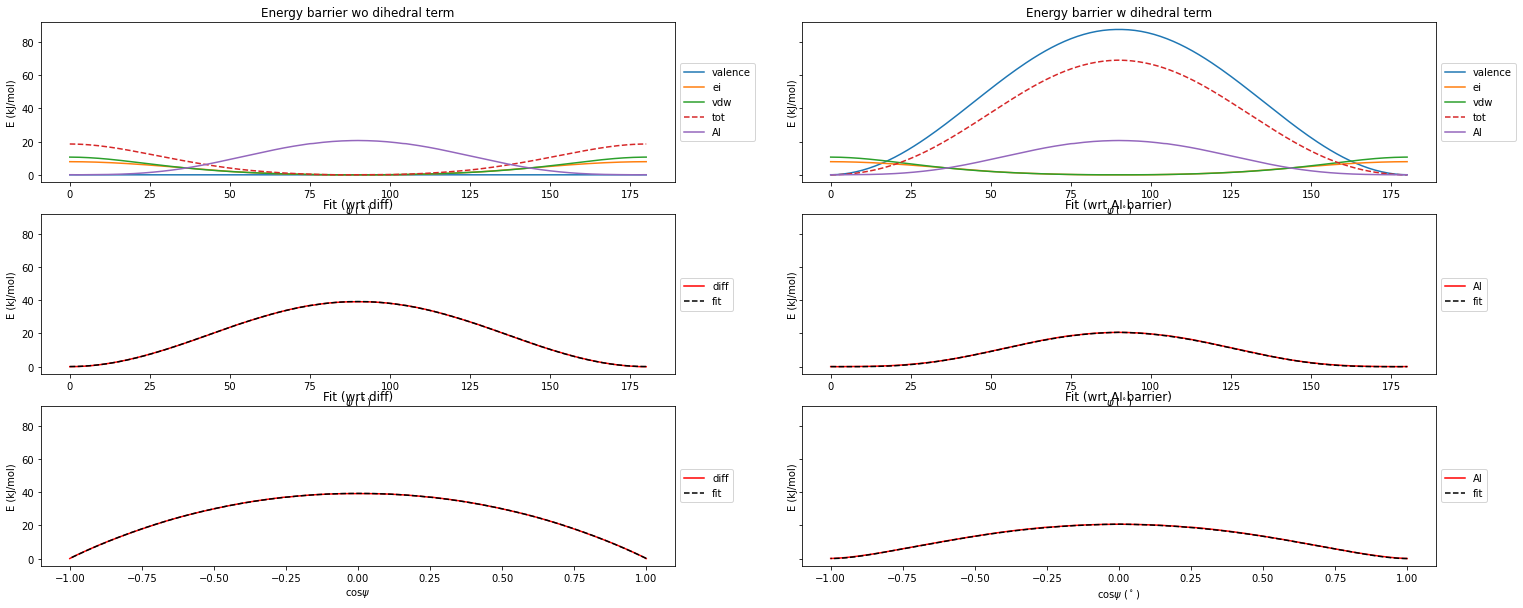

PA11_vertex
Mirroring
[-272.11016998  231.48980437 -159.4622921   200.80575471]


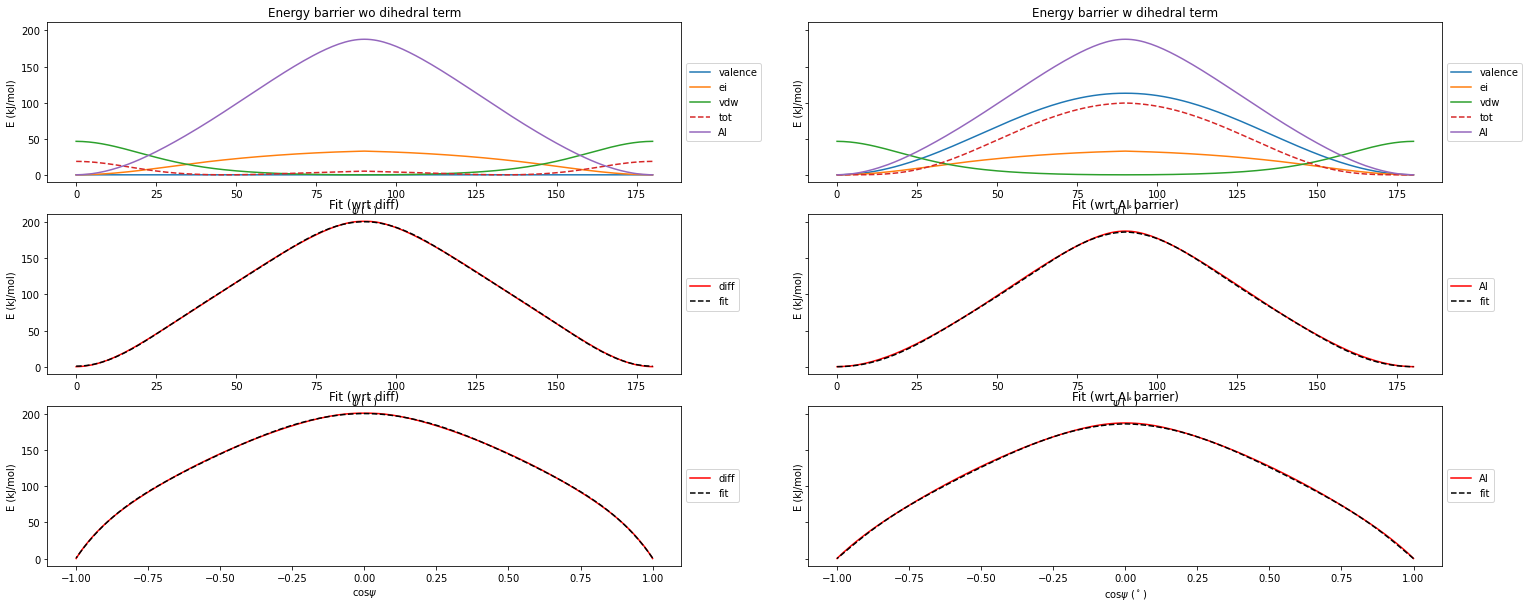

PA12_imine
Mirroring
[-40.75836392  19.69834256  -4.00428007  25.04411787]


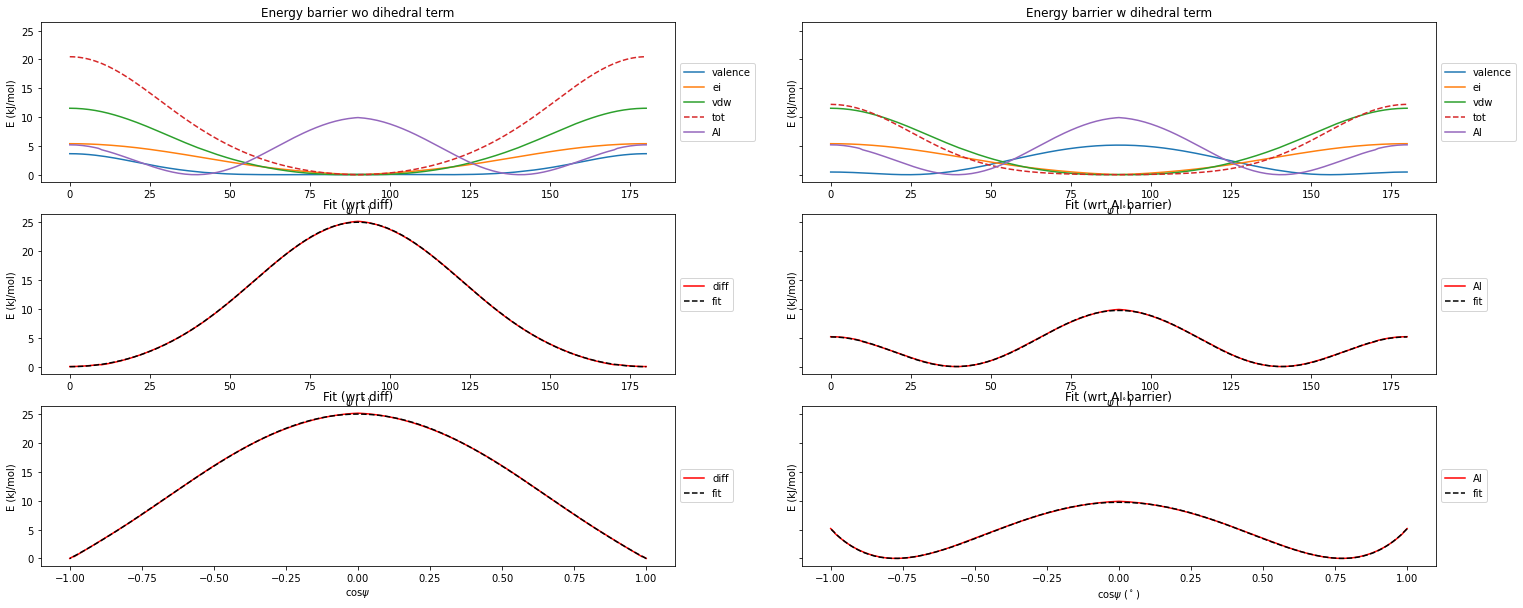

PA12_amine
Mirroring
[-37.59517779   4.85995942  -3.08217666  35.86273318]


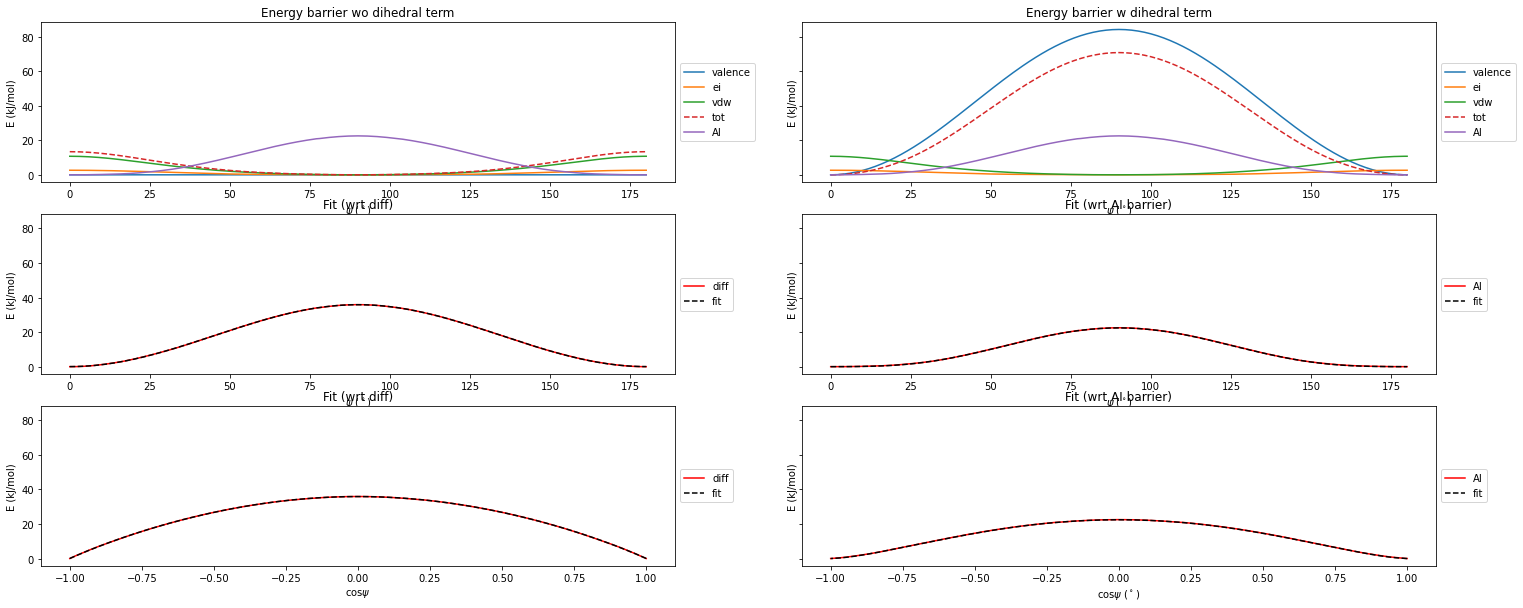

PA12_vertex
Mirroring
[-276.57867277  242.06355106 -162.56308648  197.44374408]


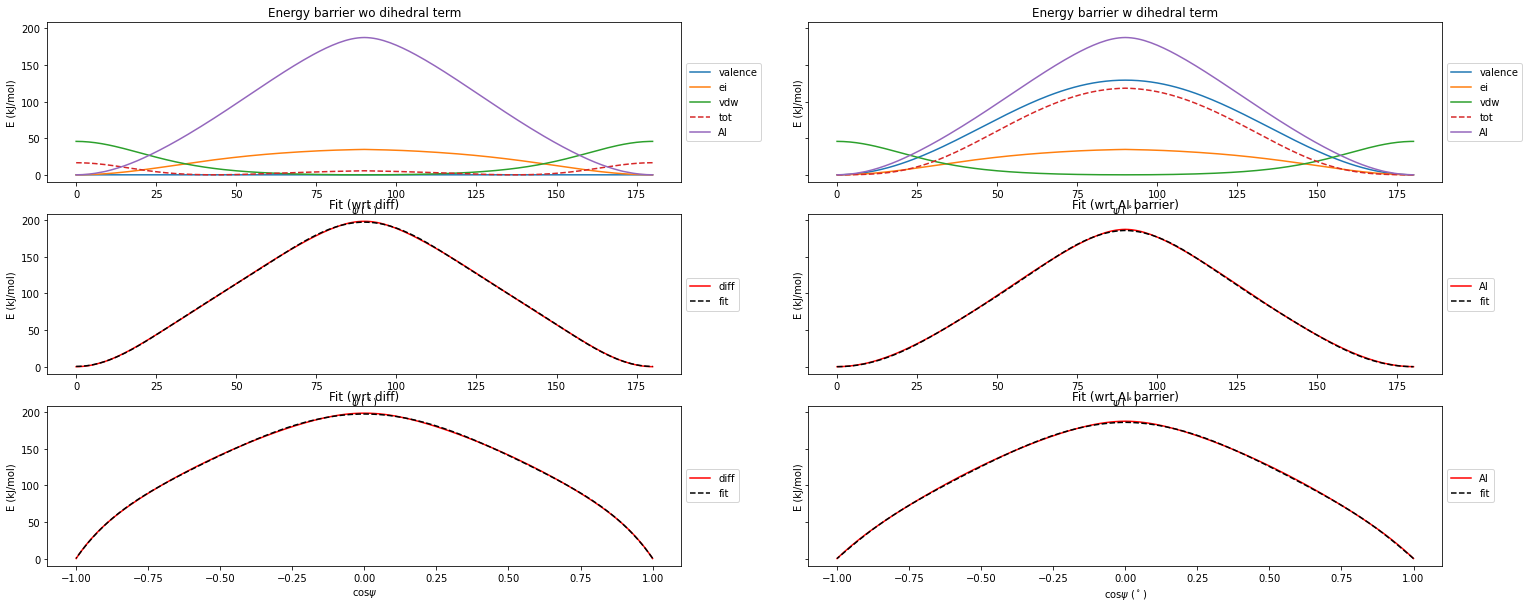

TPB_imine
Mirroring
[-30.15409053  12.40480742  -2.11284484  19.85029074]


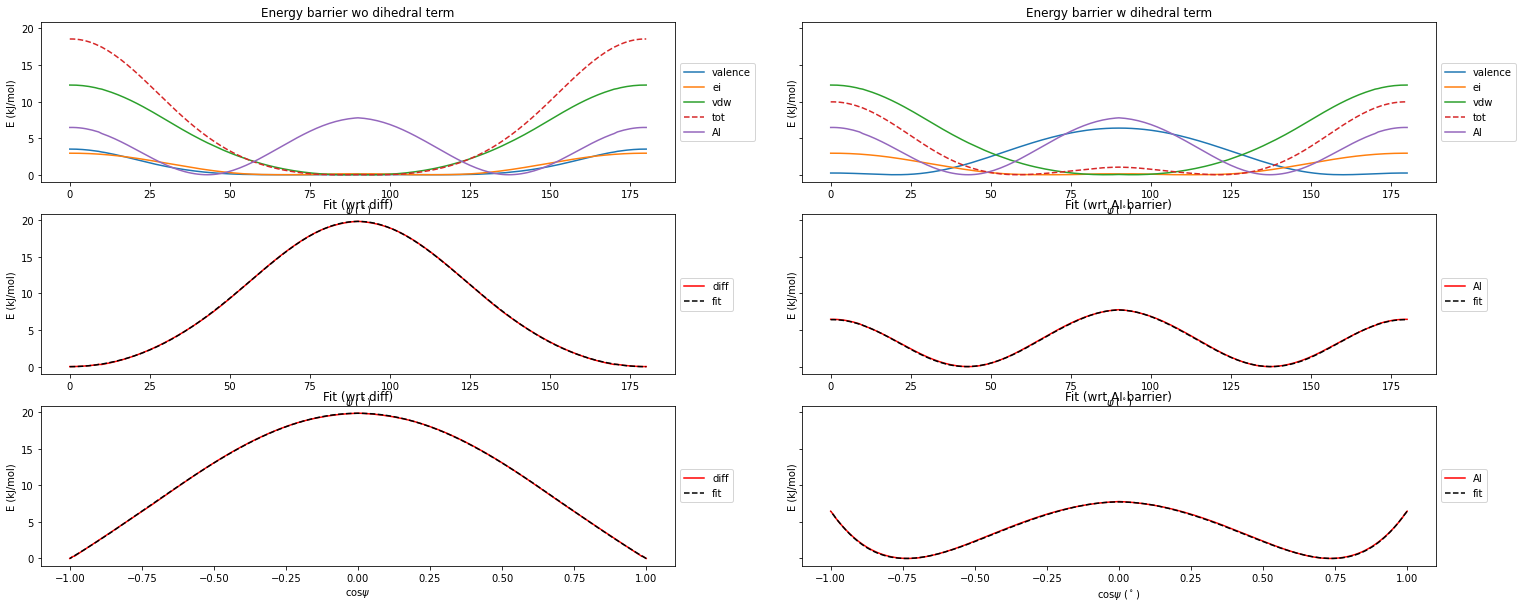

TPB_vertex
Mirroring
[-44.59085286   8.85729398  -3.57840549  39.31894735]


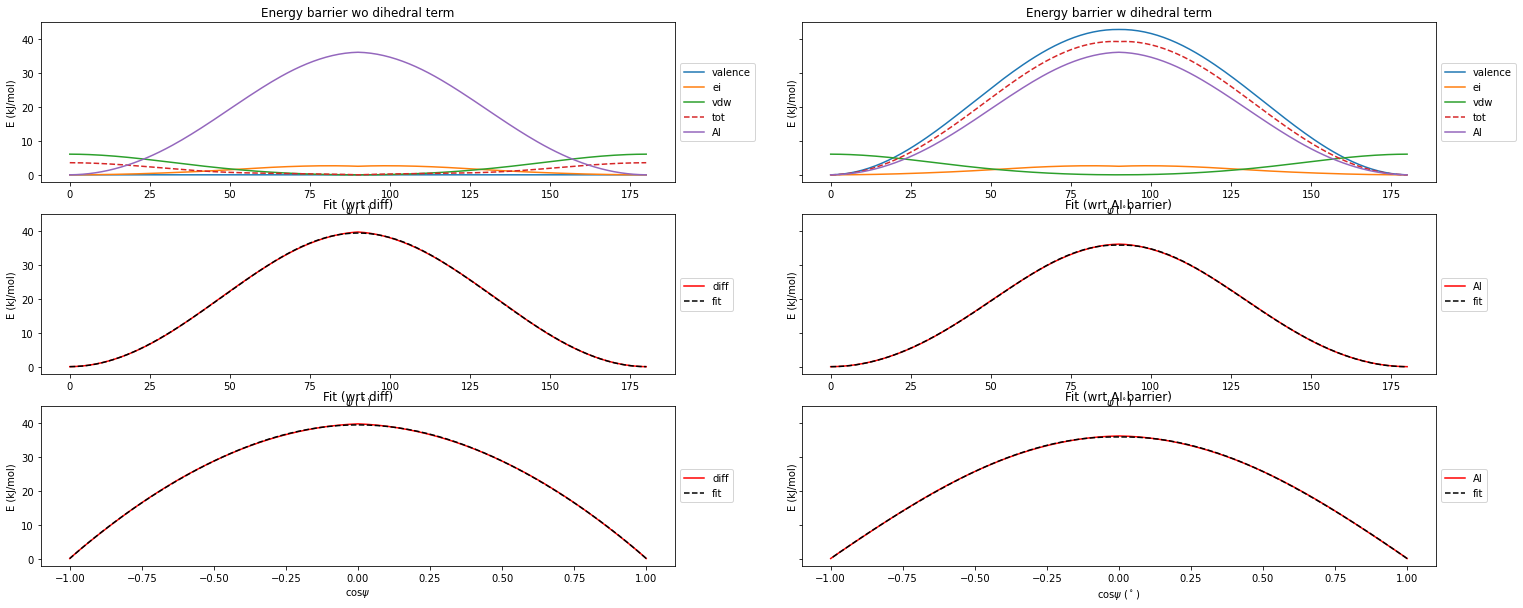

TP_amine
Mirroring
[ 0.00542966 -0.00508857 -0.00034728  0.05761082]


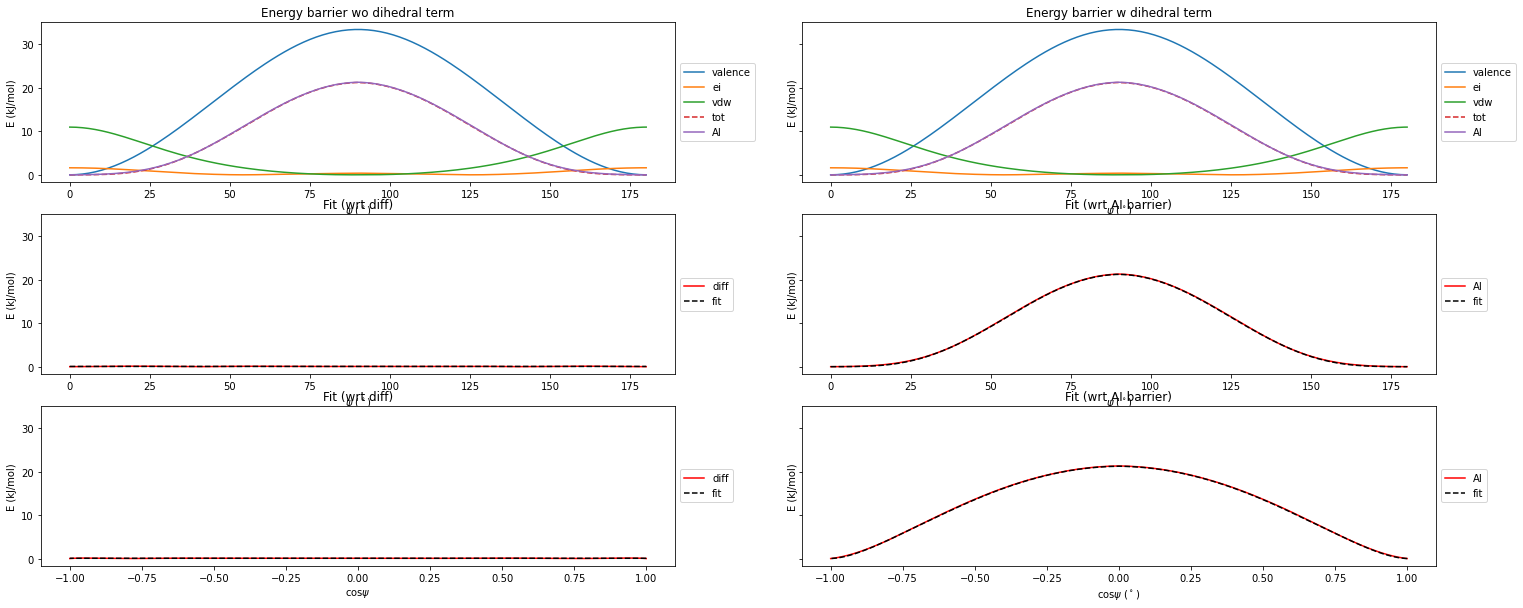

TP_vertex
Mirroring
[-285.97163522  254.33694307 -167.17593485  199.04380651]


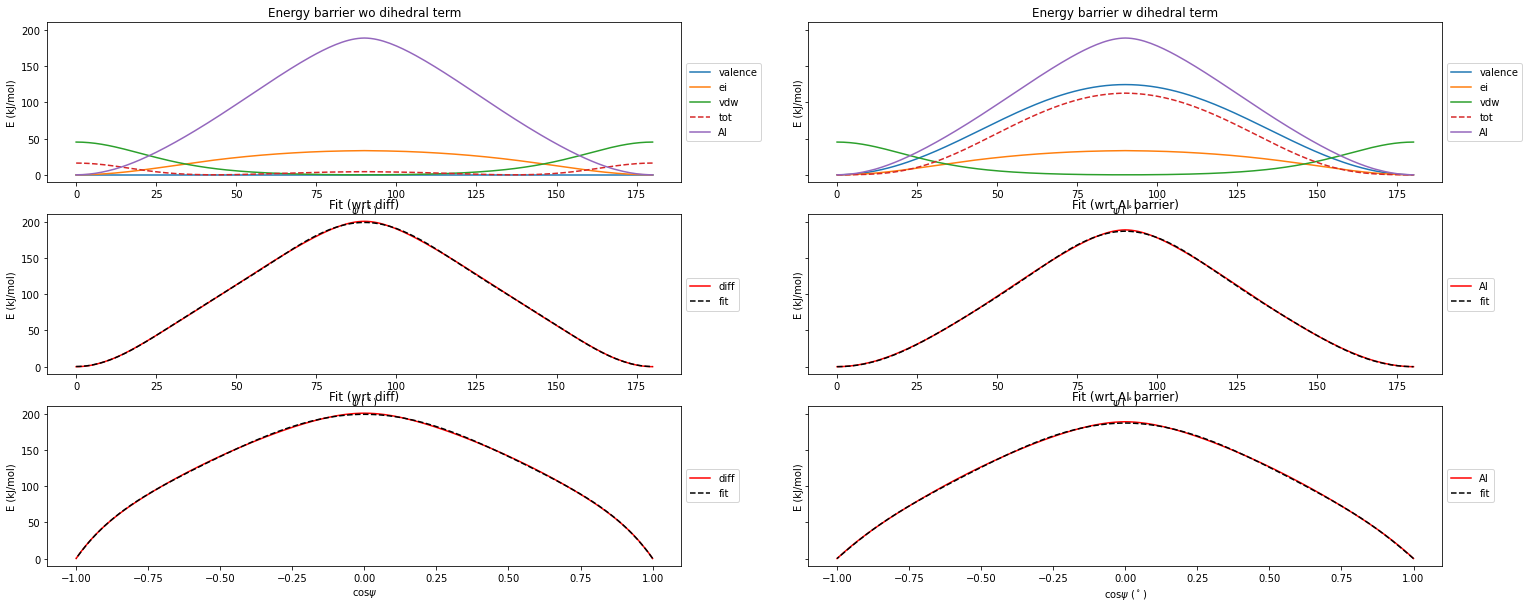

In [37]:
# Fitting and Plotting
ps_rasha = {}
for name,ffd in ff_rasha_datas.items():
    ps_rasha[name] = fit_and_plot_ff(name,sinfos_rasha[name],ai_data_rasha[name],ffd,save_png=True)

## Generating polysix parameterfile

### Functions

In [40]:
import pathlib

def write_ffpars_polysix(sinfo,fit_params,name=None,subname=None,strict_indices=False,ref_val=0,override_degeneracy=None):    
    # Make yaff system and adapt it to angle 0
    adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,ref_val)
    yaff_system = System(sinfo.ff.structure.numbers, adapted_structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)
    
    # Log all dihedrals
    dihs = []
    dihs_ids = []
    dihs_cos = []
    for dih in yaff_system.iter_dihedrals():
        dihs.append(dih)
        dihs_ids.append([yaff_system.ffatypes[yaff_system.ffatype_ids[i]] for i in dih])
        dihs_cos.append(DihedCos(*dih))

    # Filter out the appropriate ones
    if sinfo.fit_indices is not None:
        dihedral_idx = sinfo.fit_indices
    else:
        dihedral_idx = sinfo.indices
    cv_dih = []
    cv_dihcos = []
    for n,dih in enumerate(dihs):
        if (dih[1]==dihedral_idx[1] and dih[2]==dihedral_idx[2]) or (dih[1]==dihedral_idx[2] and dih[2]==dihedral_idx[1]):
            if not strict_indices or (strict_indices and (dih == dihedral_idx or dih[::-1] == dihedral_idx)):
                if dihs_ids[n] not in cv_dih and dihs_ids[n][::-1] not in cv_dih:
                    cv_dih.append(dihs_ids[n])
                    cv_dihcos.append(dihs_cos[n])
    
    # Evaluate these dihedrals
    ICl = InternalCoordinateList(DeltaList(yaff_system))
    for dih in cv_dihcos:
        ICl.add_ic(dih)
    ICl.dlist.forward()
    ICl.forward()
    

    values = [int(np.round(c.get_last_computed_value())) for c in cv_dihcos]

    powers = [[c**m for m in [1,2,3,4,5,6]] for c in values] # to get the sign right of odd and even powers
    w = max([len(n) for dih in cv_dih for n in dih]) # to get nice alligned parameter files
    
    # Evaluate fit params to 6
    fit_params = fit_params[:-1] # do not account for constant term
    if not len(fit_params)==6:
        fit_params=[0,fit_params[0],0,fit_params[1],0,fit_params[2]]
        
    ffpars_polysix = ''
    ffpars_polysix += '''# TORSCPOLYSIX
#---------
TORSCPOLYSIX:UNIT  C1 kjmol
TORSCPOLYSIX:UNIT  C2 kjmol
TORSCPOLYSIX:UNIT  C3 kjmol
TORSCPOLYSIX:UNIT  C4 kjmol
TORSCPOLYSIX:UNIT  C5 kjmol
TORSCPOLYSIX:UNIT  C6 kjmol

'''
    for n,dih in enumerate(cv_dih):
        if override_degeneracy is not None:
            tmp = np.array(fit_params)/override_degeneracy
        else:
            tmp = np.array(fit_params)/sinfo.degeneracy
        power = powers[n]
        v = [power[m]*tmp[m] for m in range(len(power))]
        ffpars_polysix += 'TORSCPOLYSIX:PARS  '
        ffpars_polysix += "{:>{w}}  {:>{w}}  {:>{w}}  {:>{w}}  {: 1.10e}  {: 1.10e}  {: 1.10e}  {: 1.10e}  {: 1.10e}  {: 1.10e}\n".format(dih[0],dih[1],dih[2],dih[3],v[0],v[1],v[2],v[3],v[4],v[5],w=w)
    
    
    
    path = sinfo.pr.root_path +  sinfo.pr.project_path.split('/')[0] + '/input_files/' + '/'.join(sinfo.pr.project_path.split('/')[1:]) + sinfo.ff.block_name + '/polysix/' 
    path = path + '{}/'.format(name) if name is not None else path
    pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
    
    polysix_path = path+'pars_polysix.txt' if subname is None else path+'pars_polysix_{}.txt'.format(subname)
    
    with open(polysix_path, 'w') as f:
        f.write(ffpars_polysix)
    
    # Adapt polysix parameters in sinfo
    sinfo.ff.ffpars_polysix = ffpars_polysix


### Layer stacking

In [54]:
for key,val in sinfo_rasha_groups.items():
    # Group polysix parameter files per group
    print('{}: {}'.format(key,','.join(list(val.keys()))))
    names = [k for k in val.keys()]
    sinfos = [val[k] for k in val.keys()]

    for n,sinfo in enumerate(sinfos):
        print(names[n].split('_')[-1])
        if key=='TP' and names[n].split('_')[-1]=='amine': 
            continue
        write_ffpars_polysix(sinfo,ps_rasha[names[n]],name=None,subname=names[n].split('_')[-1])


PA11: PA11_amine,PA11_vertex
amine
vertex
TP: TP_amine,TP_vertex
amine
vertex
TPB: TPB_imine,TPB_vertex
imine
vertex
PA12: PA12_imine,PA12_amine,PA12_vertex
imine
amine
vertex
PA22: PA22_imine
imine


## Testing polysix terms

### Functions

In [43]:
# Plotting and fitting function
def plot_ff_polysix(name,aid,ffd):
    print(name)
    
    vdw_names = ['pair_mm3','pair_lj','pair_mm3cap']
    vdw_name = [name for name in vdw_names if name in list(ffd.table_nodih.columns)]
    assert len(vdw_name)==1
    vdw_name = vdw_name[0]
    
    # FF data
    angles       = ffd.table_nodih.sort_values(by=['angle']).angle
    FF_val_nodih = ffd.table_nodih.sort_values(by=['angle']).valence/kjmol
    FF_ei_nodih  = ffd.table_nodih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_nodih = ffd.table_nodih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_nodih = ffd.table_nodih.sort_values(by=['angle']).e_tot/kjmol
    
    FF_val_wdih = ffd.table_wdih.sort_values(by=['angle']).valence/kjmol
    FF_ei_wdih  = ffd.table_wdih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_wdih = ffd.table_wdih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_wdih = ffd.table_wdih.sort_values(by=['angle']).e_tot/kjmol
    
    poly_angles  = ffd.table_polysix.sort_values(by=['angle']).angle
    FF_poly      = ffd.table_polysix.sort_values(by=['angle']).e_tot/kjmol
    
    # AI data
    ai_angles   = aid.sort_values(by=['angle']).angle
    ai_energy   = aid.sort_values(by=['angle']).E/kjmol
    
    try:
        assert np.all(np.isclose(np.asarray(ai_angles),np.asarray(angles)))
        assert np.all(np.isclose(np.asarray(poly_angles),np.asarray(angles), atol=1e-3))
    except AssertionError:
        print(np.asarray(ai_angles)-np.asarray(angles))
        print(np.asarray(poly_angles)-np.asarray(angles))
        raise AssertionError

    
    # If angle range is limited to 90 degrees mirror the behaviour to 180
    def mirror(array, angle=False):
        if angle:
            return np.hstack((array, 180-array[:-1][::-1]))
        else:
            return np.hstack((array, array[:-1][::-1]))
        
    if np.isclose(np.max(angles),90,atol=1e-3):
        print('Mirroring')
        angles       = mirror(angles,angle=True)
        FF_val_nodih = mirror(FF_val_nodih)
        FF_ei_nodih  = mirror(FF_ei_nodih)
        FF_vdw_nodih = mirror(FF_vdw_nodih)
        FF_tot_nodih = mirror(FF_tot_nodih)
        
        FF_val_wdih = mirror(FF_val_wdih)
        FF_ei_wdih  = mirror(FF_ei_wdih)
        FF_vdw_wdih = mirror(FF_vdw_wdih)
        FF_tot_wdih = mirror(FF_tot_wdih)
        
        FF_poly   = mirror(FF_poly)
        ai_energy = mirror(ai_energy)
    else:
        angles       = np.asarray(angles)
        FF_val_nodih = np.asarray(FF_val_nodih)
        FF_ei_nodih  = np.asarray(FF_ei_nodih)
        FF_vdw_nodih = np.asarray(FF_vdw_nodih)
        FF_tot_nodih = np.asarray(FF_tot_nodih)
        
        FF_val_wdih = np.asarray(FF_val_wdih)
        FF_ei_wdih  = np.asarray(FF_ei_wdih)
        FF_vdw_wdih = np.asarray(FF_vdw_wdih)
        FF_tot_wdih = np.asarray(FF_tot_wdih)
        
        FF_poly   = np.asarray(FF_poly)
        ai_energy = np.asarray(ai_energy)
        
    
    # Plot FF and AI data and compare with fit
    fig,ax = pt.subplots(1,2,sharex=True,sharey=True,figsize=(25,10))
    ax[0].plot(angles,centre(FF_tot_nodih+FF_poly), label='tot_new_ff')
    ax[0].plot(angles,centre(ai_energy), label='AI')
    ax[0].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[0].set_ylabel('E (kJ/mol)')
    ax[0].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[0].set_title('Energy barrier w polysix term')

    ax[1].plot(angles,centre(ai_energy-FF_tot_nodih), label='diff')
    ax[1].plot(angles,centre(FF_poly), label='polysix')
    ax[1].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[1].set_ylabel('E (kJ/mol)')
    ax[1].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[1].set_title('Energy difference vs polysix')
    
    pt.show()
    
def full_plot(pr,name,sinfo,aid,ffd,save_png=False):
    print(name)
    odd = True # will select correct poly function
    
    vdw_names = ['pair_mm3','pair_lj','pair_mm3cap']
    if len(ffd.table_nodih)>0:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_nodih.columns)]
    else:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_wdih.columns)]
    assert len(vdw_name)==1
    vdw_name = vdw_name[0]
    
    
    # FF data
    if len(ffd.table_nodih)>0:
        angles       = ffd.table_nodih.sort_values(by=['angle']).angle
        FF_val_nodih = ffd.table_nodih.sort_values(by=['angle']).valence/kjmol
        FF_ei_nodih  = ffd.table_nodih.sort_values(by=['angle']).pair_ei/kjmol
        FF_vdw_nodih = ffd.table_nodih.sort_values(by=['angle'])[vdw_name]/kjmol
        FF_tot_nodih = ffd.table_nodih.sort_values(by=['angle']).e_tot/kjmol
        
    else:
        angles       = ffd.table_wdih.sort_values(by=['angle']).angle
    
    FF_val_wdih = ffd.table_wdih.sort_values(by=['angle']).valence/kjmol
    FF_ei_wdih  = ffd.table_wdih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_wdih = ffd.table_wdih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_wdih = ffd.table_wdih.sort_values(by=['angle']).e_tot/kjmol
    
    poly_angles  = ffd.table_polysix.sort_values(by=['angle']).angle
    FF_poly     = ffd.table_polysix.sort_values(by=['angle']).e_tot/kjmol
    
    # AI data
    if aid is not None:
        ai_angles   = aid.sort_values(by=['angle']).angle
        ai_energy   = aid.sort_values(by=['angle']).E/kjmol
    
    try:
        assert np.all(np.isclose(np.asarray(ai_angles),np.asarray(angles), atol=1e-3))
        assert np.all(np.isclose(np.asarray(poly_angles),np.asarray(angles), atol=1e-3))
    except AssertionError:
        print(np.asarray(ai_angles)-np.asarray(angles))
        print(np.asarray(poly_angles)-np.asarray(angles))
        raise AssertionError

    
    # If angle range is limited to 90 degrees mirror the behaviour to 180
    def mirror(array, angle=False):
        if angle:
            return np.hstack((array, 180-array[:-1][::-1]))
        else:
            return np.hstack((array, array[:-1][::-1]))
        
    if np.isclose(np.max(angles),90,atol=1e-3):
        print('Mirroring')
        odd = False
        angles       = mirror(angles,angle=True)
        if len(ffd.table_nodih)>0:
            FF_val_nodih = mirror(FF_val_nodih)
            FF_ei_nodih  = mirror(FF_ei_nodih)
            FF_vdw_nodih = mirror(FF_vdw_nodih)
            FF_tot_nodih = mirror(FF_tot_nodih)
        
        FF_val_wdih = mirror(FF_val_wdih)
        FF_ei_wdih  = mirror(FF_ei_wdih)
        FF_vdw_wdih = mirror(FF_vdw_wdih)
        FF_tot_wdih = mirror(FF_tot_wdih)
        FF_poly     = mirror(FF_poly)
        
        if aid is not None:
            ai_energy   = mirror(ai_energy)
    else:
        angles      = np.asarray(angles)
        
        if len(ffd.table_nodih)>0:
            FF_val_nodih = np.asarray(FF_val_nodih)
            FF_ei_nodih  = np.asarray(FF_ei_nodih)
            FF_vdw_nodih = np.asarray(FF_vdw_nodih)
            FF_tot_nodih = np.asarray(FF_tot_nodih)
        
        FF_val_wdih = np.asarray(FF_val_wdih)
        FF_ei_wdih  = np.asarray(FF_ei_wdih)
        FF_vdw_wdih = np.asarray(FF_vdw_wdih)
        FF_tot_wdih = np.asarray(FF_tot_wdih)
        FF_poly     = np.asarray(FF_poly)
        
        if aid is not None:
            ai_energy   = np.asarray(ai_energy)
            
    # Plot data
    fig,ax = pt.subplots(2,sharex=True,sharey=True,figsize=(15,10))
    ax[0].plot(angles,centre(FF_val_wdih), label='valence')
    ax[0].plot(angles,centre(FF_ei_wdih), label='ei')
    ax[0].plot(angles,centre(FF_vdw_wdih), label='vdw')
    ax[0].plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
    ax[0].plot(angles,centre(ai_energy), label='AI')
    ax[0].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[0].set_ylabel('E (kJ/mol)')
    ax[0].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[0].set_title('Energy barrier - old FF')
    ax[1].plot(angles,centre(FF_val_nodih + FF_poly), label='valence')
    ax[1].plot(angles,centre(FF_ei_nodih), label='ei')
    ax[1].plot(angles,centre(FF_vdw_nodih), label='vdw')
    ax[1].plot(angles,centre(FF_tot_nodih + FF_poly), ls='--', label='tot')
    ax[1].plot(angles,centre(ai_energy), label='AI')
    ax[1].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[1].set_ylabel('E (kJ/mol)')
    ax[1].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[1].set_title('Energy barrier - new FF')
    
    if save_png:
        path = pr.root_path +  pr.project_path.split('/')[0] + '/input_files/' + '/'.join(pr.project_path.split('/')[1:]) + sinfo.ff.block_name + '/fits/'
        pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
        pt.savefig(path+'final_{}.pdf'.format(name))
    pt.show()

### Layer stacking

In [44]:
# Perform the scans
#for name,sinfo in sinfos_rasha.items():
#    print(name)
#    yaff_scan_job(sinfo.pr, 'scan_'+name+'_polysix', sinfo, sinfo.ff.ffpars_polysix)

PA22_imine
The job scan_PA22_imine_polysix was saved and received the ID: 83096


/apps/gent/RHEL8/cascadelake-ib/software/pyiron/0.2.6-hpcugent-2023-intel-2020a-Python-3.8.2/lib/python3.8/site-packages/pysqa/basic.py:424: UserWarning: The command execution failed with the following message:
The following modules were not unloaded:
  (Use "module --force purge" to unload all):

  1) env/vsc/donphan     3) env/software/donphan
  2) env/slurm/donphan   4) cluster/donphan
/usr/bin/lua: /usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:15: interrupted!
stack traceback:
	[C]: in function 'setmetatable'
	/usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:15: in function 'deepcopy'
	/usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:11: in function 'deepcopy'
	/usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:11: in function 'deepcopy'
	/usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:11: in function 'deepcopy'
	/usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:11: in function 'deepcopy'
	/usr/share/lmod/lmod/libexec/../tools/deepcopy.lua:11: in function 'deepcopy'
	/

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [55]:
# Perform the scans -- GIC
for name,sinfo in sinfos_rasha.items():
    print(name)
    pr_sub_g16 = Project(sinfo.get_sub_project_name(name))
    structures = [pr_sub_g16.load('job_{}'.format(n)).get_structure() for n,_ in enumerate(np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step))]
    yaff_scan_structures_job(sinfo.pr, 'scan_'+name+'_polysix', sinfo, sinfo.ff.ffpars_polysix, structures)

PA22_imine
PA11_amine
PA11_vertex
PA12_imine
PA12_amine
PA12_vertex
TPB_imine
TPB_vertex
TP_amine
The job scan_TP_amine_polysix was saved and received the ID: 83116
Queue system id:  589320174
TP_vertex


In [56]:
pr_rasha.job_table(recursive=False)

id    status chemicalformula                       job  \
0   83076  finished        C20H16N2     scan_PA22_imine_nodih   
1   83077  finished        C20H16N2      scan_PA22_imine_wdih   
2   83078  finished      C48H36N6O6     scan_PA11_amine_nodih   
3   83079  finished      C48H36N6O6      scan_PA11_amine_wdih   
4   83080  finished      C48H36N6O6    scan_PA11_vertex_nodih   
5   83081  finished      C48H36N6O6     scan_PA11_vertex_wdih   
6   83082  finished      C34H26N4O3     scan_PA12_imine_nodih   
7   83083  finished      C34H26N4O3      scan_PA12_imine_wdih   
8   83084  finished      C34H26N4O3     scan_PA12_amine_nodih   
9   83085  finished      C34H26N4O3      scan_PA12_amine_wdih   
10  83086  finished      C34H26N4O3    scan_PA12_vertex_nodih   
11  83087  finished      C34H26N4O3     scan_PA12_vertex_wdih   
12  83088  finished        C27H21N3      scan_TPB_imine_nodih   
13  83089  finished        C27H21N3       scan_TPB_imine_wdih   
14  83090  finished        C27H21N3     scan_TPB_vertex_nodih   
15  83091  finished        C27H21N3      scan_TPB_vertex_wdih   
16  83092  finished      C27H21N3O3       scan_TP_amine_nodih   
17  83093  finished      C27H21N3O3        scan_TP_amine_wdih   
18  83094  finished      C27H21N3O3      scan_TP_vertex_nodih   
19  83095  finished      C27H21N3O3       scan_TP_vertex_wdih   
20  83096  finished        C20H16N2   scan_PA22_imine_polysix   
21  83097  finished      C48H36N6O6   scan_PA11_amine_polysix   
22  83098  finished      C48H36N6O6  scan_PA11_vertex_polysix   
23  83099  finished      C34H26N4O3   scan_PA12_imine_polysix   
24  83100  finished      C34H26N4O3   scan_PA12_amine_polysix   
25  83101  finished      C34H26N4O3  scan_PA12_vertex_polysix   
26  83102  finished        C27H21N3    scan_TPB_imine_polysix   
27  83103  finished        C27H21N3   scan_TPB_vertex_polysix   
28  83105  finished      C27H21N3O3    scan_TP_vertex_polysix   
29  83116  finished      C27H21N3O3     scan_TP_amine_polysix   

                       subjob  \
0      /scan_PA22_imine_nodih   
1       /scan_PA22_imine_wdih   
2      /scan_PA11_amine_nodih   
3       /scan_PA11_amine_wdih   
4     /scan_PA11_vertex_nodih   
5      /scan_PA11_vertex_wdih   
6      /scan_PA12_imine_nodih   
7       /scan_PA12_imine_wdih   
8      /scan_PA12_amine_nodih   
9       /scan_PA12_amine_wdih   
10    /scan_PA12_vertex_nodih   
11     /scan_PA12_vertex_wdih   
12      /scan_TPB_imine_nodih   
13       /scan_TPB_imine_wdih   
14     /scan_TPB_vertex_nodih   
15      /scan_TPB_vertex_wdih   
16       /scan_TP_amine_nodih   
17        /scan_TP_amine_wdih   
18      /scan_TP_vertex_nodih   
19       /scan_TP_vertex_wdih   
20   /scan_PA22_imine_polysix   
21   /scan_PA11_amine_polysix   
22  /scan_PA11_vertex_polysix   
23   /scan_PA12_imine_polysix   
24   /scan_PA12_amine_polysix   
25  /scan_PA12_vertex_polysix   
26    /scan_TPB_imine_polysix   
27   /scan_TPB_vertex_polysix   
28    /scan_TP_vertex_polysix   
29     /scan_TP_amine_polysix   

                                                       projectpath  \
0   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
1   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
2   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
3   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
4   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
5   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
6   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
7   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
8   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
9   /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
10  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
11  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
12  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/

In [57]:
# table_polysix will be calculated in 6: Testing polysix terms 
for name,sinfo in sinfos_rasha.items():
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    ff_rasha_datas[name].table_polysix = get_table_polysix(name,sinfo,grid)

PA22_imine
Mirroring


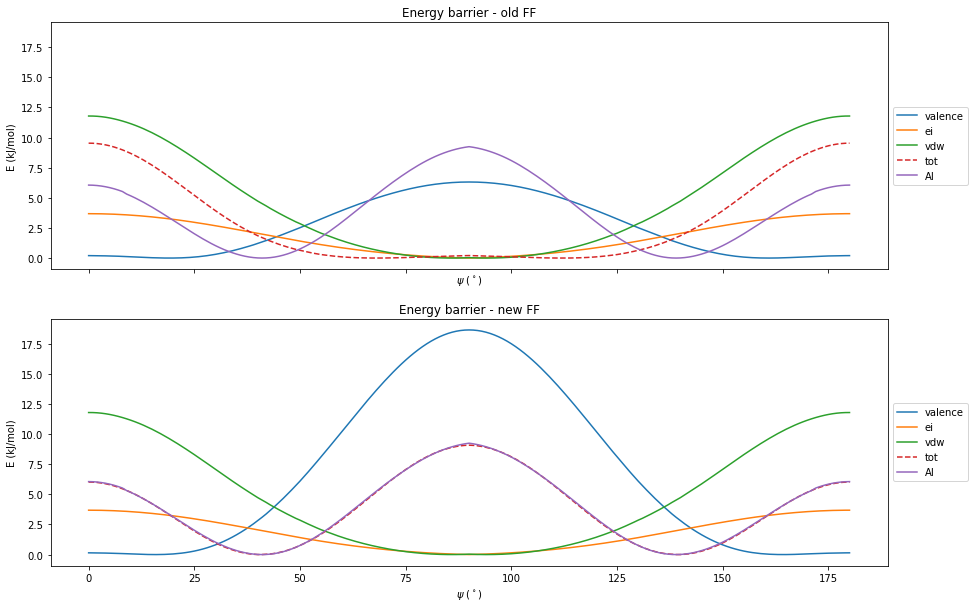

PA11_amine
Mirroring


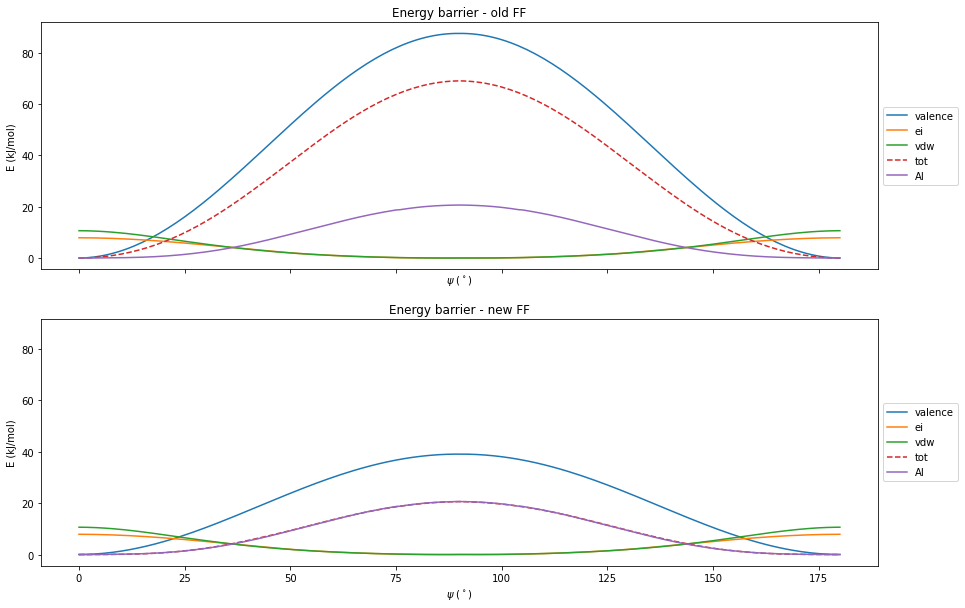

PA11_vertex
Mirroring


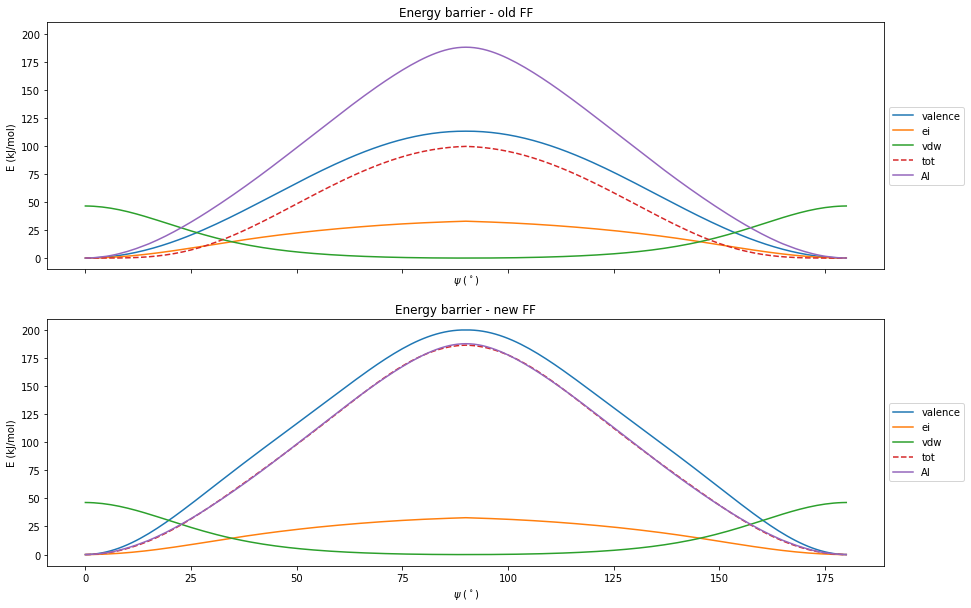

PA12_imine
Mirroring


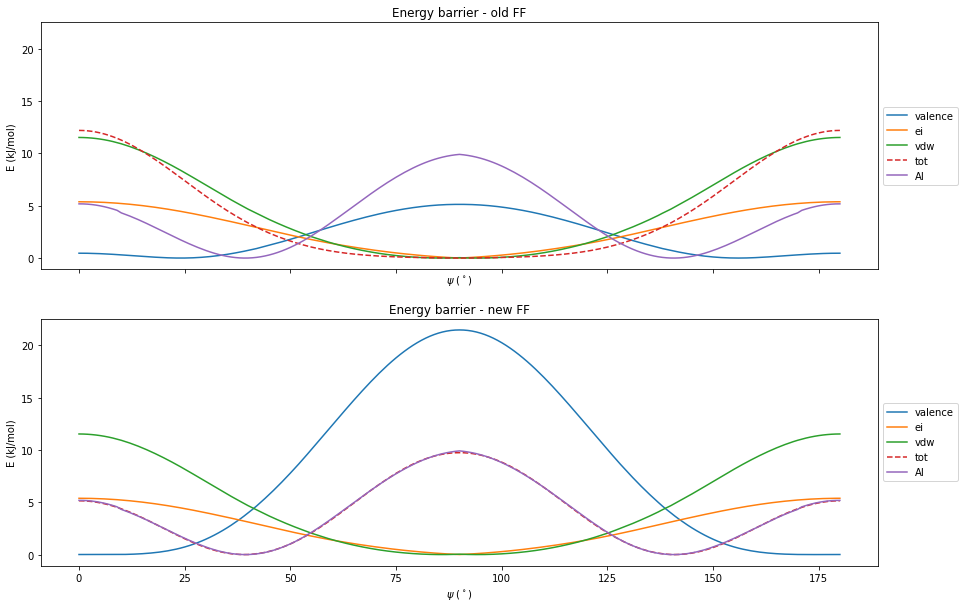

PA12_amine
Mirroring


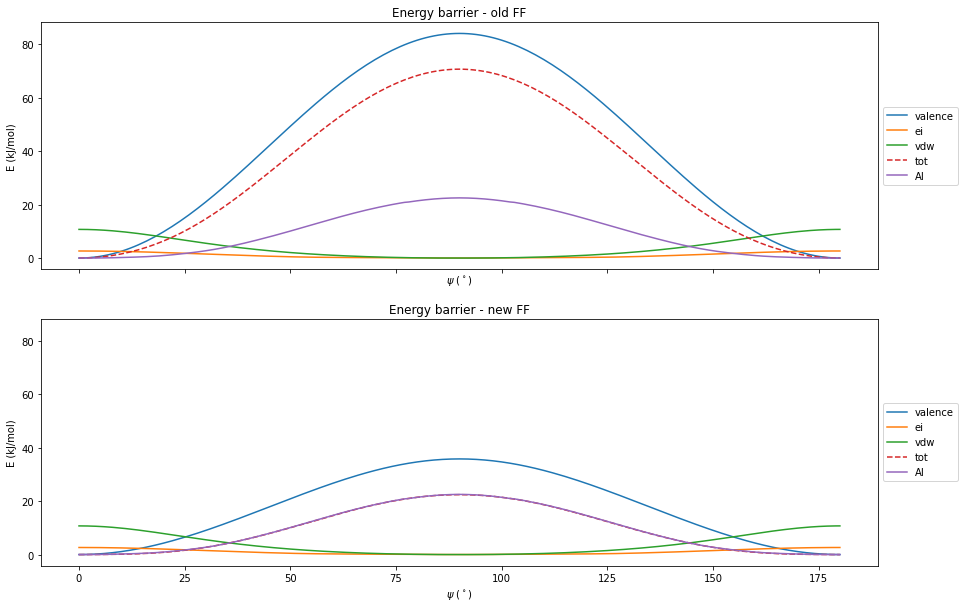

PA12_vertex
Mirroring


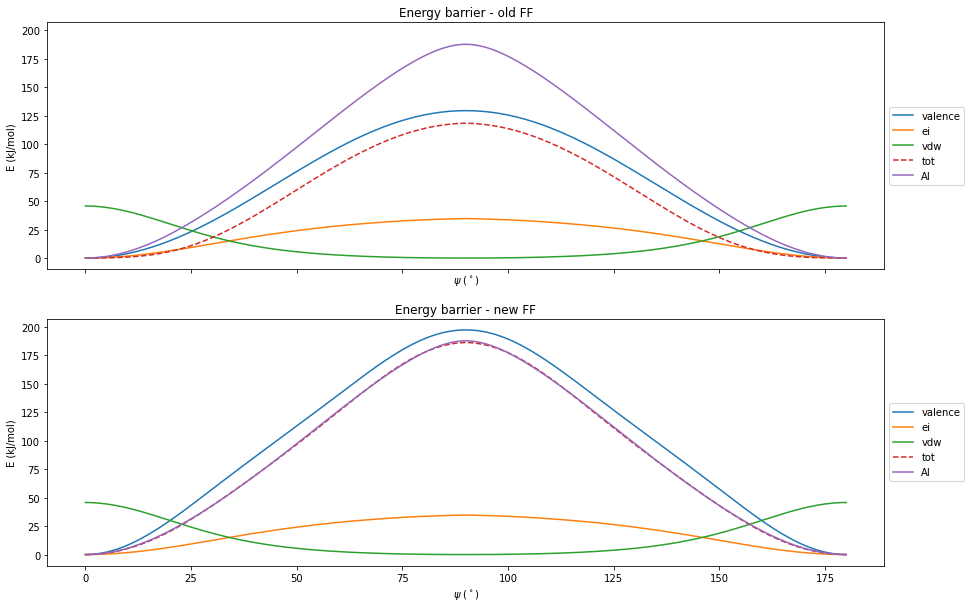

TPB_imine
Mirroring


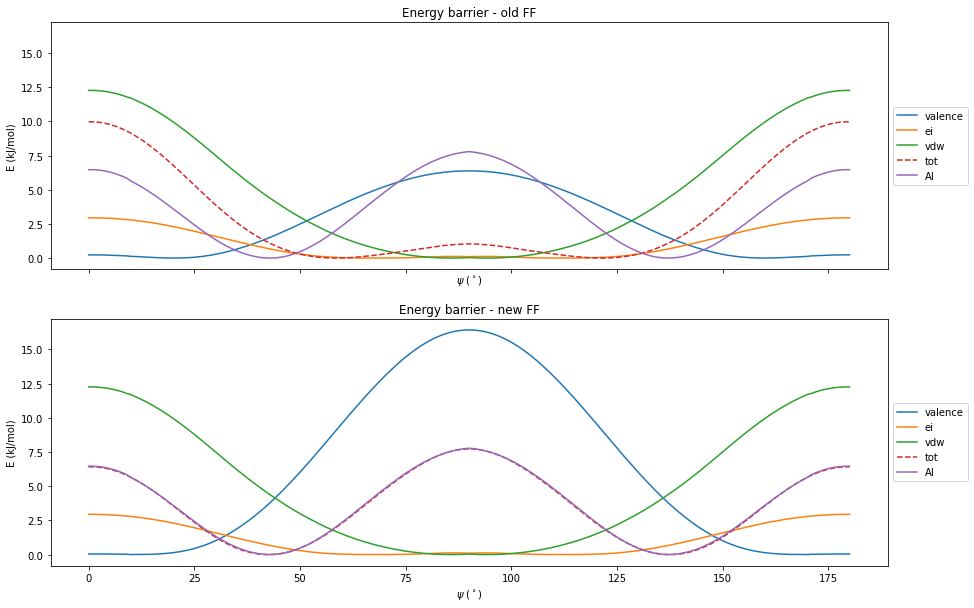

TPB_vertex
Mirroring


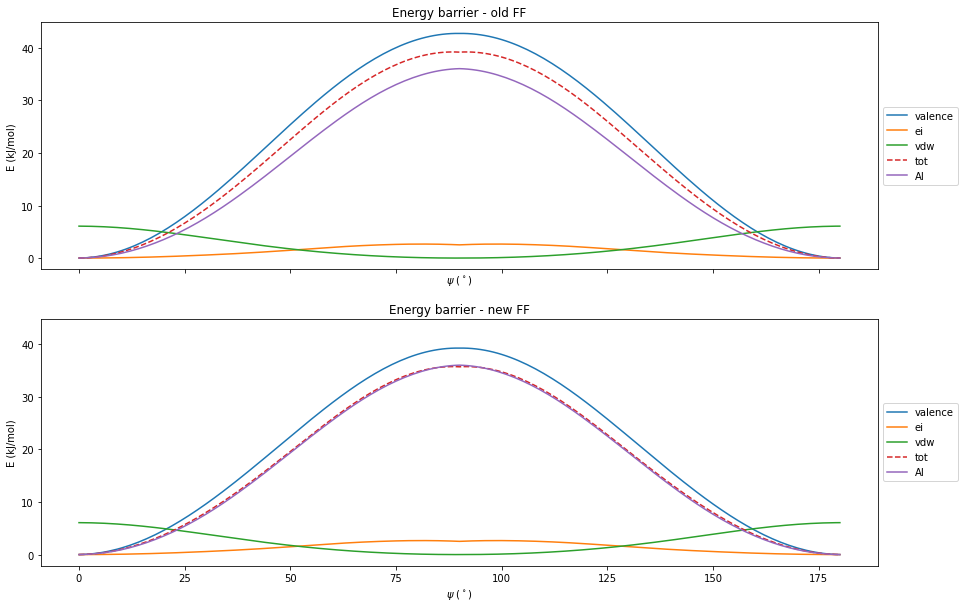

TP_amine
Mirroring


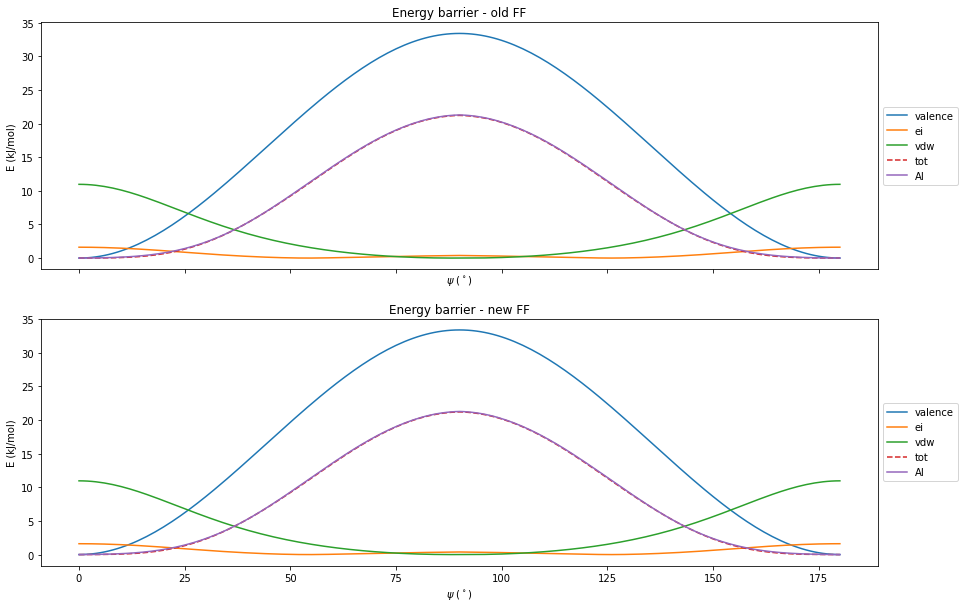

TP_vertex
Mirroring


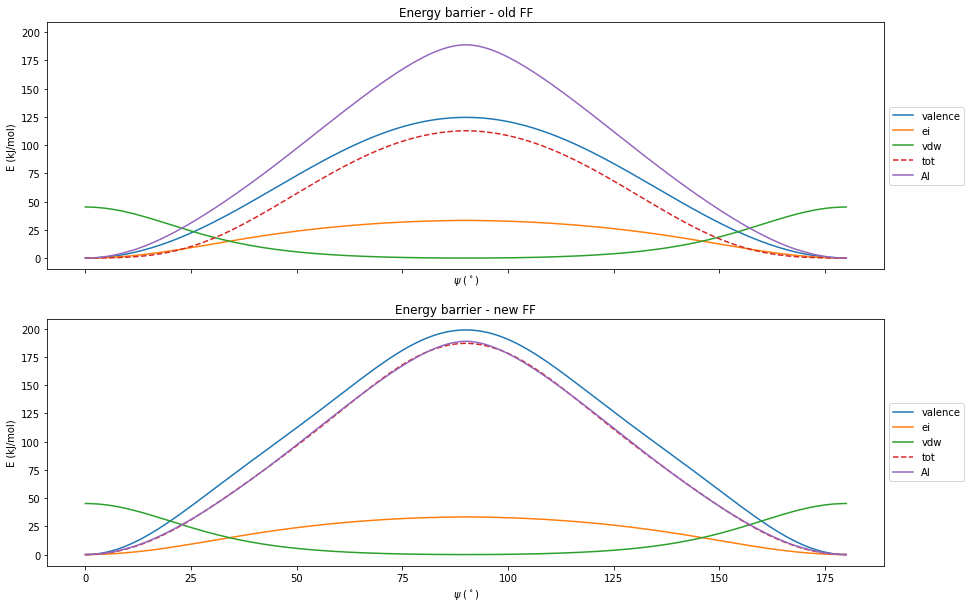

In [58]:
for name,sinfo in sinfos_rasha.items():
    full_plot(sinfo.pr,name,sinfo,ai_data_rasha[name],ff_rasha_datas[name],save_png=True)

## Test FF - compare optimal structure with AI

### Functions

In [59]:
import difflib

def overlap_ffpars(ffp1,ffp2):
    # Compare two force field parameter files and return the overlapping terms
    # If second argument is a list, perform iteratively
    assert isinstance(ffp1,str)
    if isinstance(ffp2,list):
        ref_ffp = copy.copy(ffp1)
        for ffp in ffp2:
            ref_ffp = overlap_ffpars(ref_ffp,ffp)
        return ref_ffp
    
    elif isinstance(ffp2,str):
        new_ffp = ''
        diff = difflib.ndiff(ffp1.splitlines(keepends=True),ffp2.splitlines(keepends=True))
        for s in diff:
            if s[0]==' ': # no changes
                new_ffp += s[2:]
        return new_ffp
    
    else:
        raise ValueError
        
def extend_ffpars(ffp1,ffp2):
    # Compare two force field parameter files and return both the overlap and the extensions
    # If second argument is a list, perform iteratively
    assert isinstance(ffp1,str)
    if isinstance(ffp2,list):
        ref_ffp = copy.copy(ffp1)
        for ffp in ffp2:
            ref_ffp = extend_ffpars(ref_ffp,ffp)
        return ref_ffp
    
    elif isinstance(ffp2,str):
        new_ffp = ''
        diff = difflib.ndiff(ffp1.splitlines(keepends=True),ffp2.splitlines(keepends=True))
        for s in diff:
            if not s[0]=='?': # eye guides in diff
                new_ffp += s[2:]
        return new_ffp
    
    else:
        raise ValueError

def compare_structure_old(name,sinfo,old,new,ai,save_png=False):
    structures = {'old':old, 'new':new, 'ai':ai}
    compare_structures(name,sinfo.pr,sinfo.ff,structures,save_png=False)

### Layer stacking

In [64]:
pr_rasha.job_table(sort_by='status')

id    status chemicalformula         job       subjob  \
0    81941  finished        C20H16N2       job_0       /job_0   
633  82786  finished        C27H21N3      job_85      /job_85   
634  82787  finished        C27H21N3      job_86      /job_86   
635  82788  finished        C27H21N3      job_87      /job_87   
636  82789  finished        C27H21N3      job_88      /job_88   
..     ...       ...             ...         ...          ...   
326  82267  finished      C34H26N4O3      job_53      /job_53   
327  82268  finished      C34H26N4O3      job_54      /job_54   
328  82269  finished      C34H26N4O3      job_55      /job_55   
240  82181  finished      C34H26N4O3      job_58      /job_58   
961  83118  finished      C27H21N3O3  opt_new_ff  /opt_new_ff   

                                                        projectpath  \
0    /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
633  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
634  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
635  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
636  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
..                                                              ...   
326  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
327  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
328  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
240  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   
961  /kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/   

                                            project  \
0    doctoraat/barriers/rasha/PA22_imine_2_0_10_11/   
633  doctoraat/barriers/rasha/TPB_vertex_1_0_15_16/   
634  doctoraat/barriers/rasha/TPB_vertex_1_0_15_16/   
635  doctoraat/barriers/rasha/TPB_vertex_1_0_15_16/   
636  doctoraat/barriers/rasha/TPB_vertex_1_0_15_16/   
..                                              ...   
326  doctoraat/barriers/rasha/PA12_amine_3_1_18_19/   
327  doctoraat/barriers/rasha/PA12_amine_3_1_18_19/   
328  doctoraat/barriers/rasha/PA12_amine_3_1_18_19/   
240  doctoraat/barriers/rasha/PA12_imine_2_0_10_11/   
961   doctoraat/barriers/rasha/TP_9_12_18_29_ffopt/   

                     timestart                   timestop  totalcputime  \
0   2023-10-11 14:42:38.429096 2023-10-11 14:50:27.559746         469.0   
633 2023-10-15 19:43:34.152062 2023-10-15 19:51:54.558916         500.0   
634 2023-10-15 19:43:34.126029 2023-10-15 19:51:52.622664         498.0   
635 2023-10-15 19:43:55.554610 2023-10-15 19:51:59.307334         483.0   
636 2023-10-15 19:43:57.072817 2023-10-15 19:51:34.347799         457.0   
..                         ...                        ...           ...   
326 2023-10-11 16:40:58.554295 2023-10-11 16:54:55.368815         836.0   
327 2023-10-11 16:40:58.606620 2023-10-11 16:54:46.024652         827.0   
328 2023-10-11 16:40:58.580086 2023-10-11 16:54:32.567490         813.0   
240 2023-10-11 16:09:25.339555 2023-10-11 16:38:27.421866        1742.0   
961 2023-10-16 12:42:37.294985 2023-10-16 12:43:12.013276          34.0   

                               computer  hamilton hamversion parentid masterid  
0    pyiron@node4003.donphan.os#9#doduo  Gaussian        0.1     None     None  
633  pyiron@node4008.donphan.os#9#doduo  Gaussian        0.1     None     None  
634  pyiron@node4008.donphan.os#9#doduo  Gaussian        0.1     None     None  
635  pyiron@node4008.donphan.os#9#doduo  Gaussian        0.1     None     None  
636  pyiron@node4008.donphan.os#9#doduo  Gaussian        0.1     None     None  
..                                  ...       ...        ...      ...      ...  
326  pyiron@node4003.donphan.os#9#doduo  Gaussian        0.1     None     None  
327  pyiron@node4003.donphan.os#9#doduo  Gaussian        0.1     None     None  
328  pyiron@node4003.donphan.os#9#doduo  Gaussian        0.1     None     None  
24

In [60]:
# Perform the optimization
for key,val in sinfo_rasha_groups.items():
    print('{}: {}'.format(key,','.join(list(val.keys()))))   

    val_keys = list(val.keys())
    print(val_keys)
    sinfos = [val[k] for k in val_keys]  
    sinfo = sinfos[0]

    ffpars = sinfo.ff.ffpars
    ffpars_nodih = overlap_ffpars(sinfo.ff.ffpars_nodih,[sinfo.ff.ffpars_nodih for sinfo in sinfos[1:]])
    ffpars_polysix = extend_ffpars(sinfo.ff.ffpars_polysix,[sinfo.ff.ffpars_polysix for sinfo in sinfos[1:]])
    
     # reinstate correct geometry for ff optimization
    block = './input_files/barriers/rasha/SBU_FFs/{}/'.format(key.replace('_','-'))
    tmp = pr.create_job(pr.job_type.Yaff,'tmp',delete_existing_job=False)
    tmp.load_chk(glob.glob(block+'*_freq.chk')[0])
    structure = tmp.structure.copy() # ai structure

    pr_sub = Project(sinfo.get_sub_project_name(key,suffix='ffopt'))

    yaff_opt_job(pr_sub, 'opt_old_ff', structure, sinfo.ff, ffpars)
    yaff_opt_job(pr_sub, 'opt_new_ff', structure, sinfo.ff, ffpars_nodih + ffpars_polysix)

PA11: PA11_amine,PA11_vertex
TP: TP_amine,TP_vertex
['TP_amine', 'TP_vertex']
This group does not exist in the HDF5 file tmp
The job opt_old_ff was saved and received the ID: 83117
Queue system id:  589320254
The job opt_new_ff was saved and received the ID: 83118
Queue system id:  589320264
TPB: TPB_imine,TPB_vertex
PA12: PA12_imine,PA12_amine,PA12_vertex
PA22: PA22_imine


['PA11_amine', 'PA11_vertex']
PA11 ICs

Bonds:
['C2_term', 'C1_term'] 0.016647308499430302
['C3_term', 'C2_term'] 0.01269465950895321
['C4_term', 'C3_term'] 0.014530346172986874
['C5_0_term', 'C4_term'] 0.01270039091770081
['C4_term', 'C5_0_term'] 0.015251160946448072
['C3_term', 'C2_term'] 0.014721954143392724
['C3_term', 'C4_term'] 0.010906260957156855
['C2_term', 'C1_term'] 0.016669546585725392
['C3_term', 'C2_term'] 0.012823906633955717
['C4_term', 'C3_term'] 0.01455588320933554
['C5_0_term', 'C4_term'] 0.01266734511452694
['C4_term', 'C5_0_term'] 0.015118161859069668
['C3_term', 'C2_term'] 0.014718838988592386
['C3_term', 'C4_term'] 0.01081316746018568
['C5_1_term', 'C4_term'] 0.017900189049639303
['C5_1_term', 'C4_term'] 0.017995983151921413
['C5_1_term', 'C4_term'] 0.017958796192958815
['C5_1_term', 'C4_term'] 0.017566381486760818
['H_N_0_PA11', 'N_0_PA11'] 0.026645990479360115
['H_N_0_PA11', 'N_0_PA11'] 0.02674460066584894
['C7_term', 'N6_term'] 0.015809638298146078
['H7_term',

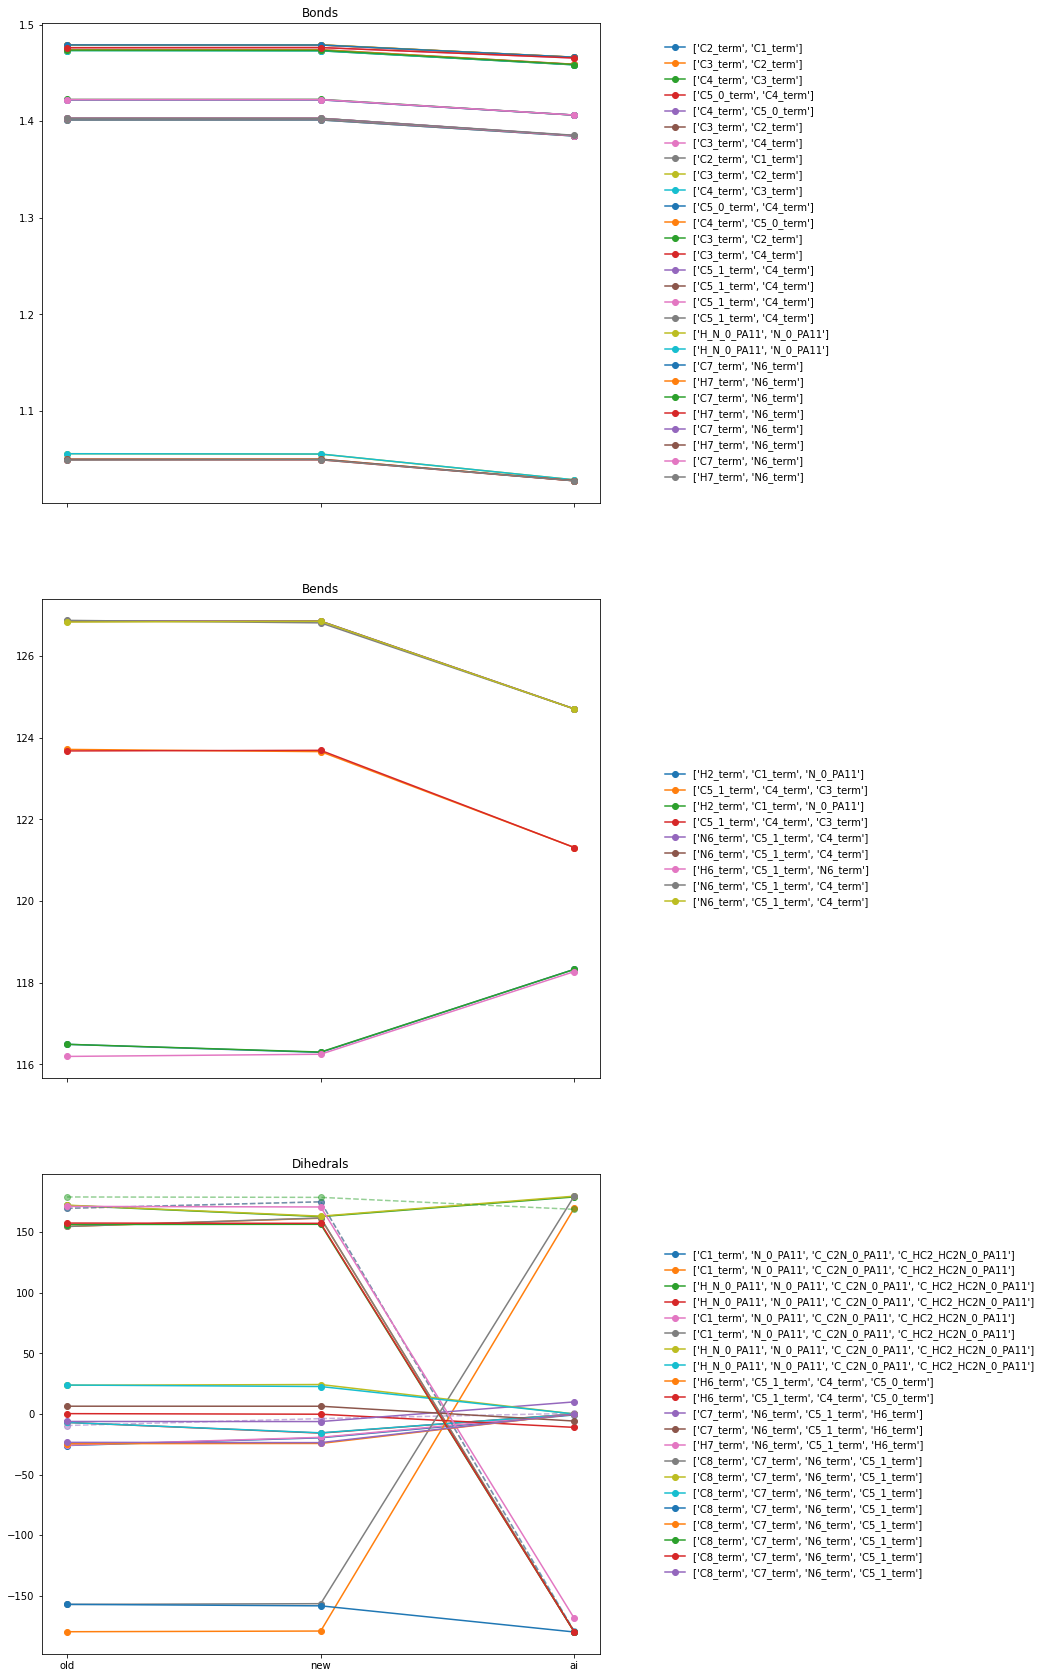

['TP_amine', 'TP_vertex']
TP ICs

Bonds:
['C_C2O_TP', 'C_C3_TP'] 0.012764198724867226
['C_C3_TP', 'C_C2O_TP'] 0.015504261078920889
['C_C2O_TP', 'C_C3_TP'] 0.012766719637414603
['C_C3_TP', 'C_C2O_TP'] 0.015518533845174431
['C_C2O_TP', 'C_C3_TP'] 0.01549196248603768
['C_C2O_TP', 'C_C3_TP'] 0.012760648407836639
['C_HCN_TP', 'C_C3_TP'] 0.017264237232832436
['C_HCN_TP', 'C_C3_TP'] 0.017255242684078187
['C_HCN_TP', 'C_C3_TP'] 0.01726415114333535
['C2_term', 'N1_term'] 0.01512567313890223
['H2_term', 'N1_term'] 0.021110319898261842
['C2_term', 'N1_term'] 0.015126177320229806
['H2_term', 'N1_term'] 0.021121354745453624
['C2_term', 'N1_term'] 0.01511977765817063
['H2_term', 'N1_term'] 0.02111991822875381
Bends:
['C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 2.126605223945685
['C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 2.1288163702354908
['C_HCN_TP', 'C_C3_TP', 'C_C2O_TP'] 2.1350233410432797
['N1_term', 'C_HCN_TP', 'C_C3_TP'] 2.098396134725767
['N1_term', 'C_HCN_TP', 'C_C3_TP'] 2.0932800340034525
['N1_term', 'C_HC

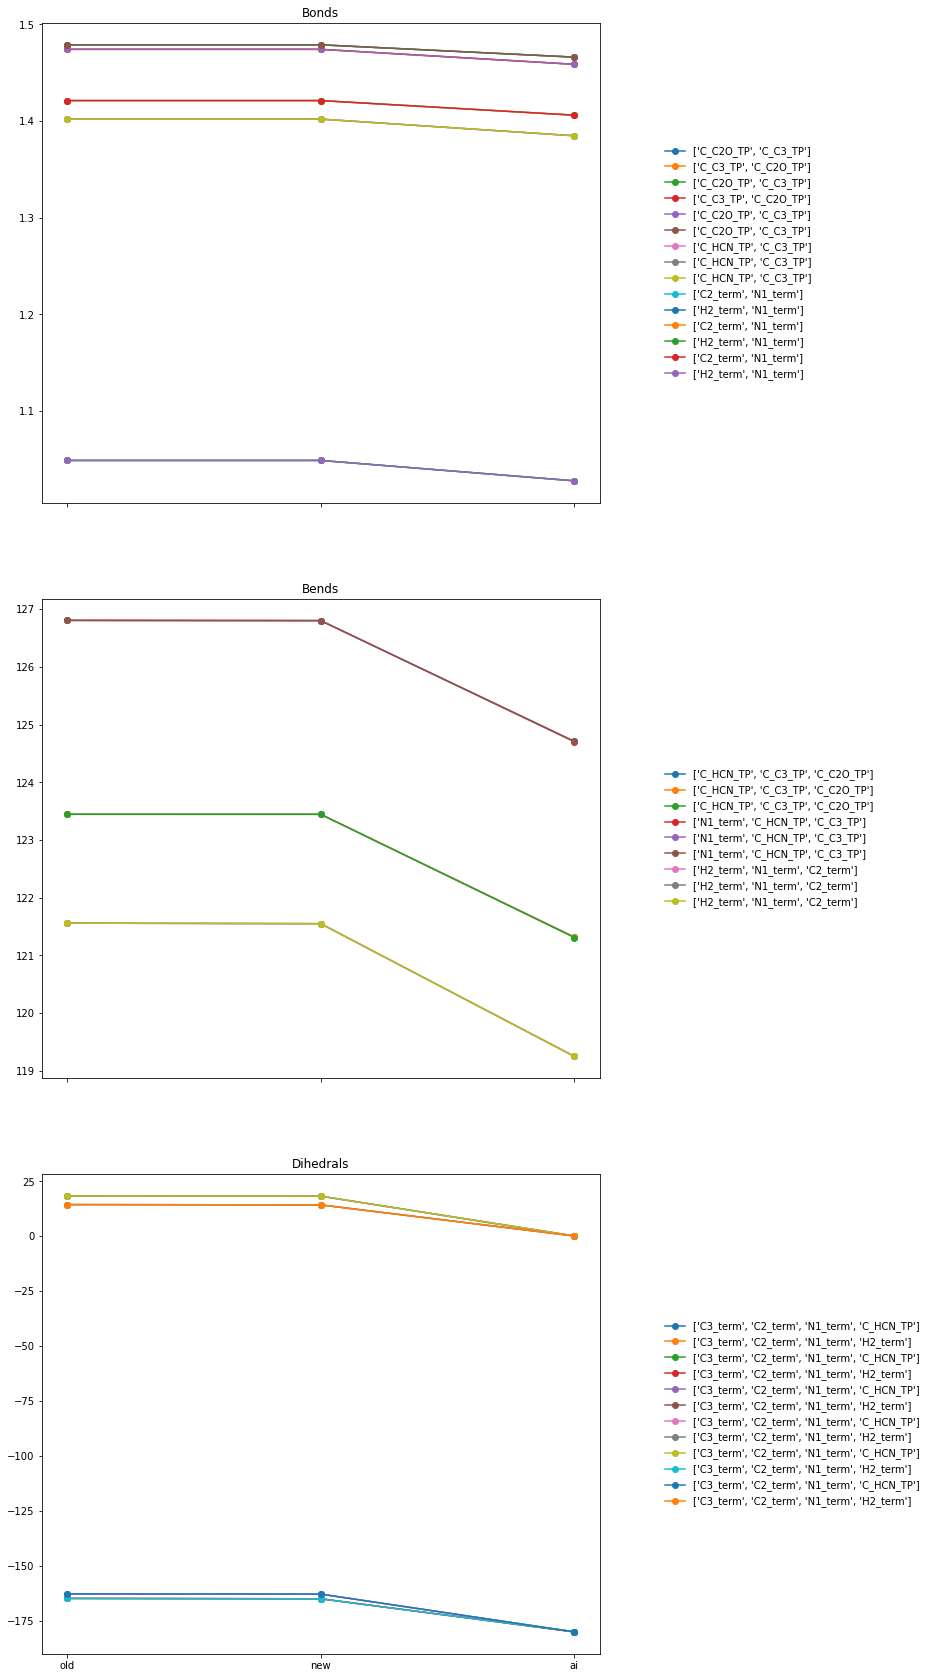

['TPB_imine', 'TPB_vertex']
TPB ICs

Bonds:
['C_C3_H3C2N_TPB', 'C_HC2_C4_TPB'] 0.010439210626839834
['C_C3_H3C2N_TPB', 'C_HC2_C4_TPB'] 0.010433051312856101
['C_HC2_C4_TPB', 'C_C3_H3C2N_TPB'] 0.010429036165633176
['C4_term', 'C5_term'] 0.023912812186280386
['C_HCN_C3_TPB', 'C_C3_H3C2N_TPB'] 0.011182728630917182
['H5_term', 'C4_term'] 0.10901336211055646
['H5_term', 'C4_term'] 0.06995940828895186
['C4_term', 'C5_term'] 0.023616851585740006
['C_HCN_C3_TPB', 'C_C3_H3C2N_TPB'] 0.011188596874431411
['H5_term', 'C4_term'] 0.1078316820015881
['H5_term', 'C4_term'] 0.06925031874964227
['C4_term', 'C5_term'] 0.022598040210055403
['C_HCN_C3_TPB', 'C_C3_H3C2N_TPB'] 0.011190034395747173
['H5_term', 'C4_term'] 0.10373182385946911
['H5_term', 'C4_term'] 0.06671721933233155
Bends:
['H5_term', 'C4_term', 'C5_term'] 2.2725594010818155
['H5_term', 'C4_term', 'C3_term'] 2.6846576558500472
['H5_term', 'C4_term', 'C5_term'] 3.9423126020518175
['H5_term', 'C4_term', 'C3_term'] 3.46876012697756
['H5_term', 'C

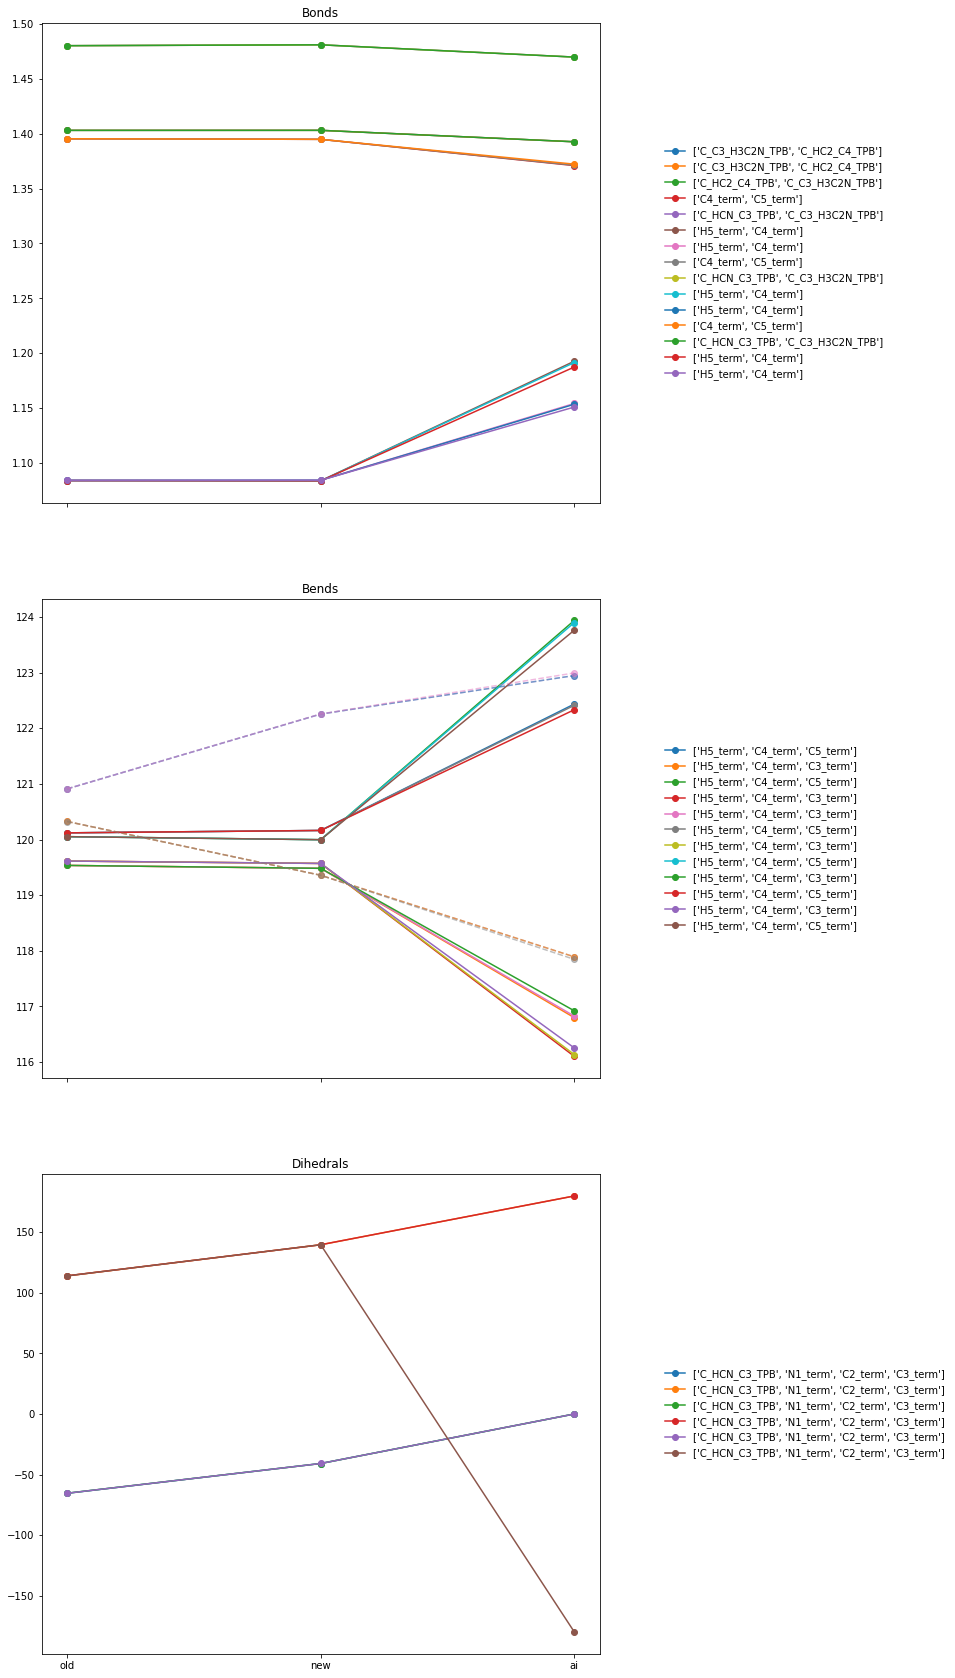

['PA12_imine', 'PA12_amine', 'PA12_vertex']
PA12 ICs

Bonds:
['H_C_C2_0_PA12', 'C_HC2_HC2N_0_PA12'] 0.018141762560115016
['H_C_C2_0_PA12', 'C_HC2_HC2N_0_PA12'] 0.014914441909265053
['N_HC2_0_PA12', 'C_C2N_H3C3_0_PA12'] 0.010664240196073926
['C2_1_term', 'C1_term'] 0.014897721979644007
['C3_1_term', 'C2_1_term'] 0.0124343643225302
['C4_1_term', 'C3_1_term'] 0.01550424764285463
['C5_1_term', 'C4_1_term'] 0.012717735724292245
['C4_1_term', 'C5_1_term'] 0.015541995757985427
['C3_1_term', 'C2_1_term'] 0.01494588252705964
['C3_1_term', 'C4_1_term'] 0.011359302777908642
['C5_2_term', 'C4_1_term'] 0.017105663745003996
['C5_2_term', 'C4_1_term'] 0.017290045178332214
['H_N_0_PA12', 'N_HC2_0_PA12'] 0.01802604963028287
['C7_term', 'N6_term'] 0.015815276085656027
['H7_term', 'N6_term'] 0.022680695146791496
['C7_term', 'N6_term'] 0.016213362774734508
['H7_term', 'N6_term'] 0.023373722808484487
Bends:
['C3_1_term', 'C2_1_term', 'C1_term'] 2.012081431626854
['C5_2_term', 'C4_1_term', 'C3_1_term'] 2.21

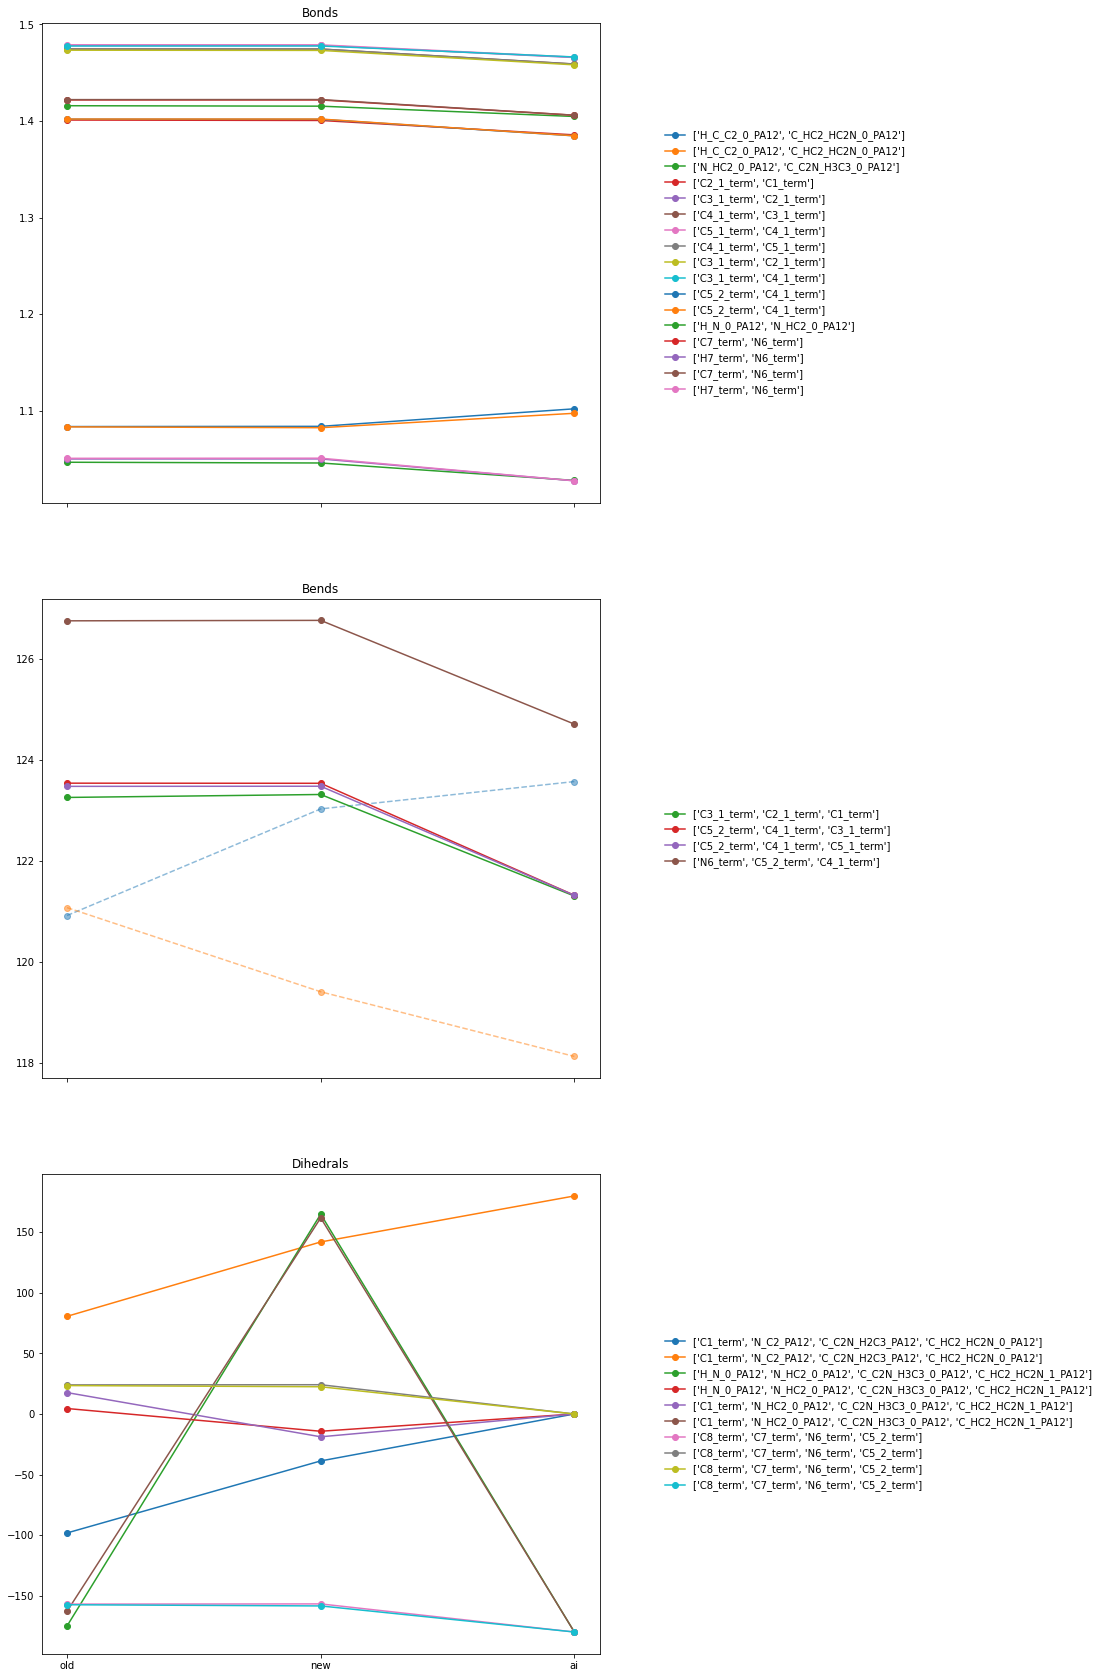

['PA22_imine']


No handles with labels found to put in legend.


PA22 ICs

Bonds:
['C_HC2_PA22', 'C_C2N_PA22'] 0.011007242666511985
['H_C_PA22', 'C_HC2_PA22'] 0.018363508034421328
['H_C_PA22', 'C_HC2_PA22'] 0.05104091252126719
['C2_term', 'C1_term'] 0.010756125660758675
['H6_term', 'C5_term'] 0.014285201163706018
['C2_term', 'C1_term'] 0.010753010265938334
Bends:
Dihedrals:
['N_C2_PA22', 'C_C2N_PA22'] 40.61226494600132





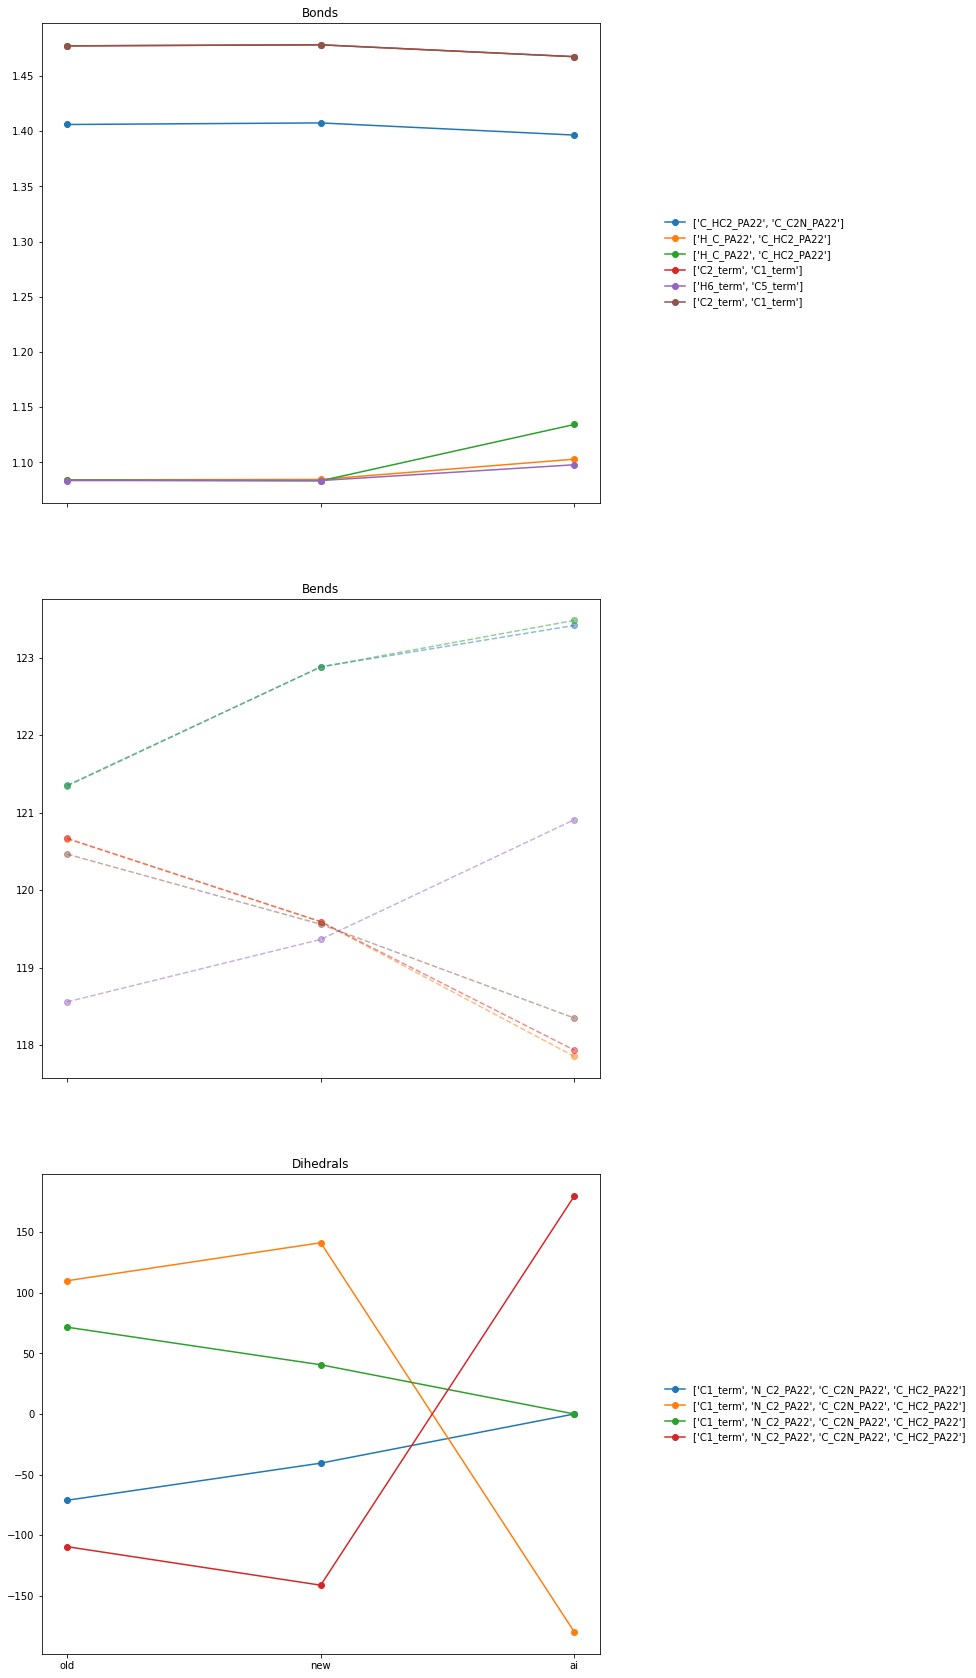

In [65]:
# Compare structures
for key,val in sinfo_rasha_groups.items():
    val_keys = list(val.keys())
    print(val_keys)
    sinfos = [val[k] for k in val_keys]  
    sinfo = sinfos[0]

    pr_sub = Project(sinfo.get_sub_project_name(key,suffix='ffopt'))
    compare_structure_old(key,sinfo,pr_sub.load('opt_old_ff').get_structure(),pr_sub.load('opt_new_ff').get_structure(),sinfo.ff.structure,save_png=True)

In [66]:
sinfo_rasha_groups.keys()

dict_keys(['PA11', 'TP', 'TPB', 'PA12', 'PA22'])

In [73]:
key = 'PA12'
val = sinfo_rasha_groups[key]
val_keys = list(val.keys())
sinfos = [val[k] for k in val_keys]  
sinfo = sinfos[0]
pr_sub = Project(sinfo.get_sub_project_name(key,suffix='ffopt'))
job_opt = pr_sub.load('opt_new_ff')
job_opt.animate_structure(spacefill=False)

NGLWidget(max_frame=2588)

In [50]:
job_opt.structure.get_chemical_formula()

'C48H36N6O6'